# AlphaPept Systems Check

This notebook will run several tests and compare the performance to MaxQuant. Depending on the machine, this can take several hours.
Each run is called via the `test_ci.py` script, which downloads files to a temporary folder which can be specified in this file.

This notebook requires the `matplotlib_venn` (`!pip install matplotlib_venn`) package.

## Reference Data

Download MaxQuant reference files. Referance MaxQuant data from `PXD006109` and `PXD010012` were taken from the paper, the others were analyzed with `MaxQuant_1.6.14`, default settings w/o second peptides and provided with the given contaminants file.

In [1]:
import os
import sys
sys.path.append(os.path.join(".."))
import test_ci

try:
    import wget
except ImportError:
    !pip install wget
    import wget
    
FILE_DICT = {}
#FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/1E2G1IwgcgdsCHC/download' #OLD MQ FILES
#FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/Fn2uxeYNL60JSd3/download'

#FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/vMNferEoSoROJbb/download' #AP Files
#FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/KLBotZbodMByigh/download'

FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/fLhxQ8mVb29x9xH/download'
FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/BkMMHPregCQgKLg/download'
FILE_DICT['PXD010012_ref.txt'] = 'https://datashare.biochem.mpg.de/s/ps226k7Fme1K0jf/download'
FILE_DICT['PXD010012_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/pyhKMrytjdDU2sX/download'
FILE_DICT['bruker_HeLa_evd.txt'] = 'https://datashare.biochem.mpg.de/s/fRcoGuwlcbH2SBJ/download'
FILE_DICT['thermo_HeLa_evd.txt'] = 'https://datashare.biochem.mpg.de/s/p4Omj9K5hHmSoDl/download'

tmp_folder = os.path.join(os.getcwd(),'temp/')


BASE_DIR = os.path.join(tmp_folder , 'test_files/') # Storarge location for test files
TEST_DIR = os.path.join(tmp_folder, 'test_temp/')
ARCHIVE_DIR = os.path.join(tmp_folder, ' test_archive/')

MONGODB_USER = 'github_actions'
MONGODB_URL = 'ci.yue0n.mongodb.net/'

if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)


test_ci.config_test_paths(BASE_DIR, TEST_DIR, ARCHIVE_DIR, MONGODB_USER, MONGODB_URL)

for file in FILE_DICT:
    target = os.path.join(tmp_folder, file)
    if not os.path.isfile(target):
        wget.download(FILE_DICT[file], target)
        
software_1 = 'AlphaPept'
software_2 = 'MaxQuant'

## Single Files

Compare to the single HeLa test files

### Thermo IRT

In [2]:
%run -i ../test_ci.py $tmp_folder thermo_irt

2021-08-29 20:34:08> Logging to C:\Users\admin\alphapept\logs\log_20210829203408.txt.
2021-08-29 20:34:09> Platform information:
2021-08-29 20:34:09> system     - Windows
2021-08-29 20:34:09> release    - 10
2021-08-29 20:34:09> version    - 10.0.18363
2021-08-29 20:34:09> machine    - AMD64
2021-08-29 20:34:09> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-29 20:34:09> cpu count  - 24
2021-08-29 20:34:09> ram memory - 121.7/127.7 Gb (available/total)
2021-08-29 20:34:09> 
2021-08-29 20:34:09> Python information:
2021-08-29 20:34:09> SQLAlchemy       - 1.3.22
2021-08-29 20:34:09> alphapept        - 0.3.28
2021-08-29 20:34:09> biopython        - 1.78
2021-08-29 20:34:09> click            - 7.1.2
2021-08-29 20:34:09> comtypes         - 1.1.7
2021-08-29 20:34:09> fastcore         - 1.3.21
2021-08-29 20:34:09> h5py             - 3.1.0
2021-08-29 20:34:09> lxml             - 4.6.2
2021-08-29 20:34:09> matplotlib       - 3.3.3
2021-08-29 20:34:09> networkx         -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:34:09> FASTA contains 247 entries.


100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [00:28<00:00, 28.87s/it]

2021-08-29 20:34:38> Digested 247 proteins and generated 50,840 spectra
2021-08-29 20:34:38> Database saved to F:\develop\alphapept\sandbox\temp\test_temp\database.hdf. Filesize of database is 0.02 GB



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:34:38> Processing 1 files for step raw_conversion
2021-08-29 20:34:38> File F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT has extension .raw - converting from Thermo.


100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [00:30<00:00, 30.35s/it]


2021-08-29 20:34:43> File conversion complete. Extracted 2,603 precursors.
2021-08-29 20:34:43> File conversion of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.raw complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:34:49> Processing 1 files for step find_features
2021-08-29 20:34:49> No *.hdf file with features found for F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.ms_data.hdf. Adding to feature finding list.
2021-08-29 20:34:49> Feature finding on F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.raw
2021-08-29 20:34:49> Hill extraction with centroid_tol 8 and max_gap 2
2021-08-29 20:34:52> Number of hills 45,516, len = 20.18
2021-08-29 20:34:52> Repeating hill extraction with centroid_tol 5.10
2021-08-29 20:34:53> Number of hills 52,919, len = 21.29
2021-08-29 20:34:59> After split hill_ptrs 79,545
2021-08-29 20:35:00> After filter hill_ptrs 77,220
2021-08-29 20:35:13> Extracting hill stats complete
2021-08-29 20:35:16> Found 7,527 pre isotope patterns.
2021-08-29 20:35:31> Extracted 7,607 isotope patterns.
2021-08-29 20:35:37> Report complete.
2021-08-29 20:35:37> Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:37> Starting first search.
2021-08-29 20:35:37> Processing 1 files for step search_db
2021-08-29 20:35:37> Calibrating fragments
2021-08-29 20:35:39> Performing search on 3,225 query and 50,840 db entries with frag_tol = 30.00 and prec_tol = 30.00.


  0%|                                                                                            | 0/1 [00:51<?, ?it/s]


2021-08-29 20:35:41> Found 53 psms.
2021-08-29 20:35:41> Extracting columns for scoring.
2021-08-29 20:35:47> Extracted columns from 53 spectra.
2021-08-29 20:35:47> Saving first_search results to F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.ms_data.hdf
2021-08-29 20:35:47> Search of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.raw complete.
2021-08-29 20:35:47> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:47> Processing 1 files for step calibrate_hdf
2021-08-29 20:35:47> Scoring using X-Tandem
2021-08-29 20:35:47> Last q_value 0.000 of dataset is smaller than fdr_level 0.010
2021-08-29 20:35:47> 20 target (0 decoy) of 20 PSMs. fdr 0.000000 for a cutoff of 18.90 (set fdr was 0.01)
2021-08-29 20:35:47> Not enough data points present. Skipping recalibration.
2021-08-29 20:35:47> Calibration of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.ms_data.hdf complete.
2021-08-29 20:35:47> Calibrating fragments
2021-08-29 20:35:47> Median fragment offset 0.12 - std 14.24 ppm - mad 10.43 ppm




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:47> Starting second search with DB.
2021-08-29 20:35:47> Processing 1 files for step search_db
2021-08-29 20:35:47> Found calibrated prec_tol with value 5.29
2021-08-29 20:35:47> Found calibrated frag_tol with value 31.28
2021-08-29 20:35:47> Performing search on 3,225 query and 50,840 db entries with frag_tol = 31.28 and prec_tol = 5.29.


  0%|                                                                                            | 0/1 [00:01<?, ?it/s]


2021-08-29 20:35:49> Found 47 psms.
2021-08-29 20:35:49> Extracting columns for scoring.
2021-08-29 20:35:54> Extracted columns from 47 spectra.
2021-08-29 20:35:54> Saving second_search results to F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.ms_data.hdf
2021-08-29 20:35:54> Search of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_IRT.raw complete.
2021-08-29 20:35:54> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:54> Processing 1 files for step score_hdf
2021-08-29 20:35:54> Found second search psms for scoring.
2021-08-29 20:35:55> Last q_value 0.000 of dataset is smaller than fdr_level 0.100
2021-08-29 20:35:55> 18 target (0 decoy) of 18 PSMs. fdr 0.000000 for a cutoff of 18.90 (set fdr was 0.1)
2021-08-29 20:35:55> The total number of available decoys is lower than the initial set of high scoring targets.
2021-08-29 20:35:55> ML failed. Defaulting to x_tandem score
2021-08-29 20:35:55> There are fewer high scoring targets or decoys than required by 'min_train'.
2021-08-29 20:35:55> Converting x_tandem score to probabilities
2021-08-29 20:35:55> Filter df with custom score
2021-08-29 20:35:55> Global FDR on precursor
2021-08-29 20:35:55> Last q_value 0.000 of dataset is smaller than fdr_level 0.010
2021-08-29 20:35:55> 16 target (0 decoy) of 16 PSMs. fdr 0.000000 for a cutoff of 0.11 (set fdr was 0.01)
2021-08-29 20:35:55> FDR on peptides complete. For 0.01 FDR found 18 targe


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:55> Fasta dict with length 247, Pept dict with length 50,842
2021-08-29 20:35:55> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-08-29 20:35:56> A total of 13 unique and 0 shared peptides.
2021-08-29 20:35:56> A total of 0 ambigious proteins
2021-08-29 20:35:56> A total of 0 unique and 0 shared peptides.
2021-08-29 20:35:56> A total of 0 ambigious proteins
2021-08-29 20:35:56> Global FDR on protein_group
2021-08-29 20:35:56> Last q_value 0.000 of dataset is smaller than fdr_level 0.010
2021-08-29 20:35:56> 3 target (0 decoy) of 3 PSMs. fdr 0.000000 for a cutoff of 0.26 (set fdr was 0.01)
2021-08-29 20:35:56> FDR on proteins complete. For 0.01 FDR found 18 targets and 0 decoys. A total of 3 proteins found.
2021-08-29 20:35:56> Saving complete.
2021-08-29 20:35:56> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx', 'n_possible_proteins'],
      dtype='object')]

  pytables.to_hdf(
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:56> Complete. 
2021-08-29 20:35:56> Starting profile extraction.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:35:56> LFQ complete.
2021-08-29 20:35:56> Extracting protein_summary
2021-08-29 20:35:56> Saved protein_summary of length 3 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-29 20:35:56> Exporting as csv.
2021-08-29 20:35:56> Saved df of length 18 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-29 20:35:56> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-29 20:35:56> Analysis complete.


### Thermo HeLa

In [3]:
%run -i ../test_ci.py $tmp_folder thermo_hela

2021-08-29 20:35:56> Creating dir F:\develop\alphapept\sandbox\temp/test_temp.
2021-08-29 20:35:58> Using Python version for testing
2021-08-29 20:35:58> Logging to C:\Users\admin\alphapept\logs\log_20210829203558.txt.
2021-08-29 20:35:58> Platform information:
2021-08-29 20:35:58> system     - Windows
2021-08-29 20:35:58> release    - 10
2021-08-29 20:35:58> version    - 10.0.18363
2021-08-29 20:35:58> machine    - AMD64
2021-08-29 20:35:58> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-29 20:35:58> cpu count  - 24
2021-08-29 20:35:58> ram memory - 118.5/127.7 Gb (available/total)
2021-08-29 20:35:58> 
2021-08-29 20:35:58> Python information:
2021-08-29 20:35:58> SQLAlchemy       - 1.3.22
2021-08-29 20:35:58> alphapept        - 0.3.28
2021-08-29 20:35:58> biopython        - 1.78
2021-08-29 20:35:58> click            - 7.1.2
2021-08-29 20:35:58> comtypes         - 1.1.7
2021-08-29 20:35:58> fastcore         - 1.3.21
2021-08-29 20:35:58> h5py             - 3.1.




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


2021-08-29 20:35:59> FASTA contains 36,789 entries.


  0%|                                                                                            | 0/1 [01:28<?, ?it/s]



  3%|█▋                                                              | 0.02702702702702703/1 [01:25<51:24, 3170.34s/it]


  5%|███▍                                                            | 0.05405405405405406/1 [01:28<21:22, 1356.05s/it]


  8%|█████▎                                                           | 0.08108108108108109/1 [01:30<11:48, 771.37s/it]


 11%|███████                                                          | 0.10810810810810811/1 [01:31<07:20, 494.01s/it]


 14%|████████▊                                                        | 0.13513513513513514/1 [01:33<04:52, 338.14s/it]


 16%|██████████▌                                                      | 0.16216216216216217/1 [01:35<03:23, 243.42s/it]


 19%|████████████▍                                                     | 0.1891891891891892/1 [01:36<02:26, 181.25s/it]


 22%|██████████████    

2021-08-29 20:38:34> Digested 36,789 proteins and generated 9,107,982 spectra
2021-08-29 20:40:00> Database saved to F:\develop\alphapept\sandbox\temp\test_temp\database.hdf. Filesize of database is 3.42 GB


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:40:15> Processing 1 files for step raw_conversion
2021-08-29 20:40:15> File F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa has extension .raw - converting from Thermo.
2021-08-29 20:42:30> File conversion complete. Extracted 120,226 precursors.
2021-08-29 20:42:31> File conversion of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:42:31> Processing 1 files for step find_features
2021-08-29 20:42:31> No *.hdf file with features found for F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-08-29 20:42:32> Feature finding on F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw
2021-08-29 20:42:32> Hill extraction with centroid_tol 8 and max_gap 2


  0%|                                                                                            | 0/1 [02:21<?, ?it/s]


2021-08-29 20:42:38> Number of hills 1,105,353, len = 17.35
2021-08-29 20:42:38> Repeating hill extraction with centroid_tol 5.87
2021-08-29 20:42:44> Number of hills 1,227,331, len = 19.44
2021-08-29 20:43:06> After split hill_ptrs 1,635,903
2021-08-29 20:43:07> After filter hill_ptrs 1,585,989
2021-08-29 20:46:17> Extracting hill stats complete


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [10:38<00:00, 638.85s/it]


2021-08-29 20:46:37> Found 190,099 pre isotope patterns.
2021-08-29 20:50:16> Extracted 234,728 isotope patterns.
2021-08-29 20:50:19> Report complete.
2021-08-29 20:50:19> Matching features to query data.
2021-08-29 20:50:21> Saving feature table.
2021-08-29 20:50:21> Feature table saved to F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf
2021-08-29 20:50:21> Saving features.
2021-08-29 20:50:21> Feature finding of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:50:22> Starting first search.
2021-08-29 20:50:22> Processing 1 files for step search_db
2021-08-29 20:50:22> Calibrating fragments


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-29 20:50:40> Performing search on 260,622 query and 9,107,982 db entries with frag_tol = 30.00 and prec_tol = 30.00.
2021-08-29 20:50:59> Found 731,495 psms.
2021-08-29 20:50:59> Extracting columns for scoring.


  0%|                                                                                            | 0/1 [08:45<?, ?it/s]


2021-08-29 20:52:44> Extracted columns from 731,495 spectra.
2021-08-29 20:52:45> Saving first_search results to F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf
2021-08-29 20:52:47> Search of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.
2021-08-29 20:53:19> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:53:20> Processing 1 files for step calibrate_hdf
2021-08-29 20:53:21> Scoring using X-Tandem
2021-08-29 20:53:23> 39,744 target (397 decoy) of 108511 PSMs. fdr 0.009989 for a cutoff of 27.02 (set fdr was 0.01)
2021-08-29 20:53:26> Calibration of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf complete.
2021-08-29 20:53:26> Calibrating fragments
2021-08-29 20:53:27> Median fragment offset -6.36 - std 13.75 ppm - mad 7.55 ppm




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:53:28> Starting second search with DB.
2021-08-29 20:53:28> Processing 1 files for step search_db
2021-08-29 20:53:28> Found calibrated prec_tol with value 6.14
2021-08-29 20:53:28> Found calibrated frag_tol with value 22.65
2021-08-29 20:53:31> Performing search on 260,622 query and 9,107,982 db entries with frag_tol = 22.65 and prec_tol = 6.14.


  0%|                                                                                            | 0/1 [00:15<?, ?it/s]

2021-08-29 20:53:35> Found 395,452 psms.


2021-08-29 20:53:35> Extracting columns for scoring.


  0%|                                                                                            | 0/1 [03:26<?, ?it/s]


2021-08-29 20:54:29> Extracted columns from 395,452 spectra.
2021-08-29 20:54:30> Saving second_search results to F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf
2021-08-29 20:54:31> Search of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.
2021-08-29 20:55:01> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:55:02> Processing 1 files for step score_hdf
2021-08-29 20:55:03> Found second search psms for scoring.
2021-08-29 20:55:10> 66,405 target (6,640 decoy) of 92148 PSMs. fdr 0.099992 for a cutoff of 20.50 (set fdr was 0.1)
2021-08-29 20:55:10> Training & cross-validation on 13958 targets and 13958 decoys
2021-08-29 20:55:32> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 50, 'clf__max_leaf_nodes': 250}
2021-08-29 20:55:32> The train accuracy was 0.940320962888666
2021-08-29 20:55:32> Testing on 55833 targets and 55833 decoys
2021-08-29 20:55:33> The test accuracy was 0.9129009725431196
2021-08-29 20:55:33> Top features {'y_hits': 0.2319737583464989, 'x_tandem': 0.2180344269625036, 'hits': 0.15877033815025082, 'matched_ion_fraction': 0.06907716603674435, 'n_ions': 0.049683626677540914, 'matched_int_ratio': 0.04488903334271132, 'matched_int': 0.029329703546062284, 'n_missed': 0.024353800372024597, 'b_hits': 0.020239574077106668, 'prec_offset_p


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:55:58> Fasta dict with length 36,789, Pept dict with length 9,107,988
2021-08-29 20:55:58> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:55:59> A total of 44,727 unique and 3,022 shared peptides.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-08-29 20:56:00> A total of 933 ambigious proteins
2021-08-29 20:56:00> A total of 503 unique and 43 shared peptides.
2021-08-29 20:56:01> A total of 43 ambigious proteins
2021-08-29 20:56:01> Global FDR on protein_group
2021-08-29 20:56:01> 5,894 target (58 decoy) of 7253 PSMs. fdr 0.009841 for a cutoff of 0.96 (set fdr was 0.01)
2021-08-29 20:56:01> FDR on proteins complete. For 0.01 FDR found 54,994 targets and 60 decoys. A total of 5,952 proteins found.
2021-08-29 20:56:04> Saving complete.
2021-08-29 20:56:04> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx'],
      dtype='object')]

  pytables.to_hdf(


2021-08-29 20:56:04> Complete. 
2021-08-29 20:56:04> Starting profile extraction.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:56:04> LFQ complete.
2021-08-29 20:56:04> Extracting protein_summary
2021-08-29 20:56:04> Saved protein_summary of length 5,952 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-29 20:56:04> Exporting as csv.
2021-08-29 20:56:07> Saved df of length 55,054 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-29 20:56:10> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-29 20:56:10> Analysis complete.


In [4]:
try:
    import matplotlib_venn
except ModuleNotFoundError:
    !pip install matplotlib_venn
    import matplotlib_venn

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


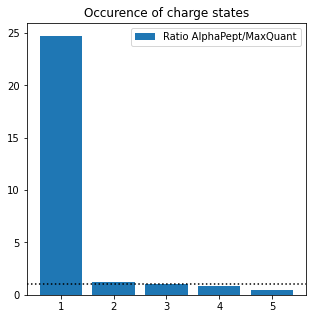

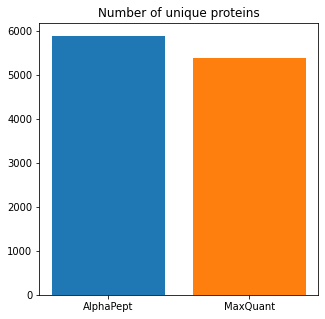

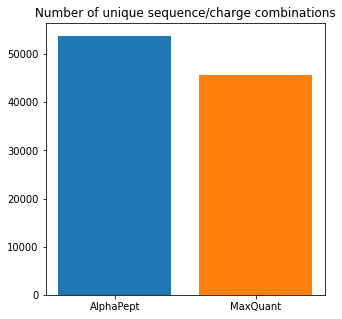

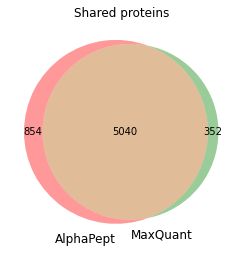

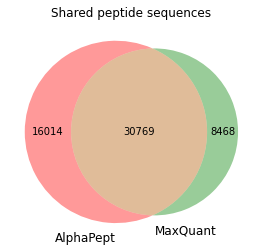

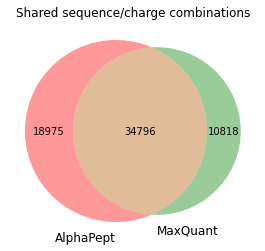

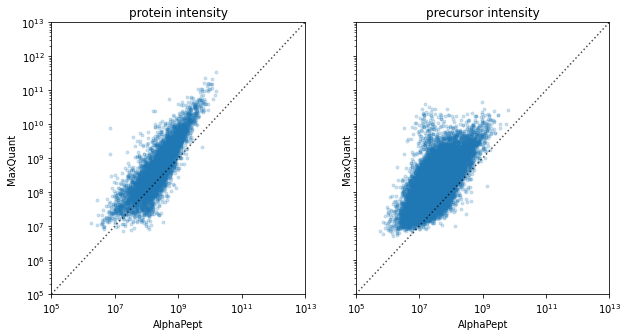

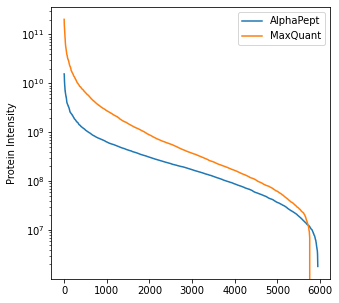

In [5]:
from test_helper import prepare_files, compare_field, compare_populations, compare_intensities, protein_rank
import os

df1, df2 = prepare_files(os.path.join(TEST_DIR,'results.hdf'), os.path.join(tmp_folder,'thermo_HeLa_evd.txt'))
for field in ['charge','protein','precursor']:
    compare_field(df1, df2, software_1, software_2, field)
    
for field in ['protein','sequence','precursor']:
    compare_populations(df1, df2, software_1, software_2, field)
    
compare_intensities(df1, df2,software_1, software_2)

protein_rank(df1, df2,software_1, software_2)

### Calling custom steps of the pipeline

Work with already processed results and call individual steps

--- ML ---
2021-08-29 20:56:22> 66,405 target (6,640 decoy) of 92148 PSMs. fdr 0.099992 for a cutoff of 20.50 (set fdr was 0.1)
2021-08-29 20:56:22> Training & cross-validation on 13958 targets and 13958 decoys
2021-08-29 20:56:42> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 50, 'clf__max_leaf_nodes': 250}
2021-08-29 20:56:42> The train accuracy was 0.940320962888666
2021-08-29 20:56:42> Testing on 55833 targets and 55833 decoys
2021-08-29 20:56:43> The test accuracy was 0.9129009725431196
2021-08-29 20:56:43> Top features {'y_hits': 0.2319737583464989, 'x_tandem': 0.2180344269625036, 'hits': 0.15877033815025082, 'matched_ion_fraction': 0.06907716603674435, 'n_ions': 0.049683626677540914, 'matched_int_ratio': 0.04488903334271132, 'matched_int': 0.029329703546062284, 'n_missed': 0.024353800372024597, 'b_hits': 0.020239574077106668, 'prec_offset_ppm': 0.01334522624059749, 'mz': 0.012163690975519498, 'prec_offset': 0.011176791432209444, 'dist': 0.010414

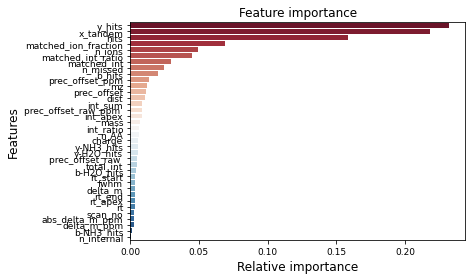

2021-08-29 20:56:43> Filter df with x_tandem score
2021-08-29 20:56:47> Global FDR on precursor
2021-08-29 20:56:47> 54,740 target (547 decoy) of 89221 PSMs. fdr 0.009993 for a cutoff of 0.74 (set fdr was 0.01)


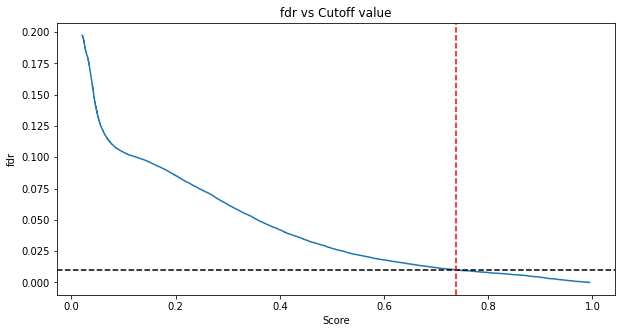

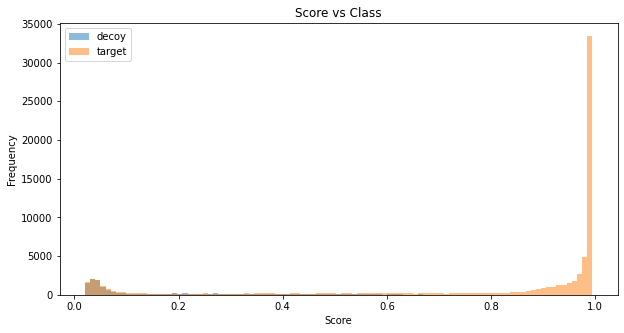

--- x! ---
2021-08-29 20:56:48> Filter df with x_tandem score
2021-08-29 20:56:49> Global FDR on precursor
2021-08-29 20:56:49> Last q_value 0.010 of dataset is smaller than fdr_level 0.010
2021-08-29 20:56:49> 54,740 target (547 decoy) of 55287 PSMs. fdr 0.009993 for a cutoff of 20.50 (set fdr was 0.01)


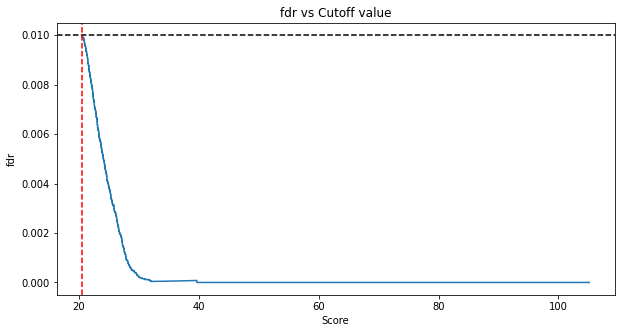

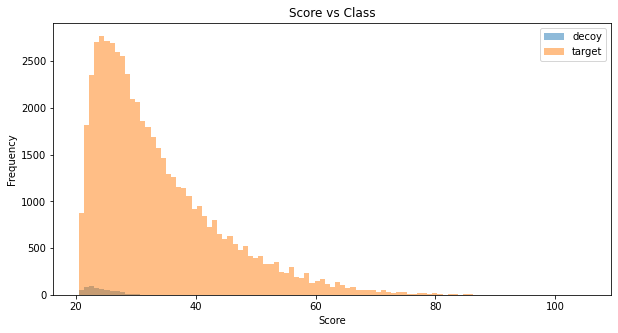

In [6]:
import alphapept.io
from alphapept.score import get_ML_features, filter_with_ML, filter_with_x_tandem, cut_global_fdr, train_RF

ms_file = alphapept.io.MS_Data_File(os.path.join(TEST_DIR,'thermo_HeLa.ms_data.hdf'))

df = ms_file.read(dataset_name='second_search')
df = get_ML_features(df)

print('--- ML ---')
cv, features = train_RF(df, plot=True)
df = filter_with_ML(df, cv, features = features)
df = cut_global_fdr(df, analyte_level='precursor',  plot=True)

print('--- x! ---')
df = filter_with_x_tandem(df)
df = cut_global_fdr(df, analyte_level='precursor',  plot=True)

# Quantification Test

This notebook will run `PXD006109` and `PXD010012` and compare the quantificaiton performance.

## PXD006109

In [7]:
%run -i ../test_ci.py $tmp_folder PXD006109 
#test_ci.main(runtype="PXD006109", new_files=False)

2021-08-29 20:56:51> Creating dir F:\develop\alphapept\sandbox\temp/test_temp.
2021-08-29 20:56:57> Using Python version for testing
2021-08-29 20:56:57> Logging to C:\Users\admin\alphapept\logs\log_20210829205657.txt.
2021-08-29 20:56:57> Platform information:
2021-08-29 20:56:57> system     - Windows
2021-08-29 20:56:57> release    - 10
2021-08-29 20:56:57> version    - 10.0.18363
2021-08-29 20:56:57> machine    - AMD64
2021-08-29 20:56:57> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-29 20:56:57> cpu count  - 24
2021-08-29 20:56:57> ram memory - 113.1/127.7 Gb (available/total)
2021-08-29 20:56:57> 
2021-08-29 20:56:57> Python information:
2021-08-29 20:56:57> SQLAlchemy       - 1.3.22
2021-08-29 20:56:57> alphapept        - 0.3.28
2021-08-29 20:56:57> biopython        - 1.78
2021-08-29 20:56:57> click            - 7.1.2
2021-08-29 20:56:57> comtypes         - 1.1.7
2021-08-29 20:56:57> fastcore         - 1.3.21
2021-08-29 20:56:57> h5py             - 3.1.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 20:56:58> FASTA contains 43,752 entries.



  2%|█▍                                                             | 0.022727272727272728/1 [01:05<47:11, 2897.10s/it]
  5%|██▊                                                            | 0.045454545454545456/1 [01:06<19:08, 1203.63s/it]
  7%|████▍                                                            | 0.06818181818181818/1 [01:08<10:49, 697.09s/it]
  9%|█████▉                                                           | 0.09090909090909091/1 [01:18<09:06, 601.56s/it]
 11%|███████▍                                                         | 0.11363636363636363/1 [01:30<08:25, 570.86s/it]
 14%|████████▊                                                        | 0.13636363636363635/1 [01:32<05:45, 400.58s/it]
 16%|██████████▌                                                       | 0.1590909090909091/1 [01:33<04:07, 293.85s/it]
 18%|███████████▊                                                     | 0.18181818181818182/1 [01:35<03:02, 223.19s/it]
  0%|                                  

2021-08-29 20:59:24> Digested 43,752 proteins and generated 6,163,992 spectra
2021-08-29 21:00:24> Database saved to F:\develop\alphapept\sandbox\temp\test_temp\database.hdf. Filesize of database is 2.33 GB


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:00:34> Processing 6 files for step raw_conversion
2021-08-29 21:00:34> AlphaPool was set to 24 processes. Setting max to 24.


 67%|████████████████████████████████████████████▋                      | 0.6666666666666666/1 [01:27<00:33, 99.60s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:02:02> Processing 6 files for step find_features
2021-08-29 21:02:02> Setting Process limit to 15
2021-08-29 21:02:02> AlphaPool was set to 15 processes. Setting max to 15.




 17%|██████████▋                                                     | 0.16666666666666666/1 [06:57<34:47, 2504.95s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:08:59> Starting first search.
2021-08-29 21:08:59> Processing 6 files for step search_db
2021-08-29 21:08:59> Searching. Setting Process limit to 15.
2021-08-29 21:08:59> AlphaPool was set to 15 processes. Setting max to 15.





 17%|██████████▊                                                      | 0.16666666666666666/1 [01:25<07:05, 510.48s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [09:59<00:00, 599.76s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [08:32<00:00, 512.22s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [13:43<00:00, 823.95s/it]


2021-08-29 21:10:51> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:10:52> Processing 6 files for step calibrate_hdf
2021-08-29 21:10:52> AlphaPool was set to 24 processes. Setting max to 24.


 67%|████████████████████████████████████████████▋                      | 0.6666666666666666/1 [00:16<00:06, 18.60s/it]
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:11:08> Starting second search with DB.
2021-08-29 21:11:08> Processing 6 files for step search_db
2021-08-29 21:11:08> Searching. Setting Process limit to 14.
2021-08-29 21:11:08> AlphaPool was set to 14 processes. Setting max to 14.



 17%|██████████▊                                                      | 0.16666666666666666/1 [00:40<03:24, 244.93s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [01:03<00:00, 63.24s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:57<00:00, 177.53s/it]


2021-08-29 21:12:12> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:12:13> Processing 6 files for step score_hdf
2021-08-29 21:12:13> AlphaPool was set to 24 processes. Setting max to 24.


100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [01:15<00:00, 75.54s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:27<00:00, 147.16s/it]


2021-08-29 21:13:40> Total deviation before calibration {'mz': 4.019596522107315e-06, 'rt': 7.590437848484874}
2021-08-29 21:13:40> Mean deviation before calibration {'mz': 2.6797310147382103e-07, 'rt': 0.5060291898989916}
2021-08-29 21:13:40> Solving equation system
2021-08-29 21:13:40> Regression score is 0.9998114139574876
2021-08-29 21:13:40> Solving equation system complete.
2021-08-29 21:13:40> Applying offset
2021-08-29 21:13:40> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD006109_HeLa12_1.ms_data.hdf - peptide_fdr.
2021-08-29 21:13:40> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD006109_HeLa12_1.ms_data.hdf - feature_table.
2021-08-29 21:13:40> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD006109_HeLa12_2.ms_data.hdf - peptide_fdr.
2021-08-29 21:13:41> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD006109_HeLa12_2.ms_data.hdf - feature_table.
2021-08-29 21:13:41> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD006109_HeLa12_3.ms_data.hdf -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:13:54> Fasta dict with length 43,752, Pept dict with length 6,163,998
2021-08-29 21:13:54> Extracting protein groups.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-08-29 21:13:56> A total of 59,287 unique and 11,883 shared peptides.
2021-08-29 21:14:01> A total of 2059 ambigious proteins
2021-08-29 21:14:02> A total of 1,775 unique and 211 shared peptides.
2021-08-29 21:14:02> A total of 198 ambigious proteins
2021-08-29 21:14:04> Global FDR on protein_group
2021-08-29 21:14:04> 7,002 target (70 decoy) of 10730 PSMs. fdr 0.009997 for a cutoff of 0.90 (set fdr was 0.01)
2021-08-29 21:14:06> FDR on proteins complete. For 0.01 FDR found 258,681 targets and 189 decoys. A total of 7,072 proteins found.
2021-08-29 21:14:18> Saving complete.
2021-08-29 21:14:18> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx'],
      dtype='object')]

  pytables.to_hdf(


2021-08-29 21:14:19> Delayed Normalization.
2021-08-29 21:14:20> Setting minimum occurence to 5.0
2021-08-29 21:14:24> Complete. 
2021-08-29 21:14:24> Starting profile extraction.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx'],
      dtype='object')]

  pytables.to_hdf(
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:14:25> Preparing protein table for parallel processing.


 20%|████████████▉                                                     | 0.19680429864253393/1 [00:04<00:16, 20.65s/it]

2021-08-29 21:14:29> Starting protein extraction for 7072 proteins.
2021-08-29 21:14:29> AlphaPool was set to 24 processes. Setting max to 24.


100%|█████████████████████████████████████████████████████████████████▉| 0.9997737556561086/1 [03:05<00:00, 199.82s/it]

2021-08-29 21:17:36> LFQ complete.
2021-08-29 21:17:36> Extracting protein_summary
2021-08-29 21:17:37> Saved protein_summary of length 7,072 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-29 21:17:37> Exporting as csv.
2021-08-29 21:17:49> Saved df of length 258,870 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-29 21:17:55> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-29 21:17:55> Analysis complete.


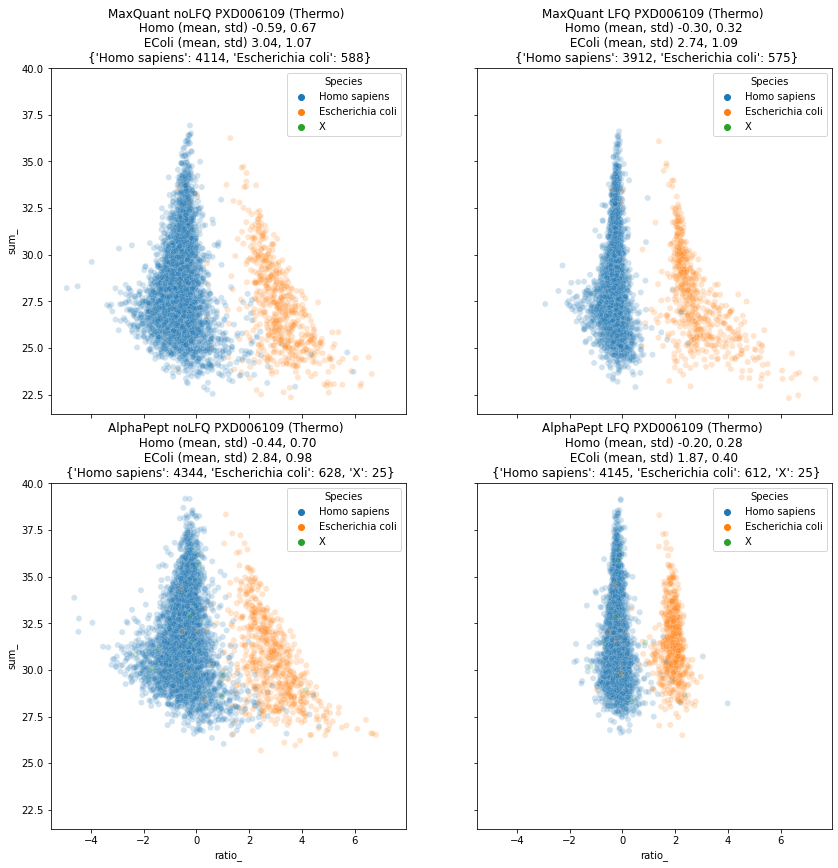

In [8]:
from test_helper import get_plot_df, add_species_column
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD006109_ref.txt'), sep='\t') 
no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in ref[["Reverse","Potential contaminant"]].values]
ref = ref[no_rev_cont]
add_species_column(ref)
ref['Species'] = ref['Species'].replace(np.nan, "X")

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Shotgun_02-01_{i}" for i in range(1,4)]
    ratio_columns = [f"{x}ntensity Shotgun_12-01_{i}" for i in range(1,4)]

    id_ = 'MaxQuant ' +_+' PXD006109 (Thermo)'
    get_plot_df(ref, base_columns, ratio_columns, axes[0,j], id_)


path = os.path.join(TEST_DIR, 'results.hdf') #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')
ref.columns = [os.path.split(_)[1].replace('.ms_data.hdf','') for _ in ref.columns]


species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD006109_HeLa2_{i}{x}" for i in range(1,4)]
    ratio_columns = [f"PXD006109_HeLa12_{i}{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD006109 (Thermo)'
    get_plot_df(ref, base_columns, ratio_columns, axes[1,j], id_)

plt.show()

## CV plot

C:\Users\admin\AppData\Local\Temp/ipykernel_21348/3701149517.py:22: RuntimeWarning: invalid value encountered in true_divide
  cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\admin\AppData\Local\Temp/ipykernel_21348/3701149517.py:52: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)


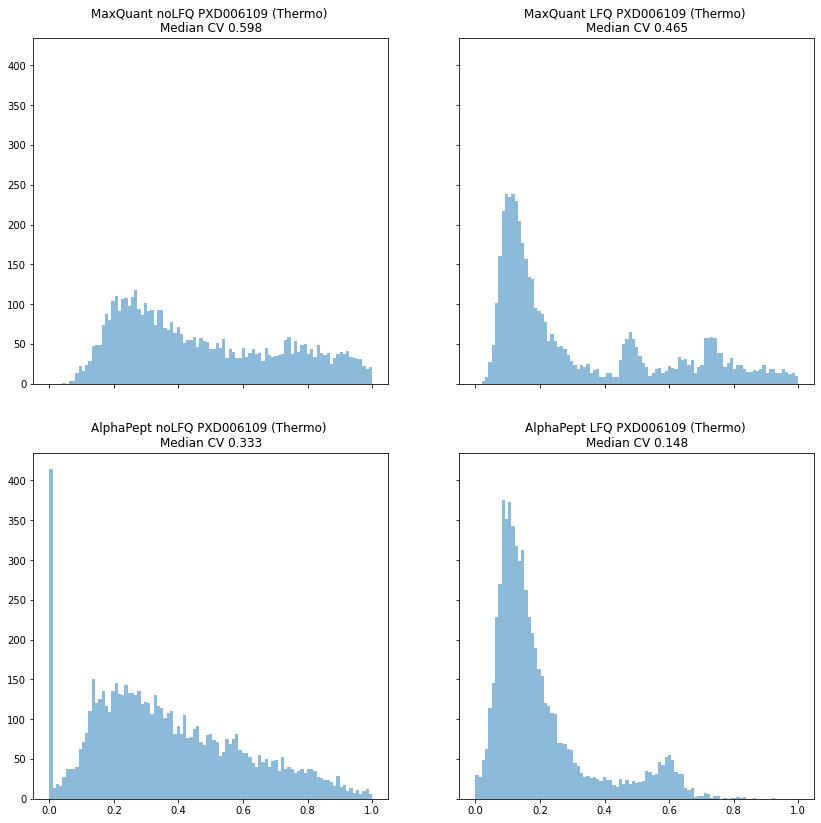

In [9]:
bins = np.linspace(0,1,100)

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD006109_ref.txt'), sep='\t') 
no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in ref[["Reverse","Potential contaminant"]].values]
ref = ref[no_rev_cont]
add_species_column(ref)
ref['Species'] = ref['Species'].replace(np.nan, "X")

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Shotgun_02-01_{i}" for i in range(1,4)]
    ratio_columns = [f"{x}ntensity Shotgun_12-01_{i}" for i in range(1,4)]

    id_ = 'MaxQuant ' +_+' PXD006109 (Thermo)'
    
    cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)

    axes[0,j].hist(cv, bins = bins, label = id_, alpha = 0.5)
    axes[0,j].set_title(f'{id_} \nMedian CV {np.nanmedian(cv):.3f}')

path = os.path.join(TEST_DIR,'results.hdf') #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')
ref.columns = [os.path.split(_)[1].replace('.ms_data.hdf','') for _ in ref.columns]

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD006109_HeLa2_{i}{x}" for i in range(1,4)]
    ratio_columns = [f"PXD006109_HeLa12_{i}{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD006109 (Thermo)'
    cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)

    axes[1,j].hist(cv, bins = bins, label = id_, alpha = 0.5)
    axes[1,j].set_title(f'{id_} \nMedian CV {np.nanmedian(cv):.3f}')

plt.show()

## Algorithm Test

Test performance of LFQ algorithm on MaxQuant evidence file.

In [10]:
try: 
    import ipywidgets
except ModuleNotFoundError:
    !pip install ipywidgets

2021-08-29 21:17:59> Loading files
2021-08-29 21:18:01> A total of 6 files.
2021-08-29 21:18:11> A total of 6,854 proteins.


  0%|                                                                                            | 0/1 [04:18<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [03:48<00:00, 228.04s/it]


2021-08-29 21:18:23> Setting minimum occurence to 6.0
2021-08-29 21:18:26> Preparing protein table for parallel processing.
2021-08-29 21:18:29> Starting protein extraction for 6854 proteins.
2021-08-29 21:18:29> AlphaPool was set to 24 processes. Setting max to 24.


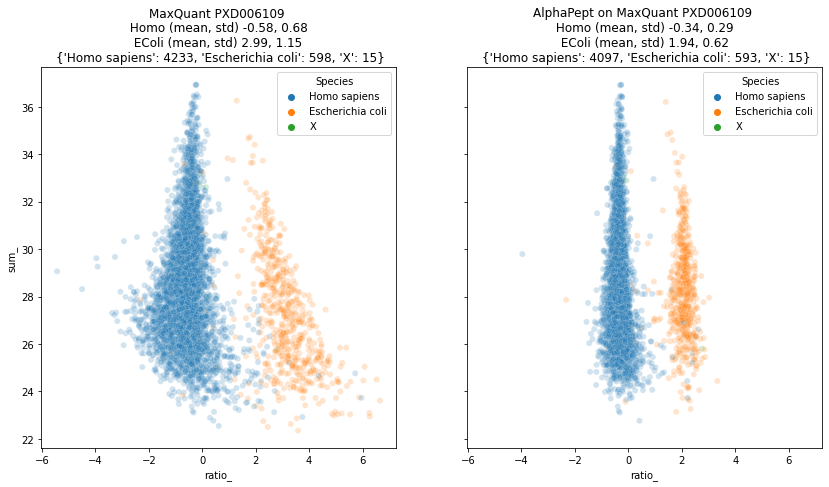

In [11]:
from alphapept.quantification import protein_profile_parallel_mq
import test_helper
import pandas as pd


evidence_path = os.path.join(tmp_folder,'PXD006109_ref_evd.txt')
protein_group_path = os.path.join(tmp_folder,'PXD006109_ref.txt')

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

ref = pd.read_csv(protein_group_path, sep='\t')
test_helper.add_species_column(ref)
species_dict = pd.Series(ref['Species'].values, index=ref['Protein IDs']).to_dict()
pt['Species'] = [species_dict[_] for _ in pt.index]


pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

test_id = 'PXD006109'

fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

ids = [f'{software_2} {test_id}', f'{software_1} on {software_2} {test_id}']

for i, ds in enumerate([pre_lfq, lfq]):

    base_columns = [_ for _ in ds if 'HeLa2' in _]
    ratio_columns = [_ for _ in ds if 'HeLa12' in _]
    test_helper.get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i])

## Normalization Checks

### Check only the delayed normalization part

2021-08-29 21:21:03> Setting minimum occurence to 4.0
2021-08-29 21:21:04> Setting minimum occurence to 4.0


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\panda

2021-08-29 21:21:05> Setting minimum occurence to 4.0
2021-08-29 21:21:06> Setting minimum occurence to 4.0
2021-08-29 21:21:07> Setting minimum occurence to 4.0
2021-08-29 21:21:08> Setting minimum occurence to 4.0
2021-08-29 21:21:09> Setting minimum occurence to 4.0


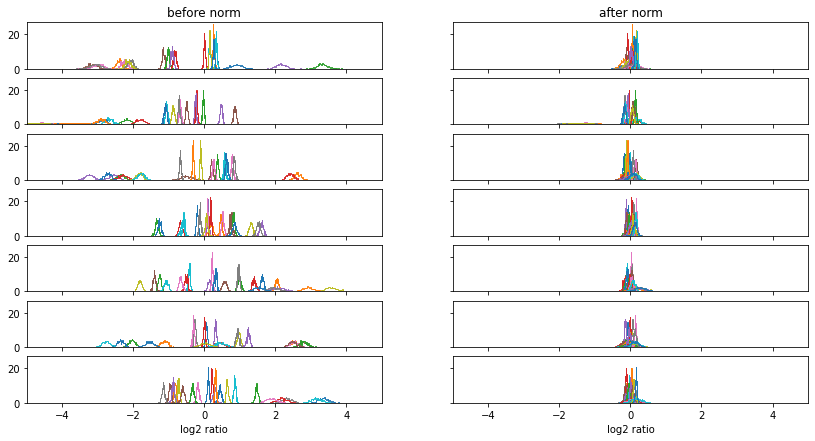

In [12]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import test_helper
from alphapept.quantification import delayed_normalization


def visualize_normalization(simulated_df, axis, value = "Intensity",show_per_colpair = True):
    
    shortnames = df["filename"].unique()
    df["namefrac"] = [f"{n}_{f}" for n,f in zip(simulated_df["filename"], simulated_df["fraction"])]
    simulated_reformat = pd.pivot_table(simulated_df, values=value, columns="namefrac" ,index=["protein_group", "precursor" ])
    
    for namepair in itertools.combinations(shortnames, 2):
        cols1 = [x for x in simulated_reformat.columns if namepair[0] in x]
        cols2 = [x for x in simulated_reformat.columns if namepair[1] in x]
        for colpair in itertools.product(cols1, cols2):
            fcs = np.log2(simulated_reformat[colpair[0]]) - np.log2(simulated_reformat[colpair[1]])
            axis.hist(fcs, histtype = 'step', bins = 50, label = f"{colpair}", density = True)
            axis.set_xlim(-5, 5)

samplenames = ["A1", "A2","B1"]
fractions = [3, 2, 3]

ntests = 7
fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize=(14,7), sharex=True,sharey=True)
count_axis = 0
axes[0][0].set_title("before norm")
axes[-1][0].set_xlabel('log2 ratio')
axes[0][1].set_title("after norm")
axes[-1][1].set_xlabel('log2 ratio')
for _ in range(ntests):
    df = test_helper.simulate_biased_peptides(5000, samplenames, fractions)
    df_del, normed = delayed_normalization(df, field ='Intensity')
    visualize_normalization(df, axes[count_axis][0],value = "Intensity", show_per_colpair = False)
    visualize_normalization(df_del, axes[count_axis][1],value = "Intensity_dn", show_per_colpair = False)
    count_axis+=1

### Check delayed normalization + protein intensity estimation

2021-08-29 21:21:10> Setting minimum occurence to 3.0
2021-08-29 21:21:12> Preparing protein table for parallel processing.
2021-08-29 21:21:13> Starting protein extraction for 3327 proteins.
2021-08-29 21:21:13> AlphaPool was set to 24 processes. Setting max to 24.
2021-08-29 21:21:45> Preparing protein table for parallel processing.
2021-08-29 21:21:46> Starting protein extraction for 3327 proteins.
2021-08-29 21:21:46> AlphaPool was set to 24 processes. Setting max to 24.


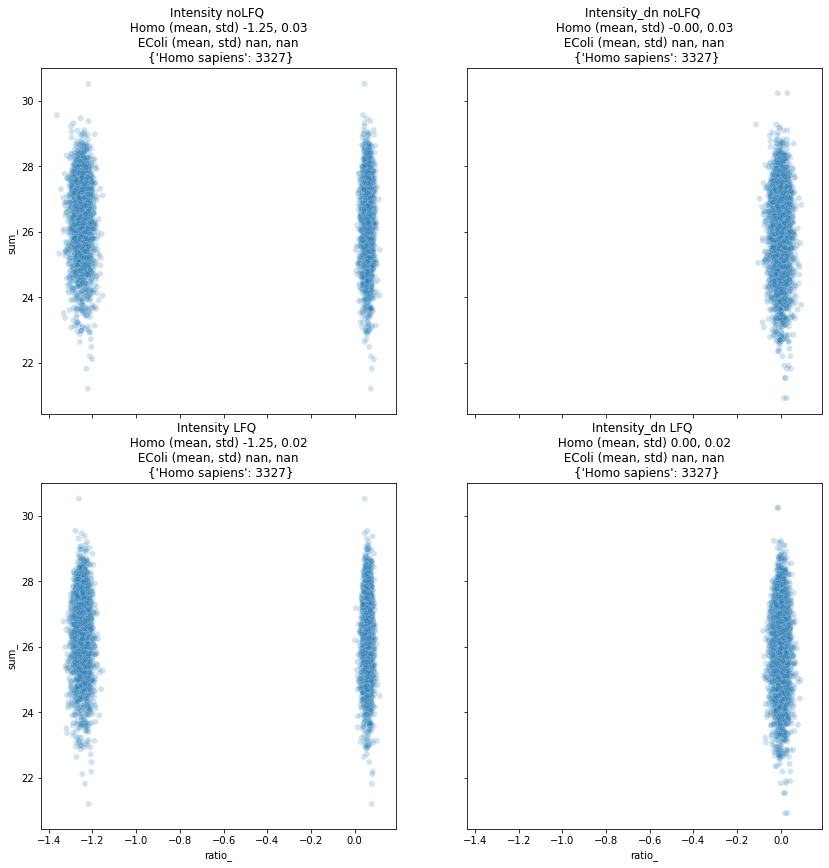

In [13]:
from alphapept.quantification import delayed_normalization, protein_profile_parallel
import test_helper
import pandas as pd
import matplotlib.pyplot as plt
import itertools

samplenames = ["A1", "A2", "B1"]
fractions = [1, 1, 1]
test_id = 'PXD006109'

df = test_helper.simulate_biased_peptides(20000, samplenames, fractions)
df, normed = delayed_normalization(df, field ='Intensity')

fields = ['Intensity', 'Intensity_dn']
tests = ['noLFQ', 'LFQ']

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True, sharey=True)

for j, field in  enumerate(fields):
    
    pt = protein_profile_parallel(df, minimum_ratios=1, field=field)
    pt['Species'] = ["Homo sapiens" for x in range(len(pt.index))]
    
    pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
    lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]
    
    for i, cols in enumerate([pre_lfq, lfq]):
        
        ax = axes[i, j]
        samplepairs = itertools.product([x for x in cols if "A" in x ], [x for x in cols if "B" in x ])
        
        for pair in samplepairs:
            
            base_columns = [pair[0]]
            ratio_columns = [pair[1]]
            test_helper.get_plot_df(pt, base_columns, ratio_columns, ax, f"{fields[j]} {tests[i]}", valid_filter = False)
            
            ax.get_legend().remove()
 
plt.show()

### Bruker HeLa

In [14]:
%run -i ../test_ci.py $tmp_folder bruker_hela

2021-08-29 21:22:17> Creating dir F:\develop\alphapept\sandbox\temp/test_temp.
2021-08-29 21:22:20> Using Python version for testing
2021-08-29 21:22:20> Logging to C:\Users\admin\alphapept\logs\log_20210829212220.txt.
2021-08-29 21:22:20> Platform information:
2021-08-29 21:22:20> system     - Windows
2021-08-29 21:22:20> release    - 10
2021-08-29 21:22:20> version    - 10.0.18363
2021-08-29 21:22:20> machine    - AMD64
2021-08-29 21:22:20> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-29 21:22:20> cpu count  - 24
2021-08-29 21:22:20> ram memory - 117.1/127.7 Gb (available/total)
2021-08-29 21:22:20> 
2021-08-29 21:22:21> Python information:
2021-08-29 21:22:21> SQLAlchemy       - 1.3.22
2021-08-29 21:22:21> alphapept        - 0.3.28
2021-08-29 21:22:21> biopython        - 1.78
2021-08-29 21:22:21> click            - 7.1.2
2021-08-29 21:22:21> comtypes         - 1.1.7
2021-08-29 21:22:21> fastcore         - 1.3.21
2021-08-29 21:22:21> h5py             - 3.1.

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:22:21> FASTA contains 36,789 entries.


100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:24<00:00, 53.00s/it]

2021-08-29 21:25:04> Digested 36,789 proteins and generated 9,107,982 spectra
2021-08-29 21:26:31> Database saved to F:\develop\alphapept\sandbox\temp\test_temp\database.hdf. Filesize of database is 3.42 GB



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:26:47> Processing 1 files for step raw_conversion
2021-08-29 21:26:47> File F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa has extension .d - converting from Bruker.
2021-08-29 21:59:00> File conversion complete. Extracted 299,728 precursors.
2021-08-29 21:59:03> File conversion of file F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.d complete.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 21:59:03> Processing 1 files for step find_features
2021-08-29 21:59:03> No *.hdf file with features found for F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.ms_data.hdf. Adding to feature finding list.
2021-08-29 21:59:04> Feature finding on F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.d
2021-08-29 21:59:04> Using Windows FF
2021-08-29 21:59:05> TopLevelUffWorkflow: Initializing 4d Feature Finder Workflow for lc-timstof data
2021-08-29 21:59:05> bdal.uff.TopLevelUffWorkflow: This is Universal Feature Finder 3.13.1.0
2021-08-29 21:59:05> 
2021-08-29 21:59:05> bdal.uff.cmdline: Parameters for ParameterSet path '':
2021-08-29 21:59:05> 
2021-08-29 21:59:05>  directory containing the data to be processed." , "required":true , "hidden":false , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":null , "value":"F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.d"}
2021-08-29 21:59:05> 
2021-08-2

2021-08-29 21:59:05> 
2021-08-29 21:59:05> "Parameter for writing raw msms peaks of non-deisotoped peaks if writeAllRawPeaks is false." , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":150}
2021-08-29 21:59:05> 
2021-08-29 21:59:05>  non-deconvoluted peaks are filled up." , "required":false , "hidden":true , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":"[topN,threshold] (class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >)" , "value":"topN"}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> , all raw peaks are written. Otherwise, only deisotoped peaks are written" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> ':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> :
2021-08-29 21:59:05> 
2021-08-29 21:59:05> c":"intensity threshold for matching calibrant peaks" 

2021-08-29 21:59:05> 
2021-08-29 21:59:05> ectors with group ids of reference peaks, for calibration-segment calibration" , "required":false , "hidden":false , "type":"class std::vector<class std::vector<int,class std::allocator<int> >,class std::allocator<class std::vector<int,class std::allocator<int> > > >" , "constraint":null , "value":unprintable type}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> :"end (RT) of the calibration segment" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1e+22}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> c":"begin (RT) of the calibration segment" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> mum intensity of a calibrant" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1e+22}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> lag indicating which algorithm to use: false = use calibration-segment, true = do not u

2021-08-29 21:59:05> 
2021-08-29 21:59:05> value for range to read metadata / recalibrate masses in" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05>  "desc":"Lower RT value for range to look for mobility calibrants" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> .Calibration.ReadTimsCalibrants':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> Ms.Calibration.WriteCalibration':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> "vector of CCS values of reference peaks for mobility calibration" , "required":false , "hidden":false , "type":"class std::vector<double,class std::allocator<double> >" , "constraint":null , "value":[]}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> .Calibration.WriteCalibration':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> Ms.ClusterDeisotoping':
2021-08-29 21:59:05> 
2021-0

2021-08-29 21:59:05> 
2021-08-29 21:59:05> sc":"assignment precondition: if true, the M/Z center of the isolation window must lie within the feature interval" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> raction of isotope pattern which must be covered (starting from the largest peaks)" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0.95}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> l molecules: path to file with table: 6 x M/Z and 6 isotope intensities" , "required":false , "hidden":false , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":null , "value":"isotopePatterns3.txt"}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> e threshold for incorporation of non-essential isotopes into feature. if <= 0, not used (abs. threshold maxIsotopePatternError used)." , "required":false , "hidden":false , "type":"double

2021-08-29 21:59:05> 
2021-08-29 21:59:05> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> " , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> rue, all peaks for positions [-1, maxIsotopes-1] (with pos. 0 first isotope of feature) are reported" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> fraction of the maximum intensity is considered as not saturated (for bigger intensities we don't know)" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0.8}
2021-08-29 21:59:05

2021-08-29 21:59:05> required":false , "hidden":false , "type":"double" , "constraint":null , "value":1}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0.03}
2021-08-29 21:59:05> 
2021-08-29 21:59:05>  , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":2}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> ed":false , "hidden":false , "type":"double" , "constraint":null , "value":0.014}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> d":false , "hidden":false , "type":"double" , "constraint":null , "value":0.01}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> d":false , "hidden":false , "type":"double" , "constraint":null , "value":4}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> " , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":3.5}
2021-08-

2021-08-29 21:59:05> 
2021-08-29 21:59:05>  sqlite result file '<shortFilename>.features'" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":true}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> aw peaks for each cluster are written" , "required":false , "hidden":true , "type":"bool" , "constraint":null , "value":false}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> .IsotopeClustersOutput':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> Ms.PrecursorInfoSource':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> value for read range" , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":1e+22}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> value for read range" , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":0}
2021-08-29 21:59:05> 
2021-08-29 21:59:05> .PrecursorInfoSource':
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> Ms.ReadTimsData':
2021-08-29 21:59:05> 
2021-08-29 21:59

2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 00000
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 0000
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 00
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 
2021-08-29 21:59:05> 0000.000000
2021-08-29 21:59:05> 
2021-08-29 21:59:05> e
2021-08-29 21:59:05> th.enableRecalibration=true
2021

2021-08-29 21:59:06> false
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 10
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> alse
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> ing=20
2021-08-29 21:59:06> 00000
2021-08-29 21:59:06> or=2.000000
2021-08-29 21:59:06> 300000
2021-08-29 21:59:06> 0
2021-08-29 21:59:06> 50000
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> .000000
2021-08-29 21:59:06> 
2021-08-29 21:59:06> 
2021-08-29 21:59:06> ters=<unprintable type>
2021-08-29 21:59:06> ue
2021-08-29 21:59:06> eaks=false
2021-08-29 21:59:06> nds=10000000000000000000000.000000
2021-08-29 21:59:06> nds=0.000000
2021-08-29 21:59:06> meNrTolerance=2
2021-08-29 21:59:06> imalFrequency=20
2021-08-29 21:59:06> nNrTolerance=20
2021-08-29 21:59:06> lerance=3
2021-08-29 21:59:06> eClustering"
2021-08-29 21:59:06> ue
2021-0

2021-08-29 22:22:39> bdal.algorithm.LcmsClusterDeisotoping: 2052951 clusters after splitting (if active).
2021-08-29 22:22:39> bdal.algorithm.LcmsClusterDeisotoping:  min/max apex intensity: 34.7222/1.31159e+06
2021-08-29 22:22:48> bdal.algorithm.PerioTab.InitPerioTabStream: User-defined periodic table extension is empty or file could not be opened. Proceeding with standard elements.
2021-08-29 22:22:48> bdal.algorithm.LcmsClusterDeisotoping: correlation threshold: 10623.9
2021-08-29 22:22:48> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0% (1/2052951)
2021-08-29 22:22:49> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0.487104% (10001/2052951)
2021-08-29 22:22:50> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0.974207% (20001/2052951)
2021-08-29 22:22:52> bdal.algorithm.LcmsClusterDeisotoping: Progress: 1.46131% (30001/2052951)
2021-08-29 22:22:53> bdal.algorithm.LcmsClusterDeisotoping: Progress: 1.94841% (40001/2052951)
2021-08-29 22:22:54> bdal.algorithm.LcmsClusterDeisotop

2021-08-29 22:24:15> bdal.algorithm.LcmsClusterDeisotoping: Progress: 39.4554% (810001/2052951)
2021-08-29 22:24:16> bdal.algorithm.LcmsClusterDeisotoping: Progress: 39.9425% (820001/2052951)
2021-08-29 22:24:17> bdal.algorithm.LcmsClusterDeisotoping: Progress: 40.4296% (830001/2052951)
2021-08-29 22:24:18> bdal.algorithm.LcmsClusterDeisotoping: Progress: 40.9167% (840001/2052951)
2021-08-29 22:24:19> bdal.algorithm.LcmsClusterDeisotoping: Progress: 41.4038% (850001/2052951)
2021-08-29 22:24:20> bdal.algorithm.LcmsClusterDeisotoping: Progress: 41.8909% (860001/2052951)
2021-08-29 22:24:21> bdal.algorithm.LcmsClusterDeisotoping: Progress: 42.378% (870001/2052951)
2021-08-29 22:24:21> bdal.algorithm.LcmsClusterDeisotoping: Progress: 42.8651% (880001/2052951)
2021-08-29 22:24:22> bdal.algorithm.LcmsClusterDeisotoping: Progress: 43.3522% (890001/2052951)
2021-08-29 22:24:23> bdal.algorithm.LcmsClusterDeisotoping: Progress: 43.8393% (900001/2052951)
2021-08-29 22:24:24> bdal.algorithm.LcmsC

2021-08-29 22:25:20> bdal.algorithm.LcmsClusterDeisotoping: Progress: 80.8592% (1660001/2052951)
2021-08-29 22:25:21> bdal.algorithm.LcmsClusterDeisotoping: Progress: 81.3463% (1670001/2052951)
2021-08-29 22:25:21> bdal.algorithm.LcmsClusterDeisotoping: Progress: 81.8334% (1680001/2052951)
2021-08-29 22:25:22> bdal.algorithm.LcmsClusterDeisotoping: Progress: 82.3205% (1690001/2052951)
2021-08-29 22:25:23> bdal.algorithm.LcmsClusterDeisotoping: Progress: 82.8076% (1700001/2052951)
2021-08-29 22:25:23> bdal.algorithm.LcmsClusterDeisotoping: Progress: 83.2947% (1710001/2052951)
2021-08-29 22:25:24> bdal.algorithm.LcmsClusterDeisotoping: Progress: 83.7818% (1720001/2052951)
2021-08-29 22:25:25> bdal.algorithm.LcmsClusterDeisotoping: Progress: 84.2689% (1730001/2052951)
2021-08-29 22:25:25> bdal.algorithm.LcmsClusterDeisotoping: Progress: 84.756% (1740001/2052951)
2021-08-29 22:25:26> bdal.algorithm.LcmsClusterDeisotoping: Progress: 85.2431% (1750001/2052951)
2021-08-29 22:25:27> bdal.algor




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:03:28> Starting first search.
2021-08-29 23:03:28> Processing 1 files for step search_db
2021-08-29 23:03:29> Calibrating fragments


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-29 23:03:59> Performing search on 664,992 query and 9,107,982 db entries with frag_tol = 30.00 and prec_tol = 30.00.
2021-08-29 23:04:45> Found 673,970 psms.
2021-08-29 23:04:46> Extracting columns for scoring.


100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [1:42:54<00:00, 6174.07s/it]
  0%|                                                                                          | 0/1 [1:06:11<?, ?it/s]


2021-08-29 23:06:32> Extracted columns from 673,970 spectra.
2021-08-29 23:06:33> Saving first_search results to F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.ms_data.hdf
2021-08-29 23:06:35> Search of file F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.d complete.
2021-08-29 23:07:08> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:07:09> Processing 1 files for step calibrate_hdf
2021-08-29 23:07:10> Scoring using X-Tandem
2021-08-29 23:07:12> 66,268 target (662 decoy) of 115809 PSMs. fdr 0.009990 for a cutoff of 17.77 (set fdr was 0.01)
2021-08-29 23:07:20> Calibration of file F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.ms_data.hdf complete.
2021-08-29 23:07:20> Calibrating fragments
2021-08-29 23:07:22> Median fragment offset -5.65 - std 14.78 ppm - mad 10.17 ppm



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:07:23> Starting second search with DB.
2021-08-29 23:07:23> Processing 1 files for step search_db
2021-08-29 23:07:23> Found calibrated prec_tol with value 11.24
2021-08-29 23:07:23> Found calibrated frag_tol with value 30.50
2021-08-29 23:07:28> Performing search on 664,992 query and 9,107,982 db entries with frag_tol = 30.50 and prec_tol = 11.24.


  0%|                                                                                            | 0/1 [00:19<?, ?it/s]


2021-08-29 23:07:53> Found 498,392 psms.
2021-08-29 23:07:53> Extracting columns for scoring.


  0%|                                                                                            | 0/1 [04:48<?, ?it/s]


2021-08-29 23:09:08> Extracted columns from 498,392 spectra.
2021-08-29 23:09:09> Saving second_search results to F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.ms_data.hdf
2021-08-29 23:09:11> Search of file F:\develop\alphapept\sandbox\temp/test_temp\bruker_HeLa.d complete.
2021-08-29 23:09:42> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:09:43> Processing 1 files for step score_hdf
2021-08-29 23:09:44> Found second search psms for scoring.
2021-08-29 23:09:52> 89,495 target (8,949 decoy) of 109550 PSMs. fdr 0.099994 for a cutoff of 12.94 (set fdr was 0.1)
2021-08-29 23:09:53> Training & cross-validation on 18518 targets and 18517 decoys
2021-08-29 23:10:25> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 50, 'clf__max_leaf_nodes': 250}
2021-08-29 23:10:25> The train accuracy was 0.9360874848116646
2021-08-29 23:10:25> Testing on 74070 targets and 74071 decoys
2021-08-29 23:10:26> The test accuracy was 0.9219392335680197
2021-08-29 23:10:26> Top features {'hits': 0.21997761857941034, 'y_hits': 0.19845722954428485, 'x_tandem': 0.15846581414051328, 'matched_int_ratio': 0.0573255406012805, 'n_ions': 0.0504495299433258, 'total_int': 0.048965709227315, 'matched_ion_fraction': 0.042877208442484056, 'dist': 0.029580756299303082, 'n_missed': 0.02615786526669479, 'int_sum': 0.0229243



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:11:00> Fasta dict with length 36,789, Pept dict with length 9,107,988
2021-08-29 23:11:00> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:11:01> A total of 61,129 unique and 3,423 shared peptides.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-08-29 23:11:02> A total of 908 ambigious proteins
2021-08-29 23:11:02> A total of 716 unique and 34 shared peptides.
2021-08-29 23:11:03> A total of 33 ambigious proteins
2021-08-29 23:11:03> Global FDR on protein_group
2021-08-29 23:11:03> 6,769 target (67 decoy) of 8290 PSMs. fdr 0.009898 for a cutoff of 0.90 (set fdr was 0.01)
2021-08-29 23:11:03> FDR on proteins complete. For 0.01 FDR found 74,933 targets and 71 decoys. A total of 6,836 proteins found.
2021-08-29 23:11:07> Saving complete.
2021-08-29 23:11:07> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx'],
      dtype='object')]

  pytables.to_hdf(


2021-08-29 23:11:07> Complete. 
2021-08-29 23:11:07> Starting profile extraction.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]

2021-08-29 23:11:08> LFQ complete.
2021-08-29 23:11:08> Extracting protein_summary
2021-08-29 23:11:08> Saved protein_summary of length 6,836 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-29 23:11:08> Exporting as csv.
2021-08-29 23:11:11> Saved df of length 75,004 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-29 23:11:14> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-29 23:11:14> Analysis complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


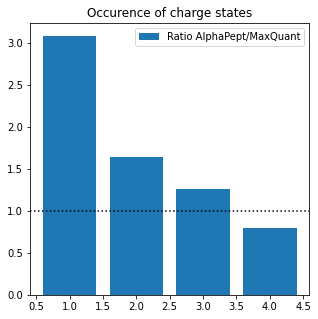

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.97s/it]


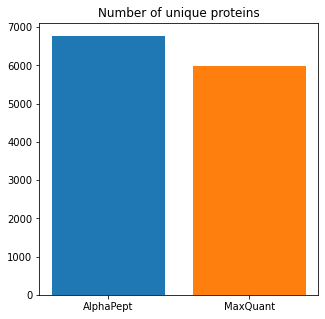

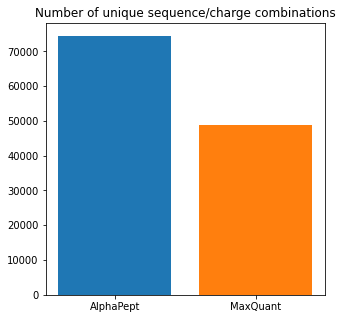

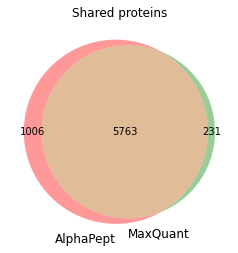

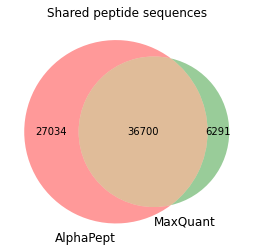

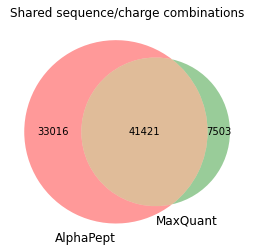

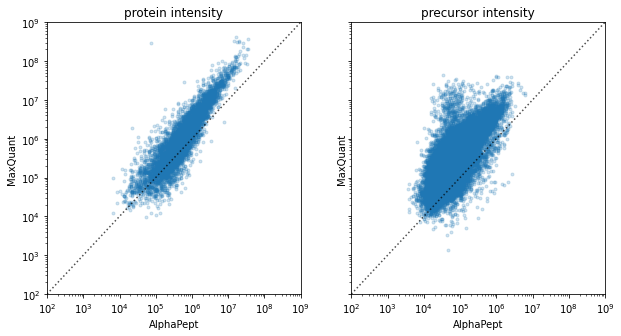

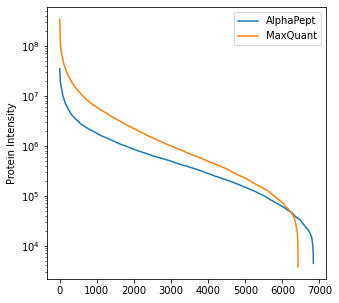

In [15]:
from test_helper import prepare_files, compare_field, compare_populations, compare_intensities, protein_rank

df1, df2 = prepare_files(os.path.join(TEST_DIR, "results.hdf"), os.path.join(tmp_folder,'bruker_HeLa_evd.txt'))
for field in ['charge','protein','precursor']:
    compare_field(df1, df2, software_1, software_2, field)
    
for field in ['protein','sequence','precursor']:
    compare_populations(df1, df2, software_1, software_2, field)
    
compare_intensities(df1, df2,software_1, software_2)

protein_rank(df1, df2,software_1, software_2)

## PXD010012

In [16]:
%run -i ../test_ci.py $tmp_folder PXD010012

2021-08-29 23:11:20> Creating dir F:\develop\alphapept\sandbox\temp/test_temp.
2021-08-29 23:13:13> Using Python version for testing
2021-08-29 23:13:13> Logging to C:\Users\admin\alphapept\logs\log_20210829231313.txt.
2021-08-29 23:13:13> Platform information:
2021-08-29 23:13:13> system     - Windows
2021-08-29 23:13:13> release    - 10
2021-08-29 23:13:13> version    - 10.0.18363
2021-08-29 23:13:13> machine    - AMD64
2021-08-29 23:13:13> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-29 23:13:13> cpu count  - 24
2021-08-29 23:13:13> ram memory - 112.5/127.7 Gb (available/total)
2021-08-29 23:13:13> 
2021-08-29 23:13:13> Python information:
2021-08-29 23:13:13> SQLAlchemy       - 1.3.22
2021-08-29 23:13:13> alphapept        - 0.3.28
2021-08-29 23:13:13> biopython        - 1.78
2021-08-29 23:13:13> click            - 7.1.2
2021-08-29 23:13:13> comtypes         - 1.1.7
2021-08-29 23:13:13> fastcore         - 1.3.21
2021-08-29 23:13:13> h5py             - 3.1.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:13:14> FASTA contains 43,752 entries.




  2%|█▍                                                             | 0.022727272727272728/1 [01:13<52:31, 3224.51s/it]

  5%|██▊                                                            | 0.045454545454545456/1 [01:14<21:45, 1368.13s/it]

  7%|████▍                                                            | 0.06818181818181818/1 [01:20<13:25, 864.73s/it]

  9%|█████▉                                                           | 0.09090909090909091/1 [01:26<09:23, 620.22s/it]

 11%|███████▍                                                         | 0.11363636363636363/1 [01:31<07:09, 484.25s/it]

  0%|                                                                                            | 0/1 [03:48<?, ?it/s]


 16%|██████████▌                                                       | 0.1590909090909091/1 [01:36<03:44, 267.52s/it]

 18%|███████████▊                                                     | 0.18181818181818182/1 [01:37<02:48, 206.45s/it]

 20%|█████████████▎          

2021-08-29 23:15:42> Digested 43,752 proteins and generated 6,163,992 spectra
2021-08-29 23:16:41> Database saved to F:\develop\alphapept\sandbox\temp\test_temp\database.hdf. Filesize of database is 2.33 GB


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:16:52> Processing 10 files for step raw_conversion
2021-08-29 23:16:52> AlphaPool was set to 24 processes. Setting max to 24.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [41:49<00:00, 935.13s/it]
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-29 23:58:42> Processing 10 files for step find_features
2021-08-29 23:58:42> Using Bruker Feature Finder. Setting Process limit to 4.
2021-08-29 23:58:42> AlphaPool was set to 4 processes. Setting max to 4.



 10%|███████▋                                                                     | 0.1/1 [44:15<6:38:21, 26556.76s/it]
 50%|██████████████████████████████████████                                      | 0.5/1 [1:28:04<1:19:34, 9548.81s/it]
 70%|██████████████████████████████████████████████████████▌                       | 0.7/1 [1:28:19<29:49, 5966.07s/it]
 80%|██████████████████████████████████████████████████████████████▍               | 0.8/1 [1:31:06<16:50, 5053.21s/it]
 90%|██████████████████████████████████████████████████████████████████████▏       | 0.9/1 [2:05:45<14:31, 8719.02s/it]
100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [2:06:15<00:00, 6617.05s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:04:57> Starting first search.
2021-08-30 02:04:57> Processing 10 files for step search_db
2021-08-30 02:04:57> Searching. Setting Process limit to 14.
2021-08-30 02:04:57> AlphaPool was set to 14 processes. Setting max to 14.





 10%|███████▊                                                                      | 0.1/1 [08:21<1:15:17, 5019.08s/it]


 30%|████████████████████████                                                        | 0.3/1 [08:22<15:13, 1304.96s/it]


 50%|████████████████████████████████████████▌                                        | 0.5/1 [08:23<05:17, 634.84s/it]


100%|█████████████████████████████████████████████████████████████████████████████| 1.0/1 [2:56:41<00:00, 10601.37s/it]
100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [2:14:51<00:00, 8091.38s/it]
100%|█████████████████████████████████████████████████████████████████████████████| 1.0/1 [3:00:21<00:00, 10821.92s/it]


2021-08-30 02:13:52> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:13:53> Processing 10 files for step calibrate_hdf
2021-08-30 02:13:53> AlphaPool was set to 24 processes. Setting max to 24.


 70%|█████████████████████████████████████████████████████████▍                        | 0.7/1 [00:33<00:08, 29.25s/it]
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:14:26> Starting second search with DB.
2021-08-30 02:14:26> Processing 10 files for step search_db
2021-08-30 02:14:26> Searching. Setting Process limit to 14.
2021-08-30 02:14:26> AlphaPool was set to 14 processes. Setting max to 14.



 10%|████████                                                                        | 0.1/1 [03:13<29:04, 1937.79s/it]
 30%|████████████████████████▎                                                        | 0.3/1 [03:14<05:54, 505.88s/it]
 60%|████████████████████████████████████████████████▌                                | 0.6/1 [03:15<01:18, 196.80s/it]
 80%|████████████████████████████████████████████████████████████████▊                | 0.8/1 [03:20<00:26, 133.44s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [04:00<00:00, 240.56s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [12:57<00:00, 777.66s/it]


2021-08-30 02:18:11> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:18:12> Processing 10 files for step score_hdf
2021-08-30 02:18:12> AlphaPool was set to 24 processes. Setting max to 24.


 60%|████████████████████████████████████████████████▌                                | 0.6/1 [03:35<01:17, 193.27s/it]

2021-08-30 02:21:48> Also using mobility for calibration.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [03:36<00:00, 216.10s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [07:25<00:00, 445.59s/it]


2021-08-30 02:22:30> Total deviation before calibration {'mz': 8.845851964484515e-06, 'rt': 3.392442830403642, 'mobility': 0.0497962233841925}
2021-08-30 02:22:30> Mean deviation before calibration {'mz': 1.9657448809965588e-07, 'rt': 0.07538761845341427, 'mobility': 0.0011065827418709445}
2021-08-30 02:22:30> Solving equation system
2021-08-30 02:22:30> Regression score is 0.9974855124732311
2021-08-30 02:22:30> Solving equation system complete.
2021-08-30 02:22:30> Applying offset
2021-08-30 02:22:31> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD010012_CT_1_C1_01_Base.ms_data.hdf - peptide_fdr.
2021-08-30 02:22:31> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD010012_CT_1_C1_01_Base.ms_data.hdf - feature_table.
2021-08-30 02:22:31> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD010012_CT_2_C1_01_Base.ms_data.hdf - peptide_fdr.
2021-08-30 02:22:31> Saving F:\develop\alphapept\sandbox\temp/test_temp\PXD010012_CT_2_C1_01_Base.ms_data.hdf - feature_table.
2021-08-

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:23:21> Fasta dict with length 43,752, Pept dict with length 6,163,998
2021-08-30 02:23:21> Extracting protein groups.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-08-30 02:23:25> A total of 59,502 unique and 8,272 shared peptides.
2021-08-30 02:23:29> A total of 1916 ambigious proteins
2021-08-30 02:23:29> A total of 2,586 unique and 294 shared peptides.
2021-08-30 02:23:29> A total of 280 ambigious proteins
2021-08-30 02:23:32> Global FDR on protein_group
2021-08-30 02:23:32> 7,504 target (75 decoy) of 12294 PSMs. fdr 0.009995 for a cutoff of 0.99 (set fdr was 0.01)
2021-08-30 02:23:35> FDR on proteins complete. For 0.01 FDR found 478,455 targets and 239 decoys. A total of 7,579 proteins found.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx'],
      dtype='object')]

  pytables.to_hdf(


2021-08-30 02:23:59> Saving complete.
2021-08-30 02:23:59> Protein groups complete.
2021-08-30 02:24:00> Delayed Normalization.
2021-08-30 02:24:01> Setting minimum occurence to 10.0
2021-08-30 02:24:02> Normalization with SLSQP failed. Trying BFGS
2021-08-30 02:24:08> Complete. 
2021-08-30 02:24:08> Starting profile extraction.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor',
       'protein_idx'],
      dtype='object')]

  pytables.to_hdf(
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:24:09> Preparing protein table for parallel processing.


 20%|█████████████▏                                                    | 0.19965694682675814/1 [00:14<00:53, 66.51s/it]

2021-08-30 02:24:22> Starting protein extraction for 7579 proteins.
2021-08-30 02:24:22> AlphaPool was set to 24 processes. Setting max to 24.


100%|█████████████████████████████████████████████████████████████████▉| 0.9994722258873203/1 [03:09<00:00, 196.98s/it]

2021-08-30 02:27:26> LFQ complete.
2021-08-30 02:27:26> Extracting protein_summary
2021-08-30 02:27:26> Saved protein_summary of length 7,579 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-30 02:27:26> Exporting as csv.
2021-08-30 02:27:48> Saved df of length 478,694 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-30 02:28:25> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-30 02:28:25> Analysis complete.


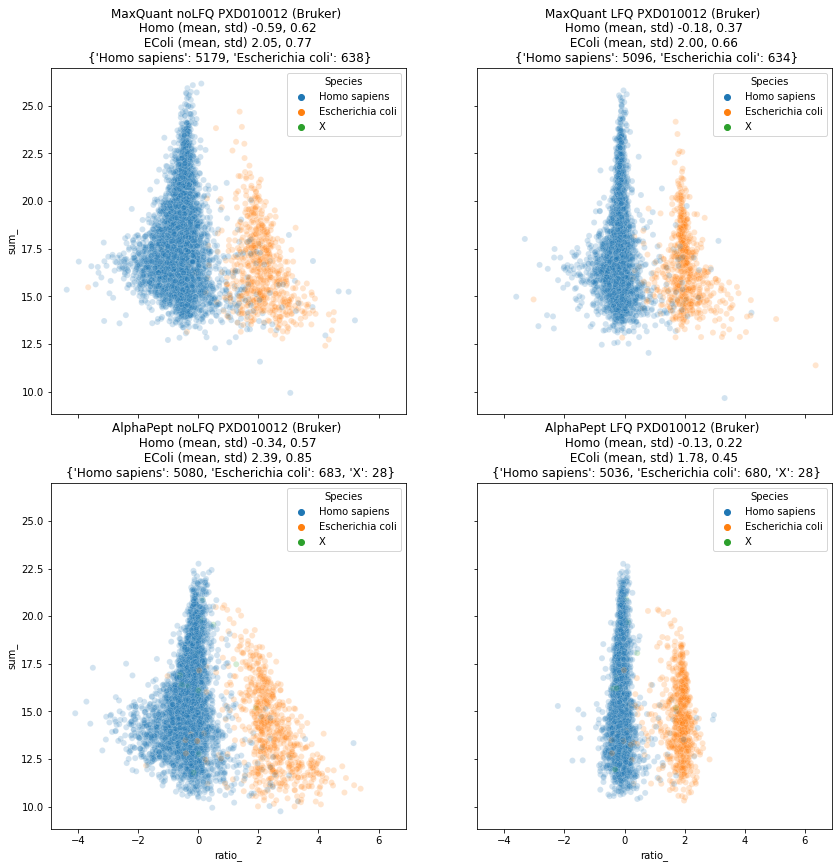

In [17]:
from test_helper import get_plot_df
import matplotlib.pyplot as plt
import seaborn as sns
import os

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD010012_ref.txt'), sep='\t') 

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Base_{i}" for i in range(1,6)]
    ratio_columns = [f"{x}ntensity Ratio_{i}" for i in range(1,6)]

    id_ = 'MaxQuant ' +_+' PXD010012 (Bruker)'
    get_plot_df(ref, base_columns, ratio_columns, axes[0,j], id_)


path = os.path.join(TEST_DIR, "results.hdf") #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')
ref.columns = [os.path.split(_)[1].replace('.ms_data.hdf','') for _ in ref.columns]

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD010012_CT_{i}_C1_01_Base{x}" for i in range(1,4)]
    ratio_columns = [f"PXD010012_CT_{i}_C2_01_Ratio{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD010012 (Bruker)'
    get_plot_df(ref, base_columns, ratio_columns, axes[1,j], id_)

plt.show()

2021-08-30 02:28:28> Loading files


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (54) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2021-08-30 02:28:31> A total of 10 files.
2021-08-30 02:28:41> A total of 7,413 proteins.


  0%|                                                                                            | 0/1 [05:22<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [04:34<00:00, 274.99s/it]


2021-08-30 02:28:54> Setting minimum occurence to 10.0
2021-08-30 02:29:01> Preparing protein table for parallel processing.
2021-08-30 02:29:12> Starting protein extraction for 7413 proteins.
2021-08-30 02:29:12> AlphaPool was set to 24 processes. Setting max to 24.


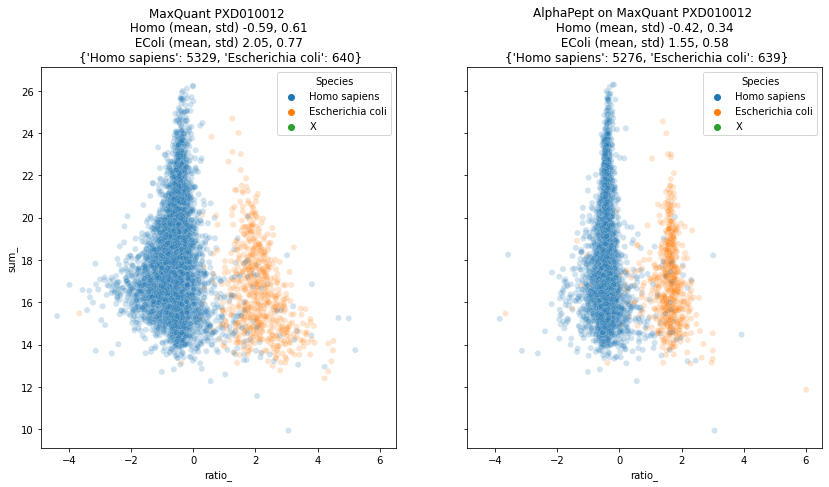

In [18]:
from alphapept.quantification import protein_profile_parallel_mq
from test_helper import get_plot_df

evidence_path = os.path.join(tmp_folder,'PXD010012_ref_evd.txt')
protein_group_path = os.path.join(tmp_folder,'PXD010012_ref.txt')

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

ref = pd.read_csv(protein_group_path, sep='\t')
species_dict = pd.Series(ref['Species'].values, index=ref['Protein IDs']).to_dict()
pt['Species'] = [species_dict[_] for _ in pt.index]


pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

test_id = 'PXD010012'

fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

ids = [f'{software_2} {test_id}', f'{software_1} on {software_2} {test_id}']

for i, ds in enumerate([pre_lfq, lfq]):

    base_columns = [_ for _ in ds if 'Base' in _]
    ratio_columns = [_ for _ in ds if 'Ratio' in _]
    get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i])

### Large Fasta

In [19]:
%run -i ../test_ci.py $tmp_folder thermo_hela_large_fasta

2021-08-30 02:31:29> Creating dir F:\develop\alphapept\sandbox\temp/test_temp.
2021-08-30 02:31:33> Using Python version for testing
2021-08-30 02:31:33> Logging to C:\Users\admin\alphapept\logs\log_20210830023133.txt.
2021-08-30 02:31:33> Platform information:
2021-08-30 02:31:33> system     - Windows
2021-08-30 02:31:33> release    - 10
2021-08-30 02:31:33> version    - 10.0.18363
2021-08-30 02:31:33> machine    - AMD64
2021-08-30 02:31:33> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-30 02:31:33> cpu count  - 24
2021-08-30 02:31:33> ram memory - 118.7/127.7 Gb (available/total)
2021-08-30 02:31:33> 
2021-08-30 02:31:33> Python information:
2021-08-30 02:31:33> SQLAlchemy       - 1.3.22
2021-08-30 02:31:33> alphapept        - 0.3.28
2021-08-30 02:31:33> biopython        - 1.78
2021-08-30 02:31:33> click            - 7.1.2
2021-08-30 02:31:33> comtypes         - 1.1.7
2021-08-30 02:31:33> fastcore         - 1.3.21
2021-08-30 02:31:33> h5py             - 3.1.

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:31:33> Processing 1 files for step raw_conversion
2021-08-30 02:31:33> File F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa has extension .raw - converting from Thermo.
2021-08-30 02:33:43> File conversion complete. Extracted 120,226 precursors.
2021-08-30 02:33:44> File conversion of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:33:44> Processing 1 files for step find_features
2021-08-30 02:33:44> No *.hdf file with features found for F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-08-30 02:33:45> Feature finding on F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw
2021-08-30 02:33:45> Hill extraction with centroid_tol 8 and max_gap 2


  0%|                                                                                            | 0/1 [02:11<?, ?it/s]


2021-08-30 02:33:51> Number of hills 1,105,353, len = 17.35
2021-08-30 02:33:51> Repeating hill extraction with centroid_tol 5.87
2021-08-30 02:33:57> Number of hills 1,227,331, len = 19.44
2021-08-30 02:34:17> After split hill_ptrs 1,635,903
2021-08-30 02:34:18> After filter hill_ptrs 1,585,989
2021-08-30 02:37:22> Extracting hill stats complete
2021-08-30 02:37:44> Found 190,099 pre isotope patterns.
2021-08-30 02:41:12> Extracted 234,728 isotope patterns.
2021-08-30 02:41:15> Report complete.
2021-08-30 02:41:15> Matching features to query data.
2021-08-30 02:41:17> Saving feature table.
2021-08-30 02:41:17> Feature table saved to F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf
2021-08-30 02:41:17> Saving features.
2021-08-30 02:41:17> Feature finding of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 02:41:17> Starting first search.
2021-08-30 02:41:28> Number of FASTA entries: 564,523 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'n_missed_cleavages': 2, 'pep_length_min': 6, 'pep_length_max': 27, 'isoforms_max': 1024, 'n_modifications_max': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': True, 'fasta_size_max': 100}
2021-08-30 02:41:28> Setting Process limit to 29
2021-08-30 02:41:28> AlphaPool was set to 24 processes. Setting max to 24.


  0%|                                                                                            | 0/1 [09:24<?, ?it/s]

2021-08-30 02:43:09> Block 1 of 565 complete - 0.18 % - created peptides 131,706 



  0%|                                                          | 0.0017699115044247787/1 [01:52<17:33:41, 63333.40s/it]

2021-08-30 02:43:12> Block 2 of 565 complete - 0.35 % - created peptides 136,294 


  0%|▏                                                          | 0.0035398230088495575/1 [01:56<7:37:45, 27563.56s/it]

2021-08-30 02:43:14> Block 3 of 565 complete - 0.53 % - created peptides 137,200 


  1%|▎                                                           | 0.005309734513274336/1 [01:57<4:13:38, 15299.87s/it]

2021-08-30 02:43:15> Block 4 of 565 complete - 0.71 % - created peptides 141,928 


  1%|▍                                                           | 0.007079646017699115/1 [02:01<2:46:58, 10090.37s/it]

2021-08-30 02:43:19> Block 5 of 565 complete - 0.88 % - created peptides 142,782 


  1%|▌                                                            | 0.008849557522123894/1 [02:04<1:57:45, 7129.07s/it]

2021-08-30 02:43:22> Block 6 of 565 complete - 1.06 % - created peptides 153,884 


  1%|▋                                                            | 0.010619469026548672/1 [02:09<1:30:46, 5504.67s/it]

2021-08-30 02:43:26> Block 7 of 565 complete - 1.24 % - created peptides 151,508 


  1%|▊                                                            | 0.012389380530973451/1 [02:12<1:12:57, 4432.83s/it]

2021-08-30 02:43:30> Block 8 of 565 complete - 1.42 % - created peptides 158,708 


  1%|▉                                                             | 0.01415929203539823/1 [02:16<1:00:26, 3678.17s/it]

2021-08-30 02:43:34> Block 9 of 565 complete - 1.59 % - created peptides 134,370 


  2%|█                                                               | 0.01592920353982301/1 [02:20<52:14, 3185.00s/it]

2021-08-30 02:43:37> Block 10 of 565 complete - 1.77 % - created peptides 150,010 


  2%|█                                                              | 0.017699115044247787/1 [02:23<44:56, 2745.17s/it]

2021-08-30 02:43:40> Block 11 of 565 complete - 1.95 % - created peptides 168,696 


  2%|█▏                                                             | 0.019469026548672566/1 [02:27<42:23, 2594.43s/it]

2021-08-30 02:43:44> Block 12 of 565 complete - 2.12 % - created peptides 145,388 


  2%|█▎                                                             | 0.021238938053097345/1 [02:30<38:48, 2379.01s/it]

2021-08-30 02:43:48> Block 13 of 565 complete - 2.30 % - created peptides 160,432 


  2%|█▍                                                             | 0.023008849557522124/1 [02:35<39:42, 2438.29s/it]

2021-08-30 02:43:52> Block 14 of 565 complete - 2.48 % - created peptides 170,612 


  2%|█▌                                                             | 0.024778761061946902/1 [02:39<39:09, 2408.84s/it]

2021-08-30 02:43:57> Block 15 of 565 complete - 2.65 % - created peptides 175,712 


  3%|█▋                                                              | 0.02654867256637168/1 [02:45<44:23, 2736.28s/it]

2021-08-30 02:44:03> Block 16 of 565 complete - 2.83 % - created peptides 172,810 


  3%|█▊                                                              | 0.02831858407079646/1 [02:51<46:53, 2895.32s/it]

2021-08-30 02:44:08> Block 17 of 565 complete - 3.01 % - created peptides 175,322 


  3%|█▉                                                              | 0.03008849557522124/1 [02:59<54:47, 3389.57s/it]

2021-08-30 02:44:17> Block 18 of 565 complete - 3.19 % - created peptides 176,668 


  3%|██                                                              | 0.03185840707964602/1 [03:06<56:16, 3487.59s/it]

2021-08-30 02:44:23> Block 19 of 565 complete - 3.36 % - created peptides 176,542 


  3%|██                                                             | 0.033628318584070796/1 [03:13<59:26, 3690.67s/it]

2021-08-30 02:44:30> Block 20 of 565 complete - 3.54 % - created peptides 181,926 


  4%|██▏                                                          | 0.035398230088495575/1 [03:21<1:04:29, 4011.12s/it]

2021-08-30 02:44:39> Block 21 of 565 complete - 3.72 % - created peptides 182,860 


  4%|██▎                                                           | 0.03716814159292035/1 [03:28<1:03:25, 3952.34s/it]

2021-08-30 02:44:46> Block 22 of 565 complete - 3.89 % - created peptides 181,094 


  4%|██▍                                                           | 0.03893805309734513/1 [03:36<1:04:26, 4023.64s/it]

2021-08-30 02:44:53> Block 23 of 565 complete - 4.07 % - created peptides 193,612 


  4%|██▌                                                           | 0.04070796460176991/1 [03:43<1:04:15, 4018.75s/it]

2021-08-30 02:45:00> Block 24 of 565 complete - 4.25 % - created peptides 206,820 


  4%|██▋                                                           | 0.04247787610619469/1 [03:50<1:06:07, 4143.14s/it]

2021-08-30 02:45:08> Block 25 of 565 complete - 4.42 % - created peptides 132,994 


  4%|██▋                                                           | 0.04424778761061947/1 [03:56<1:02:23, 3916.93s/it]

2021-08-30 02:45:14> Block 26 of 565 complete - 4.60 % - created peptides 133,548 


  5%|██▊                                                           | 0.04601769911504425/1 [04:04<1:03:03, 3966.41s/it]

2021-08-30 02:45:21> Block 27 of 565 complete - 4.78 % - created peptides 134,648 


  5%|██▉                                                          | 0.047787610619469026/1 [04:10<1:01:43, 3889.34s/it]

2021-08-30 02:45:28> Block 28 of 565 complete - 4.96 % - created peptides 174,392 


  5%|███                                                          | 0.049557522123893805/1 [04:19<1:06:17, 4184.59s/it]

2021-08-30 02:45:37> Block 29 of 565 complete - 5.13 % - created peptides 130,340 


  5%|███▏                                                          | 0.05132743362831858/1 [04:28<1:11:15, 4506.38s/it]

2021-08-30 02:45:46> Block 30 of 565 complete - 5.31 % - created peptides 147,430 


  5%|███▎                                                          | 0.05309734513274336/1 [04:37<1:12:15, 4578.99s/it]

2021-08-30 02:45:54> Block 31 of 565 complete - 5.49 % - created peptides 146,326 


  5%|███▍                                                          | 0.05486725663716814/1 [04:45<1:12:34, 4607.56s/it]

2021-08-30 02:46:02> Block 32 of 565 complete - 5.66 % - created peptides 164,200 


  6%|███▌                                                          | 0.05663716814159292/1 [04:54<1:14:03, 4710.63s/it]

2021-08-30 02:46:11> Block 33 of 565 complete - 5.84 % - created peptides 163,276 


  6%|███▋                                                           | 0.0584070796460177/1 [05:00<1:07:39, 4311.68s/it]

2021-08-30 02:46:17> Block 34 of 565 complete - 6.02 % - created peptides 181,200 


  6%|███▋                                                          | 0.06017699115044248/1 [05:08<1:10:18, 4488.55s/it]

2021-08-30 02:46:26> Block 35 of 565 complete - 6.19 % - created peptides 185,570 


  6%|███▊                                                         | 0.061946902654867256/1 [05:18<1:14:08, 4742.36s/it]

2021-08-30 02:46:35> Block 36 of 565 complete - 6.37 % - created peptides 149,212 


  6%|███▉                                                          | 0.06371681415929203/1 [05:24<1:08:48, 4409.47s/it]

2021-08-30 02:46:42> Block 37 of 565 complete - 6.55 % - created peptides 171,860 


  7%|████                                                          | 0.06548672566371681/1 [05:33<1:12:43, 4669.60s/it]

2021-08-30 02:46:51> Block 38 of 565 complete - 6.73 % - created peptides 171,700 


  7%|████▏                                                         | 0.06725663716814159/1 [05:41<1:09:59, 4502.10s/it]

2021-08-30 02:46:58> Block 39 of 565 complete - 6.90 % - created peptides 216,084 


  7%|████▎                                                         | 0.06902654867256637/1 [05:50<1:12:48, 4691.95s/it]

2021-08-30 02:47:07> Block 40 of 565 complete - 7.08 % - created peptides 198,478 


  7%|████▍                                                         | 0.07079646017699115/1 [05:58<1:13:23, 4738.59s/it]

2021-08-30 02:47:16> Block 41 of 565 complete - 7.26 % - created peptides 225,264 


  7%|████▍                                                         | 0.07256637168141593/1 [06:09<1:18:25, 5073.95s/it]

2021-08-30 02:47:26> Block 42 of 565 complete - 7.43 % - created peptides 212,378 


  7%|████▋                                                          | 0.0743362831858407/1 [06:20<1:23:42, 5425.52s/it]

2021-08-30 02:47:37> Block 43 of 565 complete - 7.61 % - created peptides 202,198 


  8%|████▋                                                         | 0.07610619469026549/1 [06:31<1:26:59, 5649.95s/it]

2021-08-30 02:47:48> Block 44 of 565 complete - 7.79 % - created peptides 206,834 


  8%|████▊                                                         | 0.07787610619469026/1 [06:38<1:19:48, 5192.50s/it]

2021-08-30 02:47:56> Block 45 of 565 complete - 7.96 % - created peptides 181,538 


  8%|████▉                                                         | 0.07964601769911504/1 [06:49<1:23:05, 5416.81s/it]

2021-08-30 02:48:06> Block 46 of 565 complete - 8.14 % - created peptides 214,350 


  8%|█████                                                         | 0.08141592920353982/1 [06:56<1:17:18, 5049.77s/it]

2021-08-30 02:48:14> Block 47 of 565 complete - 8.32 % - created peptides 208,136 


  8%|█████▏                                                         | 0.0831858407079646/1 [07:08<1:23:53, 5490.63s/it]

2021-08-30 02:48:25> Block 48 of 565 complete - 8.50 % - created peptides 235,102 


  8%|█████▎                                                        | 0.08495575221238938/1 [07:16<1:21:33, 5347.82s/it]

2021-08-30 02:48:34> Block 49 of 565 complete - 8.67 % - created peptides 150,464 


  9%|█████▍                                                        | 0.08672566371681416/1 [07:27<1:25:31, 5618.72s/it]

2021-08-30 02:48:45> Block 50 of 565 complete - 8.85 % - created peptides 139,836 


  9%|█████▍                                                        | 0.08849557522123894/1 [07:35<1:18:32, 5170.49s/it]

2021-08-30 02:48:52> Block 51 of 565 complete - 9.03 % - created peptides 161,286 


  9%|█████▌                                                        | 0.09026548672566372/1 [07:44<1:18:45, 5194.18s/it]

2021-08-30 02:49:02> Block 52 of 565 complete - 9.20 % - created peptides 142,328 


  9%|█████▊                                                         | 0.0920353982300885/1 [07:55<1:23:31, 5519.23s/it]

2021-08-30 02:49:13> Block 53 of 565 complete - 9.38 % - created peptides 200,772 


  9%|█████▊                                                        | 0.09380530973451327/1 [08:07<1:28:13, 5841.52s/it]

2021-08-30 02:49:24> Block 54 of 565 complete - 9.56 % - created peptides 152,274 


 10%|█████▉                                                        | 0.09557522123893805/1 [08:15<1:22:38, 5482.64s/it]

2021-08-30 02:49:33> Block 55 of 565 complete - 9.73 % - created peptides 175,328 


 10%|██████                                                        | 0.09734513274336283/1 [08:27<1:28:00, 5849.64s/it]

2021-08-30 02:49:44> Block 56 of 565 complete - 9.91 % - created peptides 171,034 


 10%|██████▏                                                       | 0.09911504424778761/1 [08:36<1:24:47, 5647.28s/it]

2021-08-30 02:49:54> Block 57 of 565 complete - 10.09 % - created peptides 192,526 


 10%|██████▎                                                       | 0.10088495575221239/1 [08:44<1:19:19, 5293.88s/it]

2021-08-30 02:50:02> Block 58 of 565 complete - 10.27 % - created peptides 145,706 


 10%|██████▎                                                       | 0.10265486725663717/1 [08:57<1:27:43, 5865.89s/it]

2021-08-30 02:50:14> Block 59 of 565 complete - 10.44 % - created peptides 200,642 


 10%|██████▍                                                       | 0.10442477876106195/1 [09:06<1:23:24, 5588.45s/it]

2021-08-30 02:50:23> Block 60 of 565 complete - 10.62 % - created peptides 210,320 


 11%|██████▌                                                       | 0.10619469026548672/1 [09:18<1:28:41, 5954.12s/it]

2021-08-30 02:50:35> Block 61 of 565 complete - 10.80 % - created peptides 184,958 


 11%|██████▊                                                        | 0.1079646017699115/1 [09:26<1:23:52, 5641.27s/it]

2021-08-30 02:50:44> Block 62 of 565 complete - 10.97 % - created peptides 165,616 


 11%|██████▊                                                       | 0.10973451327433628/1 [09:39<1:29:46, 6050.66s/it]

2021-08-30 02:50:56> Block 63 of 565 complete - 11.15 % - created peptides 176,008 


 11%|██████▉                                                       | 0.11150442477876106/1 [09:48<1:25:05, 5746.34s/it]

2021-08-30 02:51:05> Block 64 of 565 complete - 11.33 % - created peptides 170,182 


 11%|███████                                                       | 0.11327433628318584/1 [09:58<1:24:33, 5721.05s/it]

2021-08-30 02:51:15> Block 65 of 565 complete - 11.50 % - created peptides 184,052 


 12%|███████▏                                                      | 0.11504424778761062/1 [10:10<1:30:56, 6166.32s/it]

2021-08-30 02:51:28> Block 66 of 565 complete - 11.68 % - created peptides 168,210 


 12%|███████▎                                                       | 0.1168141592920354/1 [10:18<1:22:35, 5610.53s/it]

2021-08-30 02:51:36> Block 67 of 565 complete - 11.86 % - created peptides 226,892 


 12%|███████▎                                                      | 0.11858407079646018/1 [10:31<1:29:19, 6080.18s/it]

2021-08-30 02:51:48> Block 68 of 565 complete - 12.04 % - created peptides 212,550 


 12%|███████▍                                                      | 0.12035398230088495/1 [10:41<1:27:12, 5947.95s/it]

2021-08-30 02:51:58> Block 69 of 565 complete - 12.21 % - created peptides 193,414 


 12%|███████▌                                                      | 0.12212389380530973/1 [10:50<1:23:56, 5737.41s/it]

2021-08-30 02:52:07> Block 70 of 565 complete - 12.39 % - created peptides 200,942 


 12%|███████▋                                                      | 0.12389380530973451/1 [11:04<1:34:08, 6446.88s/it]

2021-08-30 02:52:22> Block 71 of 565 complete - 12.57 % - created peptides 147,694 


 13%|███████▉                                                       | 0.1256637168141593/1 [11:13<1:28:03, 6043.25s/it]

2021-08-30 02:52:31> Block 72 of 565 complete - 12.74 % - created peptides 152,250 


 13%|███████▉                                                      | 0.12743362831858407/1 [11:22<1:21:46, 5623.34s/it]

2021-08-30 02:52:39> Block 73 of 565 complete - 12.92 % - created peptides 229,114 


 13%|████████                                                      | 0.12920353982300886/1 [11:35<1:31:24, 6298.09s/it]

2021-08-30 02:52:53> Block 74 of 565 complete - 13.10 % - created peptides 234,608 


 13%|████████                                                      | 0.13097345132743363/1 [11:44<1:25:52, 5929.13s/it]

2021-08-30 02:53:02> Block 75 of 565 complete - 13.27 % - created peptides 184,850 


 13%|████████▏                                                     | 0.13274336283185842/1 [11:52<1:18:25, 5425.81s/it]

2021-08-30 02:53:09> Block 76 of 565 complete - 13.45 % - created peptides 151,570 


 13%|████████▎                                                     | 0.13451327433628318/1 [12:07<1:30:57, 6306.07s/it]

2021-08-30 02:53:24> Block 77 of 565 complete - 13.63 % - created peptides 199,456 


 14%|████████▍                                                     | 0.13628318584070798/1 [12:16<1:26:04, 5979.11s/it]

2021-08-30 02:53:34> Block 78 of 565 complete - 13.81 % - created peptides 183,342 


 14%|████████▌                                                     | 0.13805309734513274/1 [12:24<1:20:04, 5573.52s/it]

2021-08-30 02:53:42> Block 79 of 565 complete - 13.98 % - created peptides 150,592 


 14%|████████▋                                                     | 0.13982300884955753/1 [12:38<1:28:49, 6195.98s/it]

2021-08-30 02:53:55> Block 80 of 565 complete - 14.16 % - created peptides 177,422 


 14%|████████▉                                                      | 0.1415929203539823/1 [12:47<1:24:07, 5879.58s/it]

2021-08-30 02:54:04> Block 81 of 565 complete - 14.34 % - created peptides 193,852 


 14%|█████████                                                      | 0.1433628318584071/1 [12:56<1:20:03, 5607.43s/it]

2021-08-30 02:54:13> Block 82 of 565 complete - 14.51 % - created peptides 171,176 


 15%|████████▉                                                     | 0.14513274336283186/1 [13:09<1:28:19, 6198.89s/it]

2021-08-30 02:54:27> Block 83 of 565 complete - 14.69 % - created peptides 142,104 


 15%|█████████                                                     | 0.14690265486725665/1 [13:18<1:23:42, 5887.00s/it]

2021-08-30 02:54:36> Block 84 of 565 complete - 14.87 % - created peptides 199,534 


 15%|█████████▎                                                     | 0.1486725663716814/1 [13:27<1:20:31, 5674.75s/it]

2021-08-30 02:54:45> Block 85 of 565 complete - 15.04 % - created peptides 193,426 


 15%|█████████▍                                                     | 0.1504424778761062/1 [13:42<1:32:20, 6521.14s/it]

2021-08-30 02:55:00> Block 86 of 565 complete - 15.22 % - created peptides 199,258 


 15%|█████████▍                                                    | 0.15221238938053097/1 [13:51<1:26:19, 6108.91s/it]

2021-08-30 02:55:09> Block 87 of 565 complete - 15.40 % - created peptides 161,900 


 15%|█████████▌                                                    | 0.15398230088495576/1 [14:00<1:21:50, 5804.26s/it]

2021-08-30 02:55:18> Block 88 of 565 complete - 15.58 % - created peptides 181,748 


 16%|█████████▋                                                    | 0.15575221238938053/1 [14:15<1:31:27, 6499.68s/it]

2021-08-30 02:55:32> Block 89 of 565 complete - 15.75 % - created peptides 182,478 


 16%|█████████▊                                                    | 0.15752212389380532/1 [14:23<1:23:43, 5963.10s/it]

2021-08-30 02:55:41> Block 90 of 565 complete - 15.93 % - created peptides 178,320 


 16%|██████████                                                     | 0.1592920353982301/1 [14:32<1:19:54, 5702.49s/it]

2021-08-30 02:55:50> Block 91 of 565 complete - 16.11 % - created peptides 192,288 


 16%|█████████▉                                                    | 0.16106194690265488/1 [14:41<1:16:37, 5480.32s/it]

2021-08-30 02:55:59> Block 92 of 565 complete - 16.28 % - created peptides 218,448 


 16%|██████████                                                    | 0.16283185840707964/1 [14:56<1:29:22, 6405.91s/it]

2021-08-30 02:56:14> Block 93 of 565 complete - 16.46 % - created peptides 190,196 


 16%|██████████▏                                                   | 0.16460176991150444/1 [15:06<1:25:20, 6129.18s/it]

2021-08-30 02:56:23> Block 94 of 565 complete - 16.64 % - created peptides 200,434 


 17%|██████████▍                                                    | 0.1663716814159292/1 [15:14<1:19:42, 5736.54s/it]

2021-08-30 02:56:32> Block 95 of 565 complete - 16.81 % - created peptides 230,228 


 17%|██████████▊                                                     | 0.168141592920354/1 [15:24<1:17:35, 5596.19s/it]

2021-08-30 02:56:41> Block 96 of 565 complete - 16.99 % - created peptides 149,864 


 17%|██████████▌                                                   | 0.16991150442477876/1 [15:38<1:27:40, 6337.66s/it]

2021-08-30 02:56:56> Block 97 of 565 complete - 17.17 % - created peptides 151,016 


 17%|██████████▋                                                   | 0.17168141592920355/1 [15:47<1:22:41, 5990.34s/it]

2021-08-30 02:57:05> Block 98 of 565 complete - 17.35 % - created peptides 186,390 


 17%|██████████▊                                                   | 0.17345132743362832/1 [15:56<1:18:39, 5709.50s/it]

2021-08-30 02:57:14> Block 99 of 565 complete - 17.52 % - created peptides 188,974 


 18%|███████████                                                    | 0.1752212389380531/1 [16:14<1:35:29, 6946.39s/it]

2021-08-30 02:57:31> Block 100 of 565 complete - 17.70 % - created peptides 144,978 


 18%|██████████▉                                                   | 0.17699115044247787/1 [16:22<1:27:17, 6363.58s/it]

2021-08-30 02:57:40> Block 101 of 565 complete - 17.88 % - created peptides 161,746 


 18%|███████████                                                   | 0.17876106194690267/1 [16:31<1:21:47, 5975.41s/it]

2021-08-30 02:57:49> Block 102 of 565 complete - 18.05 % - created peptides 148,160 


 18%|███████████▏                                                  | 0.18053097345132743/1 [16:42<1:22:03, 6008.36s/it]

2021-08-30 02:58:00> Block 103 of 565 complete - 18.23 % - created peptides 174,134 


 18%|███████████▎                                                  | 0.18230088495575222/1 [16:59<1:35:59, 7043.54s/it]

2021-08-30 02:58:16> Block 104 of 565 complete - 18.41 % - created peptides 188,426 


 18%|███████████▊                                                    | 0.184070796460177/1 [17:08<1:28:27, 6505.22s/it]

2021-08-30 02:58:26> Block 105 of 565 complete - 18.58 % - created peptides 200,970 


 19%|███████████▌                                                  | 0.18584070796460178/1 [17:18<1:24:19, 6213.83s/it]

2021-08-30 02:58:35> Block 106 of 565 complete - 18.76 % - created peptides 157,028 


 19%|███████████▋                                                  | 0.18761061946902655/1 [17:28<1:21:39, 6031.04s/it]

2021-08-30 02:58:45> Block 107 of 565 complete - 18.94 % - created peptides 182,438 


 19%|███████████▋                                                  | 0.18938053097345134/1 [17:45<1:35:33, 7072.41s/it]

2021-08-30 02:59:02> Block 108 of 565 complete - 19.12 % - created peptides 157,718 


 19%|████████████                                                   | 0.1911504424778761/1 [17:54<1:27:15, 6472.96s/it]

2021-08-30 02:59:11> Block 109 of 565 complete - 19.29 % - created peptides 156,360 


 19%|████████████▏                                                  | 0.1929203539823009/1 [18:04<1:23:27, 6204.90s/it]

2021-08-30 02:59:21> Block 110 of 565 complete - 19.47 % - created peptides 148,316 


 19%|████████████                                                  | 0.19469026548672566/1 [18:13<1:20:34, 6003.89s/it]

2021-08-30 02:59:31> Block 111 of 565 complete - 19.65 % - created peptides 160,210 


 20%|████████████▏                                                 | 0.19646017699115045/1 [18:31<1:36:05, 7174.53s/it]

2021-08-30 02:59:48> Block 112 of 565 complete - 19.82 % - created peptides 169,722 


 20%|████████████▎                                                 | 0.19823008849557522/1 [18:40<1:28:42, 6638.15s/it]

2021-08-30 02:59:58> Block 113 of 565 complete - 20.00 % - created peptides 156,726 


 20%|███████████████▌                                                              | 0.2/1 [18:50<1:24:17, 6321.33s/it]

2021-08-30 03:00:08> Block 114 of 565 complete - 20.18 % - created peptides 152,464 


 20%|████████████▌                                                 | 0.20176991150442478/1 [19:01<1:22:21, 6191.02s/it]

2021-08-30 03:00:18> Block 115 of 565 complete - 20.35 % - created peptides 147,526 


 20%|████████████▌                                                 | 0.20353982300884957/1 [19:10<1:19:05, 5958.13s/it]

2021-08-30 03:00:28> Block 116 of 565 complete - 20.53 % - created peptides 180,536 


 21%|████████████▋                                                 | 0.20530973451327433/1 [19:27<1:32:49, 7008.35s/it]

2021-08-30 03:00:45> Block 117 of 565 complete - 20.71 % - created peptides 210,872 


 21%|████████████▊                                                 | 0.20707964601769913/1 [19:37<1:26:35, 6552.79s/it]

2021-08-30 03:00:54> Block 118 of 565 complete - 20.88 % - created peptides 159,952 


 21%|█████████████▏                                                 | 0.2088495575221239/1 [19:46<1:20:18, 6090.95s/it]

2021-08-30 03:01:03> Block 119 of 565 complete - 21.06 % - created peptides 154,866 


 21%|█████████████                                                 | 0.21061946902654868/1 [19:56<1:19:26, 6038.22s/it]

2021-08-30 03:01:14> Block 120 of 565 complete - 21.24 % - created peptides 222,658 


 21%|█████████████▏                                                | 0.21238938053097345/1 [20:14<1:35:33, 7279.27s/it]

2021-08-30 03:01:32> Block 121 of 565 complete - 21.42 % - created peptides 213,292 


 21%|█████████████▎                                                | 0.21415929203539824/1 [20:24<1:28:43, 6774.35s/it]

2021-08-30 03:01:42> Block 122 of 565 complete - 21.59 % - created peptides 118,604 


 22%|█████████████▊                                                  | 0.215929203539823/1 [20:33<1:22:01, 6277.15s/it]

2021-08-30 03:01:51> Block 123 of 565 complete - 21.77 % - created peptides 195,164 


 22%|█████████████▋                                                 | 0.2176991150442478/1 [20:44<1:20:28, 6172.75s/it]

2021-08-30 03:02:01> Block 124 of 565 complete - 21.95 % - created peptides 226,130 


 22%|█████████████▌                                                | 0.21946902654867256/1 [20:55<1:21:03, 6230.74s/it]

2021-08-30 03:02:12> Block 125 of 565 complete - 22.12 % - created peptides 242,590 


 22%|█████████████▋                                                | 0.22123893805309736/1 [21:14<1:39:46, 7687.55s/it]

2021-08-30 03:02:32> Block 126 of 565 complete - 22.30 % - created peptides 175,664 


 22%|█████████████▊                                                | 0.22300884955752212/1 [21:25<1:32:35, 7150.02s/it]

2021-08-30 03:02:42> Block 127 of 565 complete - 22.48 % - created peptides 190,570 


 22%|██████████████▏                                                | 0.2247787610619469/1 [21:35<1:26:14, 6675.35s/it]

2021-08-30 03:02:52> Block 128 of 565 complete - 22.65 % - created peptides 158,736 


 23%|██████████████                                                | 0.22654867256637168/1 [21:45<1:22:27, 6396.70s/it]

2021-08-30 03:03:02> Block 129 of 565 complete - 22.83 % - created peptides 181,780 


 23%|██████████████▏                                               | 0.22831858407079647/1 [21:55<1:19:27, 6178.54s/it]

2021-08-30 03:03:12> Block 130 of 565 complete - 23.01 % - created peptides 190,868 


 23%|██████████████▎                                               | 0.23008849557522124/1 [22:14<1:36:57, 7556.15s/it]

2021-08-30 03:03:32> Block 131 of 565 complete - 23.19 % - created peptides 167,154 


 23%|██████████████▍                                               | 0.23185840707964603/1 [22:24<1:28:34, 6918.27s/it]

2021-08-30 03:03:41> Block 132 of 565 complete - 23.36 % - created peptides 149,960 


 23%|██████████████▋                                                | 0.2336283185840708/1 [22:34<1:23:34, 6542.84s/it]

2021-08-30 03:03:51> Block 133 of 565 complete - 23.54 % - created peptides 151,244 


 24%|██████████████▌                                               | 0.23539823008849559/1 [22:43<1:18:39, 6172.77s/it]

2021-08-30 03:04:01> Block 134 of 565 complete - 23.72 % - created peptides 184,644 


 24%|██████████████▋                                               | 0.23716814159292035/1 [22:53<1:16:09, 5989.86s/it]

2021-08-30 03:04:10> Block 135 of 565 complete - 23.89 % - created peptides 175,630 


 24%|██████████████▊                                               | 0.23893805309734514/1 [23:03<1:15:30, 5953.19s/it]

2021-08-30 03:04:21> Block 136 of 565 complete - 24.07 % - created peptides 139,342 


 24%|███████████████▏                                               | 0.2407079646017699/1 [23:20<1:28:32, 6996.32s/it]

2021-08-30 03:04:37> Block 137 of 565 complete - 24.25 % - created peptides 144,486 


 24%|███████████████▎                                               | 0.2424778761061947/1 [23:30<1:23:56, 6649.10s/it]

2021-08-30 03:04:48> Block 138 of 565 complete - 24.42 % - created peptides 191,560 


 24%|███████████████▏                                              | 0.24424778761061947/1 [23:40<1:19:56, 6346.68s/it]

2021-08-30 03:04:58> Block 139 of 565 complete - 24.60 % - created peptides 188,606 


 25%|███████████████▎                                              | 0.24601769911504426/1 [23:50<1:16:25, 6081.20s/it]

2021-08-30 03:05:07> Block 140 of 565 complete - 24.78 % - created peptides 142,766 


 25%|███████████████▎                                              | 0.24778761061946902/1 [24:00<1:15:47, 6045.44s/it]

2021-08-30 03:05:18> Block 141 of 565 complete - 24.96 % - created peptides 210,538 


 25%|███████████████▍                                              | 0.24955752212389382/1 [24:20<1:34:21, 7544.47s/it]

2021-08-30 03:05:38> Block 142 of 565 complete - 25.13 % - created peptides 164,846 


 25%|███████████████▊                                               | 0.2513274336283186/1 [24:30<1:26:24, 6924.68s/it]

2021-08-30 03:05:47> Block 143 of 565 complete - 25.31 % - created peptides 144,476 


 25%|███████████████▋                                              | 0.25309734513274335/1 [24:40<1:21:06, 6516.00s/it]

2021-08-30 03:05:57> Block 144 of 565 complete - 25.49 % - created peptides 147,202 


 25%|███████████████▊                                              | 0.25486725663716814/1 [24:49<1:17:19, 6225.97s/it]

2021-08-30 03:06:07> Block 145 of 565 complete - 25.66 % - created peptides 216,994 


 26%|███████████████▉                                              | 0.25663716814159293/1 [25:00<1:16:25, 6168.63s/it]

2021-08-30 03:06:18> Block 146 of 565 complete - 25.84 % - created peptides 186,032 


 26%|████████████████▎                                              | 0.2584070796460177/1 [25:11<1:15:37, 6118.35s/it]

2021-08-30 03:06:28> Block 147 of 565 complete - 26.02 % - created peptides 178,618 


 26%|████████████████▏                                             | 0.26017699115044246/1 [25:31<1:35:57, 7782.30s/it]

2021-08-30 03:06:49> Block 148 of 565 complete - 26.19 % - created peptides 191,098 


 26%|████████████████▏                                             | 0.26194690265486725/1 [25:41<1:27:50, 7140.88s/it]

2021-08-30 03:06:59> Block 149 of 565 complete - 26.37 % - created peptides 204,878 


 26%|████████████████▎                                             | 0.26371681415929205/1 [25:52<1:22:51, 6752.73s/it]

2021-08-30 03:07:09> Block 150 of 565 complete - 26.55 % - created peptides 177,984 


 27%|████████████████▍                                             | 0.26548672566371684/1 [26:01<1:17:30, 6331.94s/it]

2021-08-30 03:07:19> Block 151 of 565 complete - 26.73 % - created peptides 171,596 


 27%|████████████████▊                                              | 0.2672566371681416/1 [26:10<1:12:16, 5917.57s/it]

2021-08-30 03:07:27> Block 152 of 565 complete - 26.90 % - created peptides 176,392 


 27%|████████████████▋                                             | 0.26902654867256637/1 [26:21<1:12:46, 5974.05s/it]

2021-08-30 03:07:38> Block 153 of 565 complete - 27.08 % - created peptides 207,402 


 27%|████████████████▊                                             | 0.27079646017699116/1 [26:42<1:34:18, 7759.82s/it]

2021-08-30 03:07:59> Block 154 of 565 complete - 27.26 % - created peptides 168,394 


 27%|████████████████▉                                             | 0.27256637168141595/1 [26:53<1:28:38, 7311.56s/it]

2021-08-30 03:08:10> Block 155 of 565 complete - 27.43 % - created peptides 226,022 


 27%|█████████████████▎                                             | 0.2743362831858407/1 [27:03<1:21:37, 6749.63s/it]

2021-08-30 03:08:20> Block 156 of 565 complete - 27.61 % - created peptides 159,518 


 28%|█████████████████▍                                             | 0.2761061946902655/1 [27:12<1:16:35, 6348.20s/it]

2021-08-30 03:08:30> Block 157 of 565 complete - 27.79 % - created peptides 147,076 


 28%|█████████████████▌                                             | 0.2778761061946903/1 [27:22<1:12:51, 6054.06s/it]

2021-08-30 03:08:39> Block 158 of 565 complete - 27.96 % - created peptides 162,304 


 28%|█████████████████▎                                            | 0.27964601769911507/1 [27:33<1:14:20, 6192.60s/it]

2021-08-30 03:08:51> Block 159 of 565 complete - 28.14 % - created peptides 192,848 


 28%|█████████████████▋                                             | 0.2814159292035398/1 [27:55<1:35:31, 7975.52s/it]

2021-08-30 03:09:12> Block 160 of 565 complete - 28.32 % - created peptides 193,232 


 28%|█████████████████▊                                             | 0.2831858407079646/1 [28:06<1:29:02, 7453.62s/it]

2021-08-30 03:09:23> Block 161 of 565 complete - 28.50 % - created peptides 175,270 


 28%|█████████████████▉                                             | 0.2849557522123894/1 [28:16<1:22:26, 6918.28s/it]

2021-08-30 03:09:33> Block 162 of 565 complete - 28.67 % - created peptides 176,826 


 29%|██████████████████                                             | 0.2867256637168142/1 [28:26<1:17:34, 6525.28s/it]

2021-08-30 03:09:43> Block 163 of 565 complete - 28.85 % - created peptides 149,158 


 29%|██████████████████▏                                            | 0.2884955752212389/1 [28:36<1:14:47, 6306.87s/it]

2021-08-30 03:09:53> Block 164 of 565 complete - 29.03 % - created peptides 162,394 


 29%|██████████████████▎                                            | 0.2902654867256637/1 [28:46<1:11:52, 6075.51s/it]

2021-08-30 03:10:03> Block 165 of 565 complete - 29.20 % - created peptides 213,498 


 29%|██████████████████▍                                            | 0.2920353982300885/1 [28:57<1:12:17, 6127.02s/it]

2021-08-30 03:10:14> Block 166 of 565 complete - 29.38 % - created peptides 205,550 


 29%|██████████████████▌                                            | 0.2938053097345133/1 [29:18<1:32:37, 7870.03s/it]

2021-08-30 03:10:35> Block 167 of 565 complete - 29.56 % - created peptides 172,390 


 30%|██████████████████▎                                           | 0.29557522123893804/1 [29:28<1:23:53, 7146.08s/it]

2021-08-30 03:10:45> Block 168 of 565 complete - 29.73 % - created peptides 150,036 


 30%|██████████████████▋                                            | 0.2973451327433628/1 [29:37<1:16:52, 6564.02s/it]

2021-08-30 03:10:54> Block 169 of 565 complete - 29.91 % - created peptides 180,820 


 30%|██████████████████▊                                            | 0.2991150442477876/1 [29:46<1:11:50, 6149.45s/it]

2021-08-30 03:11:03> Block 170 of 565 complete - 30.09 % - created peptides 153,560 


 30%|██████████████████▉                                            | 0.3008849557522124/1 [29:56<1:09:32, 5968.78s/it]

2021-08-30 03:11:13> Block 171 of 565 complete - 30.27 % - created peptides 171,850 


 30%|██████████████████▊                                           | 0.30265486725663715/1 [30:05<1:07:02, 5768.21s/it]

2021-08-30 03:11:23> Block 172 of 565 complete - 30.44 % - created peptides 173,846 


 30%|██████████████████▊                                           | 0.30442477876106194/1 [30:13<1:01:47, 5329.68s/it]

2021-08-30 03:11:30> Block 173 of 565 complete - 30.62 % - created peptides 156,236 


 31%|██████████████████▉                                           | 0.30619469026548674/1 [30:30<1:17:29, 6701.25s/it]

2021-08-30 03:11:48> Block 174 of 565 complete - 30.80 % - created peptides 146,874 


 31%|███████████████████                                           | 0.30796460176991153/1 [30:36<1:04:56, 5630.00s/it]

2021-08-30 03:11:53> Block 175 of 565 complete - 30.97 % - created peptides 146,956 


 31%|███████████████████▊                                            | 0.30973451327433627/1 [30:41<54:53, 4771.54s/it]

2021-08-30 03:11:58> Block 176 of 565 complete - 31.15 % - created peptides 141,456 


 31%|███████████████████▉                                            | 0.31150442477876106/1 [30:46<47:52, 4172.14s/it]

2021-08-30 03:12:03> Block 177 of 565 complete - 31.33 % - created peptides 159,864 


 31%|████████████████████                                            | 0.31327433628318585/1 [30:51<42:55, 3751.13s/it]

2021-08-30 03:12:08> Block 178 of 565 complete - 31.50 % - created peptides 207,560 


 32%|████████████████████▏                                           | 0.31504424778761064/1 [30:56<39:43, 3479.34s/it]

2021-08-30 03:12:13> Block 179 of 565 complete - 31.68 % - created peptides 148,658 


 32%|████████████████████▌                                            | 0.3168141592920354/1 [31:00<37:12, 3267.15s/it]

2021-08-30 03:12:18> Block 180 of 565 complete - 31.86 % - created peptides 139,662 


 32%|████████████████████▋                                            | 0.3185840707964602/1 [31:05<35:27, 3121.52s/it]

2021-08-30 03:12:23> Block 181 of 565 complete - 32.04 % - created peptides 190,864 


 32%|████████████████████▌                                           | 0.32035398230088497/1 [31:18<49:15, 4348.95s/it]

2021-08-30 03:12:36> Block 182 of 565 complete - 32.21 % - created peptides 182,724 


 32%|████████████████████▌                                           | 0.32212389380530976/1 [31:23<44:01, 3897.22s/it]

2021-08-30 03:12:41> Block 183 of 565 complete - 32.39 % - created peptides 202,286 


 32%|█████████████████████                                            | 0.3238938053097345/1 [31:28<40:23, 3584.37s/it]

2021-08-30 03:12:46> Block 184 of 565 complete - 32.57 % - created peptides 174,774 


 33%|█████████████████████▏                                           | 0.3256637168141593/1 [31:33<37:41, 3354.18s/it]

2021-08-30 03:12:51> Block 185 of 565 complete - 32.74 % - created peptides 137,594 


 33%|█████████████████████▎                                           | 0.3274336283185841/1 [31:38<35:43, 3186.46s/it]

2021-08-30 03:12:56> Block 186 of 565 complete - 32.92 % - created peptides 140,434 


 33%|█████████████████████▍                                           | 0.3292035398230089/1 [31:43<34:20, 3071.47s/it]

2021-08-30 03:13:01> Block 187 of 565 complete - 33.10 % - created peptides 173,458 


 33%|█████████████████████▌                                           | 0.3309734513274336/1 [31:48<33:23, 2995.11s/it]

2021-08-30 03:13:06> Block 188 of 565 complete - 33.27 % - created peptides 174,340 


 33%|█████████████████████▋                                           | 0.3327433628318584/1 [31:53<32:50, 2953.72s/it]

2021-08-30 03:13:11> Block 189 of 565 complete - 33.45 % - created peptides 195,590 


 33%|█████████████████████▋                                           | 0.3345132743362832/1 [31:58<32:33, 2935.44s/it]

2021-08-30 03:13:16> Block 190 of 565 complete - 33.63 % - created peptides 132,622 


 34%|██████████████████████▏                                           | 0.336283185840708/1 [32:03<32:00, 2894.16s/it]

2021-08-30 03:13:21> Block 191 of 565 complete - 33.81 % - created peptides 154,774 


 34%|█████████████████████▉                                           | 0.3380530973451327/1 [32:16<45:44, 4146.63s/it]

2021-08-30 03:13:33> Block 192 of 565 complete - 33.98 % - created peptides 179,824 


 34%|██████████████████████                                           | 0.3398230088495575/1 [32:21<41:19, 3755.50s/it]

2021-08-30 03:13:38> Block 193 of 565 complete - 34.16 % - created peptides 174,324 


 34%|██████████████████████▏                                          | 0.3415929203539823/1 [32:26<38:17, 3489.10s/it]

2021-08-30 03:13:43> Block 194 of 565 complete - 34.34 % - created peptides 181,134 


 34%|██████████████████████▎                                          | 0.3433628318584071/1 [32:31<36:12, 3307.87s/it]

2021-08-30 03:13:48> Block 195 of 565 complete - 34.51 % - created peptides 190,104 


 35%|██████████████████████                                          | 0.34513274336283184/1 [32:36<34:41, 3178.85s/it]

2021-08-30 03:13:54> Block 196 of 565 complete - 34.69 % - created peptides 160,616 


 35%|██████████████████████▏                                         | 0.34690265486725663/1 [32:41<33:32, 3081.83s/it]

2021-08-30 03:13:59> Block 197 of 565 complete - 34.87 % - created peptides 153,616 


 35%|██████████████████████▋                                          | 0.3486725663716814/1 [32:46<32:40, 3010.25s/it]

2021-08-30 03:14:04> Block 198 of 565 complete - 35.04 % - created peptides 150,682 


 35%|██████████████████████▊                                          | 0.3504424778761062/1 [32:51<32:04, 2962.32s/it]

2021-08-30 03:14:09> Block 199 of 565 complete - 35.22 % - created peptides 173,540 


 35%|██████████████████████▌                                         | 0.35221238938053095/1 [32:56<31:43, 2939.01s/it]

2021-08-30 03:14:14> Block 200 of 565 complete - 35.40 % - created peptides 163,526 


 35%|██████████████████████▋                                         | 0.35398230088495575/1 [33:09<45:11, 4196.57s/it]

2021-08-30 03:14:26> Block 201 of 565 complete - 35.58 % - created peptides 180,816 


 36%|██████████████████████▊                                         | 0.35575221238938054/1 [33:14<40:53, 3808.30s/it]

2021-08-30 03:14:32> Block 202 of 565 complete - 35.75 % - created peptides 182,354 


 36%|██████████████████████▉                                         | 0.35752212389380533/1 [33:19<37:55, 3541.74s/it]

2021-08-30 03:14:37> Block 203 of 565 complete - 35.93 % - created peptides 197,664 


 36%|██████████████████████▉                                         | 0.35929203539823007/1 [33:24<35:53, 3360.98s/it]

2021-08-30 03:14:42> Block 204 of 565 complete - 36.11 % - created peptides 186,254 


 36%|███████████████████████                                         | 0.36106194690265486/1 [33:30<34:30, 3239.77s/it]

2021-08-30 03:14:47> Block 205 of 565 complete - 36.28 % - created peptides 152,188 


 36%|███████████████████████▏                                        | 0.36283185840707965/1 [33:35<33:11, 3125.50s/it]

2021-08-30 03:14:52> Block 206 of 565 complete - 36.46 % - created peptides 188,586 


 36%|███████████████████████▎                                        | 0.36460176991150445/1 [33:40<32:32, 3073.28s/it]

2021-08-30 03:14:57> Block 207 of 565 complete - 36.64 % - created peptides 162,998 


 37%|███████████████████████▊                                         | 0.3663716814159292/1 [33:45<31:58, 3028.26s/it]

2021-08-30 03:15:03> Block 208 of 565 complete - 36.81 % - created peptides 175,714 


 37%|████████████████████████▎                                         | 0.368141592920354/1 [33:50<31:34, 2999.01s/it]

2021-08-30 03:15:08> Block 209 of 565 complete - 36.99 % - created peptides 175,708 


 37%|███████████████████████▋                                        | 0.36991150442477877/1 [34:03<44:36, 4247.17s/it]

2021-08-30 03:15:20> Block 210 of 565 complete - 37.17 % - created peptides 186,626 


 37%|███████████████████████▊                                        | 0.37168141592920356/1 [34:08<40:26, 3861.58s/it]

2021-08-30 03:15:26> Block 211 of 565 complete - 37.35 % - created peptides 181,242 


 37%|████████████████████████▎                                        | 0.3734513274336283/1 [34:13<37:27, 3587.41s/it]

2021-08-30 03:15:31> Block 212 of 565 complete - 37.52 % - created peptides 185,490 


 38%|████████████████████████▍                                        | 0.3752212389380531/1 [34:19<35:21, 3395.51s/it]

2021-08-30 03:15:36> Block 213 of 565 complete - 37.70 % - created peptides 199,602 


 38%|████████████████████████▌                                        | 0.3769911504424779/1 [34:24<33:56, 3268.57s/it]

2021-08-30 03:15:41> Block 214 of 565 complete - 37.88 % - created peptides 185,830 


 38%|████████████████████████▌                                        | 0.3787610619469027/1 [34:29<32:50, 3172.21s/it]

2021-08-30 03:15:47> Block 215 of 565 complete - 38.05 % - created peptides 199,220 


 38%|████████████████████████▋                                        | 0.3805309734513274/1 [34:34<32:05, 3108.58s/it]

2021-08-30 03:15:52> Block 216 of 565 complete - 38.23 % - created peptides 179,258 


 38%|████████████████████████▊                                        | 0.3823008849557522/1 [34:40<31:29, 3059.20s/it]

2021-08-30 03:15:57> Block 217 of 565 complete - 38.41 % - created peptides 200,100 


 38%|█████████████████████████▎                                        | 0.384070796460177/1 [34:45<31:09, 3035.82s/it]

2021-08-30 03:16:02> Block 218 of 565 complete - 38.58 % - created peptides 183,288 


 39%|█████████████████████████                                        | 0.3858407079646018/1 [34:57<43:24, 4240.66s/it]

2021-08-30 03:16:15> Block 219 of 565 complete - 38.76 % - created peptides 186,684 


 39%|████████████████████████▊                                       | 0.38761061946902653/1 [35:03<39:21, 3855.81s/it]

2021-08-30 03:16:20> Block 220 of 565 complete - 38.94 % - created peptides 181,700 


 39%|█████████████████████████▎                                       | 0.3893805309734513/1 [35:08<36:28, 3583.80s/it]

2021-08-30 03:16:25> Block 221 of 565 complete - 39.12 % - created peptides 182,224 


 39%|█████████████████████████▍                                       | 0.3911504424778761/1 [35:13<34:30, 3400.35s/it]

2021-08-30 03:16:31> Block 222 of 565 complete - 39.29 % - created peptides 191,836 


 39%|█████████████████████████▌                                       | 0.3929203539823009/1 [35:18<33:10, 3278.18s/it]

2021-08-30 03:16:36> Block 223 of 565 complete - 39.47 % - created peptides 163,980 


 39%|█████████████████████████▎                                      | 0.39469026548672564/1 [35:24<32:04, 3179.45s/it]

2021-08-30 03:16:41> Block 224 of 565 complete - 39.65 % - created peptides 189,564 


 40%|█████████████████████████▎                                      | 0.39646017699115044/1 [35:29<31:22, 3118.93s/it]

2021-08-30 03:16:46> Block 225 of 565 complete - 39.82 % - created peptides 189,868 


 40%|█████████████████████████▍                                      | 0.39823008849557523/1 [35:34<30:51, 3076.04s/it]

2021-08-30 03:16:52> Block 226 of 565 complete - 40.00 % - created peptides 185,668 


 40%|████████████████████████████████                                                | 0.4/1 [35:39<30:28, 3047.53s/it]

2021-08-30 03:16:57> Block 227 of 565 complete - 40.18 % - created peptides 165,064 


 40%|█████████████████████████▋                                      | 0.40176991150442476/1 [35:52<41:47, 4191.09s/it]

2021-08-30 03:17:09> Block 228 of 565 complete - 40.35 % - created peptides 166,188 


 40%|█████████████████████████▊                                      | 0.40353982300884955/1 [35:57<38:04, 3829.84s/it]

2021-08-30 03:17:14> Block 229 of 565 complete - 40.53 % - created peptides 186,782 


 41%|█████████████████████████▉                                      | 0.40530973451327434/1 [36:02<35:30, 3583.13s/it]

2021-08-30 03:17:20> Block 230 of 565 complete - 40.71 % - created peptides 202,070 


 41%|██████████████████████████                                      | 0.40707964601769914/1 [36:07<33:43, 3412.52s/it]

2021-08-30 03:17:25> Block 231 of 565 complete - 40.88 % - created peptides 127,306 


 41%|██████████████████████████▌                                      | 0.4088495575221239/1 [36:13<32:13, 3271.08s/it]

2021-08-30 03:17:30> Block 232 of 565 complete - 41.06 % - created peptides 171,176 


 41%|██████████████████████████▎                                     | 0.41061946902654867/1 [36:18<31:15, 3182.98s/it]

2021-08-30 03:17:35> Block 233 of 565 complete - 41.24 % - created peptides 141,762 


 41%|██████████████████████████▍                                     | 0.41238938053097346/1 [36:23<30:29, 3113.12s/it]

2021-08-30 03:17:41> Block 234 of 565 complete - 41.42 % - created peptides 197,166 


 41%|██████████████████████████▌                                     | 0.41415929203539825/1 [36:29<30:07, 3085.22s/it]

2021-08-30 03:17:46> Block 235 of 565 complete - 41.59 % - created peptides 185,910 


 42%|███████████████████████████▍                                      | 0.415929203539823/1 [36:41<41:14, 4236.46s/it]

2021-08-30 03:17:58> Block 236 of 565 complete - 41.77 % - created peptides 157,214 


 42%|███████████████████████████▏                                     | 0.4176991150442478/1 [36:46<37:23, 3852.71s/it]

2021-08-30 03:18:04> Block 237 of 565 complete - 41.95 % - created peptides 141,716 


 42%|███████████████████████████▎                                     | 0.4194690265486726/1 [36:51<34:39, 3582.88s/it]

2021-08-30 03:18:09> Block 238 of 565 complete - 42.12 % - created peptides 183,776 


 42%|██████████████████████████▉                                     | 0.42123893805309737/1 [36:57<32:51, 3406.74s/it]

2021-08-30 03:18:14> Block 239 of 565 complete - 42.30 % - created peptides 158,368 


 42%|███████████████████████████▍                                     | 0.4230088495575221/1 [37:02<31:32, 3279.15s/it]

2021-08-30 03:18:19> Block 240 of 565 complete - 42.48 % - created peptides 208,444 


 42%|███████████████████████████▌                                     | 0.4247787610619469/1 [37:07<30:46, 3209.80s/it]

2021-08-30 03:18:25> Block 241 of 565 complete - 42.65 % - created peptides 190,874 


 43%|███████████████████████████▋                                     | 0.4265486725663717/1 [37:13<30:06, 3150.14s/it]

2021-08-30 03:18:30> Block 242 of 565 complete - 42.83 % - created peptides 180,762 


 43%|███████████████████████████▊                                     | 0.4283185840707965/1 [37:18<29:38, 3110.47s/it]

2021-08-30 03:18:35> Block 243 of 565 complete - 43.01 % - created peptides 186,210 


 43%|███████████████████████████▉                                     | 0.4300884955752212/1 [37:30<40:25, 4256.69s/it]

2021-08-30 03:18:48> Block 244 of 565 complete - 43.19 % - created peptides 183,990 


 43%|████████████████████████████▌                                     | 0.431858407079646/1 [37:35<36:45, 3882.78s/it]

2021-08-30 03:18:53> Block 245 of 565 complete - 43.36 % - created peptides 196,762 


 43%|████████████████████████████▏                                    | 0.4336283185840708/1 [37:41<34:20, 3637.20s/it]

2021-08-30 03:18:58> Block 246 of 565 complete - 43.54 % - created peptides 233,428 


 44%|████████████████████████████▎                                    | 0.4353982300884956/1 [37:46<32:41, 3474.71s/it]

2021-08-30 03:19:04> Block 247 of 565 complete - 43.72 % - created peptides 174,002 


 44%|███████████████████████████▉                                    | 0.43716814159292033/1 [37:52<31:17, 3335.31s/it]

2021-08-30 03:19:09> Block 248 of 565 complete - 43.89 % - created peptides 162,336 


 44%|████████████████████████████▌                                    | 0.4389380530973451/1 [37:57<30:16, 3238.01s/it]

2021-08-30 03:19:15> Block 249 of 565 complete - 44.07 % - created peptides 169,630 


 44%|████████████████████████████▋                                    | 0.4407079646017699/1 [38:02<29:30, 3165.23s/it]

2021-08-30 03:19:20> Block 250 of 565 complete - 44.25 % - created peptides 164,878 


 44%|████████████████████████████▊                                    | 0.4424778761061947/1 [38:08<28:55, 3112.98s/it]

2021-08-30 03:19:25> Block 251 of 565 complete - 44.42 % - created peptides 175,044 


 44%|████████████████████████████▍                                   | 0.44424778761061945/1 [38:20<39:14, 4237.15s/it]

2021-08-30 03:19:37> Block 252 of 565 complete - 44.60 % - created peptides 152,488 


 45%|████████████████████████████▌                                   | 0.44601769911504424/1 [38:25<35:42, 3867.26s/it]

2021-08-30 03:19:43> Block 253 of 565 complete - 44.78 % - created peptides 176,060 


 45%|████████████████████████████▋                                   | 0.44778761061946903/1 [38:30<33:15, 3614.08s/it]

2021-08-30 03:19:48> Block 254 of 565 complete - 44.96 % - created peptides 157,420 


 45%|█████████████████████████████▏                                   | 0.4495575221238938/1 [38:36<31:31, 3435.57s/it]

2021-08-30 03:19:53> Block 255 of 565 complete - 45.13 % - created peptides 195,436 


 45%|████████████████████████████▉                                   | 0.45132743362831856/1 [38:41<30:22, 3321.45s/it]

2021-08-30 03:19:59> Block 256 of 565 complete - 45.31 % - created peptides 172,004 


 45%|████████████████████████████▉                                   | 0.45309734513274336/1 [38:47<29:28, 3233.53s/it]

2021-08-30 03:20:04> Block 257 of 565 complete - 45.49 % - created peptides 173,358 


 45%|█████████████████████████████                                   | 0.45486725663716815/1 [38:52<28:51, 3175.92s/it]

2021-08-30 03:20:09> Block 258 of 565 complete - 45.66 % - created peptides 198,136 


 46%|█████████████████████████████▏                                  | 0.45663716814159294/1 [38:57<28:31, 3149.54s/it]

2021-08-30 03:20:15> Block 259 of 565 complete - 45.84 % - created peptides 173,078 


 46%|█████████████████████████████▊                                   | 0.4584070796460177/1 [39:09<38:08, 4224.83s/it]

2021-08-30 03:20:27> Block 260 of 565 complete - 46.02 % - created peptides 183,934 


 46%|█████████████████████████████▍                                  | 0.46017699115044247/1 [39:15<34:47, 3867.79s/it]

2021-08-30 03:20:32> Block 261 of 565 complete - 46.19 % - created peptides 164,064 


 46%|█████████████████████████████▌                                  | 0.46194690265486726/1 [39:20<32:29, 3622.51s/it]

2021-08-30 03:20:38> Block 262 of 565 complete - 46.37 % - created peptides 198,236 


 46%|█████████████████████████████▋                                  | 0.46371681415929206/1 [39:26<30:55, 3460.82s/it]

2021-08-30 03:20:43> Block 263 of 565 complete - 46.55 % - created peptides 186,962 


 47%|██████████████████████████████▎                                  | 0.4654867256637168/1 [39:31<29:45, 3340.79s/it]

2021-08-30 03:20:48> Block 264 of 565 complete - 46.73 % - created peptides 157,214 


 47%|██████████████████████████████▎                                  | 0.4672566371681416/1 [39:36<28:50, 3247.81s/it]

2021-08-30 03:20:54> Block 265 of 565 complete - 46.90 % - created peptides 169,244 


 47%|██████████████████████████████▍                                  | 0.4690265486725664/1 [39:42<28:10, 3183.93s/it]

2021-08-30 03:20:59> Block 266 of 565 complete - 47.08 % - created peptides 169,902 


 47%|██████████████████████████████▏                                 | 0.47079646017699117/1 [39:47<27:40, 3138.11s/it]

2021-08-30 03:21:05> Block 267 of 565 complete - 47.26 % - created peptides 197,422 


 47%|██████████████████████████████▋                                  | 0.4725663716814159/1 [39:59<36:39, 4170.31s/it]

2021-08-30 03:21:16> Block 268 of 565 complete - 47.43 % - created peptides 170,456 


 47%|██████████████████████████████▊                                  | 0.4743362831858407/1 [40:04<33:36, 3835.19s/it]

2021-08-30 03:21:22> Block 269 of 565 complete - 47.61 % - created peptides 167,174 


 48%|██████████████████████████████▉                                  | 0.4761061946902655/1 [40:09<31:25, 3598.08s/it]

2021-08-30 03:21:27> Block 270 of 565 complete - 47.79 % - created peptides 190,656 


 48%|███████████████████████████████                                  | 0.4778761061946903/1 [40:15<29:58, 3444.02s/it]

2021-08-30 03:21:32> Block 271 of 565 complete - 47.96 % - created peptides 172,724 


 48%|███████████████████████████████▋                                  | 0.479646017699115/1 [40:20<28:52, 3329.22s/it]

2021-08-30 03:21:38> Block 272 of 565 complete - 48.14 % - created peptides 186,832 


 48%|███████████████████████████████▎                                 | 0.4814159292035398/1 [40:26<28:07, 3253.64s/it]

2021-08-30 03:21:43> Block 273 of 565 complete - 48.32 % - created peptides 174,136 


 48%|███████████████████████████████▍                                 | 0.4831858407079646/1 [40:31<27:32, 3197.82s/it]

2021-08-30 03:21:49> Block 274 of 565 complete - 48.50 % - created peptides 185,214 


 48%|███████████████████████████████▌                                 | 0.4849557522123894/1 [40:43<36:02, 4199.36s/it]

2021-08-30 03:22:00> Block 275 of 565 complete - 48.67 % - created peptides 175,312 


 49%|███████████████████████████████▏                                | 0.48672566371681414/1 [40:48<33:04, 3865.57s/it]

2021-08-30 03:22:06> Block 276 of 565 complete - 48.85 % - created peptides 189,776 


 49%|███████████████████████████████▎                                | 0.48849557522123893/1 [40:54<30:55, 3627.24s/it]

2021-08-30 03:22:11> Block 277 of 565 complete - 49.03 % - created peptides 171,646 


 49%|███████████████████████████████▊                                 | 0.4902654867256637/1 [40:59<29:26, 3465.53s/it]

2021-08-30 03:22:17> Block 278 of 565 complete - 49.20 % - created peptides 183,618 


 49%|███████████████████████████████▉                                 | 0.4920353982300885/1 [41:05<28:23, 3353.25s/it]

2021-08-30 03:22:22> Block 279 of 565 complete - 49.38 % - created peptides 189,652 


 49%|███████████████████████████████▌                                | 0.49380530973451325/1 [41:10<27:35, 3271.47s/it]

2021-08-30 03:22:28> Block 280 of 565 complete - 49.56 % - created peptides 187,474 


 50%|███████████████████████████████▋                                | 0.49557522123893805/1 [41:16<27:02, 3216.56s/it]

2021-08-30 03:22:33> Block 281 of 565 complete - 49.73 % - created peptides 192,034 


 50%|███████████████████████████████▊                                | 0.49734513274336284/1 [41:27<35:18, 4214.82s/it]

2021-08-30 03:22:45> Block 282 of 565 complete - 49.91 % - created peptides 180,716 


 50%|███████████████████████████████▉                                | 0.49911504424778763/1 [41:33<32:20, 3873.20s/it]

2021-08-30 03:22:50> Block 283 of 565 complete - 50.09 % - created peptides 175,706 


 50%|████████████████████████████████▌                                | 0.5008849557522124/1 [41:38<30:14, 3635.32s/it]

2021-08-30 03:22:56> Block 284 of 565 complete - 50.27 % - created peptides 175,362 


 50%|████████████████████████████████▋                                | 0.5026548672566372/1 [41:44<28:47, 3473.42s/it]

2021-08-30 03:23:01> Block 285 of 565 complete - 50.44 % - created peptides 172,970 


 50%|█████████████████████████████████▎                                | 0.504424778761062/1 [41:49<27:44, 3358.85s/it]

2021-08-30 03:23:07> Block 286 of 565 complete - 50.62 % - created peptides 194,782 


 51%|████████████████████████████████▉                                | 0.5061946902654867/1 [41:55<27:04, 3289.91s/it]

2021-08-30 03:23:12> Block 287 of 565 complete - 50.80 % - created peptides 191,740 


 51%|█████████████████████████████████                                | 0.5079646017699115/1 [42:00<26:31, 3235.31s/it]

2021-08-30 03:23:18> Block 288 of 565 complete - 50.97 % - created peptides 192,912 


 51%|█████████████████████████████████▏                               | 0.5097345132743363/1 [42:11<34:19, 4200.77s/it]

2021-08-30 03:23:29> Block 289 of 565 complete - 51.15 % - created peptides 174,410 


 51%|█████████████████████████████████▊                                | 0.511504424778761/1 [42:17<31:30, 3870.52s/it]

2021-08-30 03:23:34> Block 290 of 565 complete - 51.33 % - created peptides 198,882 


 51%|█████████████████████████████████▎                               | 0.5132743362831859/1 [42:22<29:35, 3647.06s/it]

2021-08-30 03:23:40> Block 291 of 565 complete - 51.50 % - created peptides 174,000 


 52%|█████████████████████████████████▍                               | 0.5150442477876106/1 [42:28<28:11, 3486.99s/it]

2021-08-30 03:23:46> Block 292 of 565 complete - 51.68 % - created peptides 173,950 


 52%|█████████████████████████████████▌                               | 0.5168141592920354/1 [42:33<27:09, 3372.47s/it]

2021-08-30 03:23:51> Block 293 of 565 complete - 51.86 % - created peptides 198,340 


 52%|█████████████████████████████████▋                               | 0.5185840707964602/1 [42:39<26:27, 3296.98s/it]

2021-08-30 03:23:57> Block 294 of 565 complete - 52.04 % - created peptides 189,248 


 52%|█████████████████████████████████▊                               | 0.5203539823008849/1 [42:45<25:56, 3244.49s/it]

2021-08-30 03:24:02> Block 295 of 565 complete - 52.21 % - created peptides 165,404 


 52%|█████████████████████████████████▉                               | 0.5221238938053098/1 [42:56<32:59, 4142.44s/it]

2021-08-30 03:24:13> Block 296 of 565 complete - 52.39 % - created peptides 182,730 


 52%|██████████████████████████████████                               | 0.5238938053097345/1 [43:01<30:28, 3841.21s/it]

2021-08-30 03:24:19> Block 297 of 565 complete - 52.57 % - created peptides 178,818 


 53%|██████████████████████████████████▏                              | 0.5256637168141592/1 [43:07<28:38, 3623.29s/it]

2021-08-30 03:24:24> Block 298 of 565 complete - 52.74 % - created peptides 191,564 


 53%|██████████████████████████████████▎                              | 0.5274336283185841/1 [43:12<27:20, 3471.65s/it]

2021-08-30 03:24:30> Block 299 of 565 complete - 52.92 % - created peptides 199,242 


 53%|██████████████████████████████████▍                              | 0.5292035398230088/1 [43:18<26:28, 3373.69s/it]

2021-08-30 03:24:35> Block 300 of 565 complete - 53.10 % - created peptides 186,146 


 53%|██████████████████████████████████▌                              | 0.5309734513274337/1 [43:23<25:48, 3302.28s/it]

2021-08-30 03:24:41> Block 301 of 565 complete - 53.27 % - created peptides 149,510 


 53%|██████████████████████████████████▋                              | 0.5327433628318584/1 [43:34<32:41, 4197.20s/it]

2021-08-30 03:24:52> Block 302 of 565 complete - 53.45 % - created peptides 173,312 


 53%|██████████████████████████████████▋                              | 0.5345132743362832/1 [43:40<30:03, 3873.61s/it]

2021-08-30 03:24:57> Block 303 of 565 complete - 53.63 % - created peptides 189,484 


 54%|███████████████████████████████████▍                              | 0.536283185840708/1 [43:45<28:15, 3656.26s/it]

2021-08-30 03:25:03> Block 304 of 565 complete - 53.81 % - created peptides 179,584 


 54%|██████████████████████████████████▉                              | 0.5380530973451327/1 [43:51<26:57, 3500.66s/it]

2021-08-30 03:25:09> Block 305 of 565 complete - 53.98 % - created peptides 156,934 


 54%|███████████████████████████████████                              | 0.5398230088495575/1 [43:57<25:59, 3389.90s/it]

2021-08-30 03:25:14> Block 306 of 565 complete - 54.16 % - created peptides 180,256 


 54%|███████████████████████████████████▏                             | 0.5415929203539823/1 [44:02<25:17, 3310.00s/it]

2021-08-30 03:25:20> Block 307 of 565 complete - 54.34 % - created peptides 181,864 


 54%|███████████████████████████████████▎                             | 0.5433628318584071/1 [44:13<32:13, 4235.31s/it]

2021-08-30 03:25:31> Block 308 of 565 complete - 54.51 % - created peptides 179,296 


 55%|███████████████████████████████████▍                             | 0.5451327433628319/1 [44:19<29:37, 3906.80s/it]

2021-08-30 03:25:37> Block 309 of 565 complete - 54.69 % - created peptides 189,534 


 55%|███████████████████████████████████▌                             | 0.5469026548672566/1 [44:25<27:48, 3683.13s/it]

2021-08-30 03:25:42> Block 310 of 565 complete - 54.87 % - created peptides 184,848 


 55%|███████████████████████████████████▋                             | 0.5486725663716814/1 [44:30<26:31, 3526.07s/it]

2021-08-30 03:25:48> Block 311 of 565 complete - 55.04 % - created peptides 178,460 


 55%|███████████████████████████████████▊                             | 0.5504424778761062/1 [44:36<25:32, 3409.22s/it]

2021-08-30 03:25:53> Block 312 of 565 complete - 55.22 % - created peptides 186,228 


 55%|████████████████████████████████████▍                             | 0.552212389380531/1 [44:41<24:50, 3329.01s/it]

2021-08-30 03:25:59> Block 313 of 565 complete - 55.40 % - created peptides 163,304 


 55%|████████████████████████████████████                             | 0.5539823008849557/1 [44:47<24:18, 3269.39s/it]

2021-08-30 03:26:04> Block 314 of 565 complete - 55.58 % - created peptides 122,366 


 56%|████████████████████████████████████                             | 0.5557522123893806/1 [44:58<30:28, 4116.33s/it]

2021-08-30 03:26:15> Block 315 of 565 complete - 55.75 % - created peptides 202,480 


 56%|████████████████████████████████████▏                            | 0.5575221238938053/1 [45:03<28:17, 3835.32s/it]

2021-08-30 03:26:21> Block 316 of 565 complete - 55.93 % - created peptides 121,822 


 56%|████████████████████████████████████▎                            | 0.5592920353982301/1 [45:09<26:29, 3607.20s/it]

2021-08-30 03:26:26> Block 317 of 565 complete - 56.11 % - created peptides 204,754 


 56%|████████████████████████████████████▍                            | 0.5610619469026549/1 [45:14<25:24, 3473.90s/it]

2021-08-30 03:26:32> Block 318 of 565 complete - 56.28 % - created peptides 185,184 


 56%|████████████████████████████████████▌                            | 0.5628318584070796/1 [45:20<24:39, 3383.52s/it]

2021-08-30 03:26:37> Block 319 of 565 complete - 56.46 % - created peptides 190,690 


 56%|████████████████████████████████████▋                            | 0.5646017699115045/1 [45:26<24:08, 3326.50s/it]

2021-08-30 03:26:43> Block 320 of 565 complete - 56.64 % - created peptides 201,380 


 57%|████████████████████████████████████▊                            | 0.5663716814159292/1 [45:36<30:07, 4169.08s/it]

2021-08-30 03:26:54> Block 321 of 565 complete - 56.81 % - created peptides 175,056 


 57%|████████████████████████████████████▉                            | 0.5681415929203539/1 [45:42<27:54, 3877.36s/it]

2021-08-30 03:27:00> Block 322 of 565 complete - 56.99 % - created peptides 182,200 


 57%|█████████████████████████████████████                            | 0.5699115044247788/1 [45:48<26:15, 3663.02s/it]

2021-08-30 03:27:05> Block 323 of 565 complete - 57.17 % - created peptides 191,542 


 57%|█████████████████████████████████████▏                           | 0.5716814159292035/1 [45:53<25:09, 3523.39s/it]

2021-08-30 03:27:11> Block 324 of 565 complete - 57.35 % - created peptides 180,868 


 57%|█████████████████████████████████████▎                           | 0.5734513274336284/1 [45:59<24:18, 3419.37s/it]

2021-08-30 03:27:16> Block 325 of 565 complete - 57.52 % - created peptides 191,096 


 58%|█████████████████████████████████████▍                           | 0.5752212389380531/1 [46:05<23:40, 3344.15s/it]

2021-08-30 03:27:22> Block 326 of 565 complete - 57.70 % - created peptides 172,588 


 58%|█████████████████████████████████████▌                           | 0.5769911504424778/1 [46:15<29:12, 4141.76s/it]

2021-08-30 03:27:33> Block 327 of 565 complete - 57.88 % - created peptides 207,230 


 58%|█████████████████████████████████████▌                           | 0.5787610619469027/1 [46:21<27:02, 3851.62s/it]

2021-08-30 03:27:38> Block 328 of 565 complete - 58.05 % - created peptides 176,348 


 58%|█████████████████████████████████████▋                           | 0.5805309734513274/1 [46:26<25:28, 3643.20s/it]

2021-08-30 03:27:44> Block 329 of 565 complete - 58.23 % - created peptides 196,028 


 58%|█████████████████████████████████████▊                           | 0.5823008849557522/1 [46:32<24:24, 3505.71s/it]

2021-08-30 03:27:50> Block 330 of 565 complete - 58.41 % - created peptides 199,700 


 58%|██████████████████████████████████████▌                           | 0.584070796460177/1 [46:38<23:39, 3411.94s/it]

2021-08-30 03:27:55> Block 331 of 565 complete - 58.58 % - created peptides 181,942 


 59%|██████████████████████████████████████                           | 0.5858407079646017/1 [46:49<29:14, 4235.35s/it]

2021-08-30 03:28:06> Block 332 of 565 complete - 58.76 % - created peptides 178,604 


 59%|██████████████████████████████████████▏                          | 0.5876106194690266/1 [46:54<26:52, 3909.67s/it]

2021-08-30 03:28:12> Block 333 of 565 complete - 58.94 % - created peptides 196,188 


 59%|██████████████████████████████████████▎                          | 0.5893805309734513/1 [47:00<25:16, 3694.33s/it]

2021-08-30 03:28:17> Block 334 of 565 complete - 59.12 % - created peptides 190,500 


 59%|██████████████████████████████████████▍                          | 0.5911504424778761/1 [47:05<24:09, 3546.17s/it]

2021-08-30 03:28:23> Block 335 of 565 complete - 59.29 % - created peptides 198,716 


 59%|██████████████████████████████████████▌                          | 0.5929203539823009/1 [47:11<23:20, 3439.70s/it]

2021-08-30 03:28:29> Block 336 of 565 complete - 59.47 % - created peptides 188,296 


 59%|██████████████████████████████████████▋                          | 0.5946902654867257/1 [47:17<22:45, 3368.34s/it]

2021-08-30 03:28:34> Block 337 of 565 complete - 59.65 % - created peptides 185,846 


 60%|██████████████████████████████████████▊                          | 0.5964601769911504/1 [47:27<27:58, 4160.07s/it]

2021-08-30 03:28:45> Block 338 of 565 complete - 59.82 % - created peptides 161,116 


 60%|██████████████████████████████████████▉                          | 0.5982300884955752/1 [47:33<25:52, 3864.11s/it]

2021-08-30 03:28:51> Block 339 of 565 complete - 60.00 % - created peptides 197,102 


 60%|████████████████████████████████████████████████                                | 0.6/1 [47:39<24:29, 3672.68s/it]

2021-08-30 03:28:56> Block 340 of 565 complete - 60.18 % - created peptides 199,518 


 60%|███████████████████████████████████████                          | 0.6017699115044248/1 [47:44<23:27, 3535.04s/it]

2021-08-30 03:29:02> Block 341 of 565 complete - 60.35 % - created peptides 188,562 


 60%|███████████████████████████████████████▏                         | 0.6035398230088496/1 [47:50<22:43, 3438.46s/it]

2021-08-30 03:29:08> Block 342 of 565 complete - 60.53 % - created peptides 182,568 


 61%|███████████████████████████████████████▎                         | 0.6053097345132743/1 [48:01<27:50, 4231.35s/it]

2021-08-30 03:29:18> Block 343 of 565 complete - 60.71 % - created peptides 167,052 


 61%|███████████████████████████████████████▍                         | 0.6070796460176991/1 [48:07<25:40, 3919.47s/it]

2021-08-30 03:29:24> Block 344 of 565 complete - 60.88 % - created peptides 178,484 


 61%|███████████████████████████████████████▌                         | 0.6088495575221239/1 [48:12<24:07, 3700.96s/it]

2021-08-30 03:29:30> Block 345 of 565 complete - 61.06 % - created peptides 177,840 


 61%|███████████████████████████████████████▋                         | 0.6106194690265486/1 [48:18<22:59, 3543.43s/it]

2021-08-30 03:29:35> Block 346 of 565 complete - 61.24 % - created peptides 166,744 


 61%|███████████████████████████████████████▊                         | 0.6123893805309735/1 [48:23<22:10, 3432.56s/it]

2021-08-30 03:29:41> Block 347 of 565 complete - 61.42 % - created peptides 198,012 


 61%|███████████████████████████████████████▉                         | 0.6141592920353982/1 [48:29<21:39, 3368.90s/it]

2021-08-30 03:29:47> Block 348 of 565 complete - 61.59 % - created peptides 178,854 


 62%|████████████████████████████████████████                         | 0.6159292035398231/1 [48:40<26:23, 4123.68s/it]

2021-08-30 03:29:57> Block 349 of 565 complete - 61.77 % - created peptides 185,884 


 62%|████████████████████████████████████████▏                        | 0.6176991150442478/1 [48:45<24:29, 3843.18s/it]

2021-08-30 03:30:03> Block 350 of 565 complete - 61.95 % - created peptides 192,386 


 62%|████████████████████████████████████████▎                        | 0.6194690265486725/1 [48:51<23:08, 3649.98s/it]

2021-08-30 03:30:08> Block 351 of 565 complete - 62.12 % - created peptides 176,328 


 62%|████████████████████████████████████████▍                        | 0.6212389380530974/1 [48:56<22:10, 3512.15s/it]

2021-08-30 03:30:14> Block 352 of 565 complete - 62.30 % - created peptides 186,616 


 62%|████████████████████████████████████████▍                        | 0.6230088495575221/1 [49:02<21:31, 3426.11s/it]

2021-08-30 03:30:20> Block 353 of 565 complete - 62.48 % - created peptides 188,828 


 62%|████████████████████████████████████████▌                        | 0.6247787610619469/1 [49:13<26:02, 4163.35s/it]

2021-08-30 03:30:30> Block 354 of 565 complete - 62.65 % - created peptides 170,882 


 63%|████████████████████████████████████████▋                        | 0.6265486725663717/1 [49:18<24:05, 3869.79s/it]

2021-08-30 03:30:36> Block 355 of 565 complete - 62.83 % - created peptides 184,190 


 63%|████████████████████████████████████████▊                        | 0.6283185840707964/1 [49:24<22:42, 3666.70s/it]

2021-08-30 03:30:41> Block 356 of 565 complete - 63.01 % - created peptides 203,316 


 63%|████████████████████████████████████████▉                        | 0.6300884955752213/1 [49:30<21:46, 3531.21s/it]

2021-08-30 03:30:47> Block 357 of 565 complete - 63.19 % - created peptides 169,808 


 63%|█████████████████████████████████████████▋                        | 0.631858407079646/1 [49:35<21:04, 3434.12s/it]

2021-08-30 03:30:53> Block 358 of 565 complete - 63.36 % - created peptides 173,454 


 63%|█████████████████████████████████████████▏                       | 0.6336283185840708/1 [49:46<25:27, 4170.37s/it]

2021-08-30 03:31:03> Block 359 of 565 complete - 63.54 % - created peptides 166,644 


 64%|█████████████████████████████████████████▎                       | 0.6353982300884956/1 [49:51<23:32, 3874.11s/it]

2021-08-30 03:31:09> Block 360 of 565 complete - 63.72 % - created peptides 196,946 


 64%|█████████████████████████████████████████▍                       | 0.6371681415929203/1 [49:57<22:15, 3680.78s/it]

2021-08-30 03:31:15> Block 361 of 565 complete - 63.89 % - created peptides 188,862 


 64%|█████████████████████████████████████████▌                       | 0.6389380530973451/1 [50:03<21:17, 3538.21s/it]

2021-08-30 03:31:20> Block 362 of 565 complete - 64.07 % - created peptides 183,460 


 64%|█████████████████████████████████████████▋                       | 0.6407079646017699/1 [50:08<20:37, 3444.57s/it]

2021-08-30 03:31:26> Block 363 of 565 complete - 64.25 % - created peptides 199,954 


 64%|█████████████████████████████████████████▊                       | 0.6424778761061947/1 [50:19<24:55, 4183.01s/it]

2021-08-30 03:31:36> Block 364 of 565 complete - 64.42 % - created peptides 186,840 


 64%|█████████████████████████████████████████▉                       | 0.6442477876106195/1 [50:25<23:03, 3888.96s/it]

2021-08-30 03:31:42> Block 365 of 565 complete - 64.60 % - created peptides 188,214 


 65%|█████████████████████████████████████████▉                       | 0.6460176991150443/1 [50:30<21:46, 3689.66s/it]

2021-08-30 03:31:48> Block 366 of 565 complete - 64.78 % - created peptides 199,558 


 65%|██████████████████████████████████████████▊                       | 0.647787610619469/1 [50:36<20:52, 3554.76s/it]

2021-08-30 03:31:53> Block 367 of 565 complete - 64.96 % - created peptides 177,656 


 65%|██████████████████████████████████████████▏                      | 0.6495575221238938/1 [50:42<20:06, 3443.99s/it]

2021-08-30 03:31:59> Block 368 of 565 complete - 65.13 % - created peptides 183,668 


 65%|██████████████████████████████████████████▎                      | 0.6513274336283186/1 [50:52<24:07, 4152.70s/it]

2021-08-30 03:32:09> Block 369 of 565 complete - 65.31 % - created peptides 186,892 


 65%|██████████████████████████████████████████▍                      | 0.6530973451327433/1 [50:58<22:24, 3874.63s/it]

2021-08-30 03:32:15> Block 370 of 565 complete - 65.49 % - created peptides 176,864 


 65%|██████████████████████████████████████████▌                      | 0.6548672566371682/1 [51:03<21:10, 3681.98s/it]

2021-08-30 03:32:21> Block 371 of 565 complete - 65.66 % - created peptides 202,228 


 66%|██████████████████████████████████████████▋                      | 0.6566371681415929/1 [51:09<20:17, 3546.77s/it]

2021-08-30 03:32:27> Block 372 of 565 complete - 65.84 % - created peptides 186,480 


 66%|██████████████████████████████████████████▊                      | 0.6584070796460177/1 [51:15<19:38, 3449.98s/it]

2021-08-30 03:32:32> Block 373 of 565 complete - 66.02 % - created peptides 184,622 


 66%|██████████████████████████████████████████▉                      | 0.6601769911504425/1 [51:25<23:16, 4108.94s/it]

2021-08-30 03:32:42> Block 374 of 565 complete - 66.19 % - created peptides 194,958 


 66%|███████████████████████████████████████████                      | 0.6619469026548672/1 [51:30<21:41, 3848.72s/it]

2021-08-30 03:32:48> Block 375 of 565 complete - 66.37 % - created peptides 202,906 


 66%|███████████████████████████████████████████▏                     | 0.6637168141592921/1 [51:36<20:33, 3668.39s/it]

2021-08-30 03:32:54> Block 376 of 565 complete - 66.55 % - created peptides 182,324 


 67%|███████████████████████████████████████████▎                     | 0.6654867256637168/1 [51:42<19:41, 3531.85s/it]

2021-08-30 03:32:59> Block 377 of 565 complete - 66.73 % - created peptides 180,934 


 67%|███████████████████████████████████████████▎                     | 0.6672566371681415/1 [51:52<23:18, 4201.82s/it]

2021-08-30 03:33:10> Block 378 of 565 complete - 66.90 % - created peptides 176,494 


 67%|███████████████████████████████████████████▍                     | 0.6690265486725664/1 [51:58<21:32, 3905.65s/it]

2021-08-30 03:33:15> Block 379 of 565 complete - 67.08 % - created peptides 187,844 


 67%|███████████████████████████████████████████▌                     | 0.6707964601769911/1 [52:04<20:19, 3704.47s/it]

2021-08-30 03:33:21> Block 380 of 565 complete - 67.26 % - created peptides 201,798 


 67%|████████████████████████████████████████████▍                     | 0.672566371681416/1 [52:09<19:29, 3572.75s/it]

2021-08-30 03:33:27> Block 381 of 565 complete - 67.43 % - created peptides 195,488 


 67%|███████████████████████████████████████████▊                     | 0.6743362831858407/1 [52:15<18:51, 3473.31s/it]

2021-08-30 03:33:33> Block 382 of 565 complete - 67.61 % - created peptides 176,596 


 68%|███████████████████████████████████████████▉                     | 0.6761061946902654/1 [52:25<22:17, 4130.23s/it]

2021-08-30 03:33:43> Block 383 of 565 complete - 67.79 % - created peptides 213,648 


 68%|████████████████████████████████████████████                     | 0.6778761061946903/1 [52:31<20:47, 3873.44s/it]

2021-08-30 03:33:48> Block 384 of 565 complete - 67.96 % - created peptides 183,048 


 68%|████████████████████████████████████████████▊                     | 0.679646017699115/1 [52:37<19:37, 3677.03s/it]

2021-08-30 03:33:54> Block 385 of 565 complete - 68.14 % - created peptides 170,588 


 68%|████████████████████████████████████████████▎                    | 0.6814159292035398/1 [52:42<18:48, 3541.15s/it]

2021-08-30 03:34:00> Block 386 of 565 complete - 68.32 % - created peptides 207,586 


 68%|████████████████████████████████████████████▍                    | 0.6831858407079646/1 [52:52<22:09, 4196.94s/it]

2021-08-30 03:34:10> Block 387 of 565 complete - 68.50 % - created peptides 195,246 


 68%|████████████████████████████████████████████▌                    | 0.6849557522123894/1 [52:58<20:33, 3913.86s/it]

2021-08-30 03:34:16> Block 388 of 565 complete - 68.67 % - created peptides 210,286 


 69%|████████████████████████████████████████████▋                    | 0.6867256637168142/1 [53:04<19:24, 3716.00s/it]

2021-08-30 03:34:21> Block 389 of 565 complete - 68.85 % - created peptides 183,316 


 69%|████████████████████████████████████████████▊                    | 0.6884955752212389/1 [53:10<18:32, 3570.85s/it]

2021-08-30 03:34:27> Block 390 of 565 complete - 69.03 % - created peptides 182,546 


 69%|████████████████████████████████████████████▊                    | 0.6902654867256637/1 [53:15<17:56, 3474.64s/it]

2021-08-30 03:34:33> Block 391 of 565 complete - 69.20 % - created peptides 206,630 


 69%|████████████████████████████████████████████▉                    | 0.6920353982300885/1 [53:25<21:01, 4097.38s/it]

2021-08-30 03:34:43> Block 392 of 565 complete - 69.38 % - created peptides 192,130 


 69%|█████████████████████████████████████████████                    | 0.6938053097345133/1 [53:31<19:37, 3846.79s/it]

2021-08-30 03:34:49> Block 393 of 565 complete - 69.56 % - created peptides 157,348 


 70%|█████████████████████████████████████████████▉                    | 0.695575221238938/1 [53:37<18:35, 3665.40s/it]

2021-08-30 03:34:54> Block 394 of 565 complete - 69.73 % - created peptides 193,486 


 70%|█████████████████████████████████████████████▎                   | 0.6973451327433628/1 [53:43<17:56, 3555.59s/it]

2021-08-30 03:35:00> Block 395 of 565 complete - 69.91 % - created peptides 208,464 


 70%|█████████████████████████████████████████████▍                   | 0.6991150442477876/1 [53:52<20:48, 4149.98s/it]

2021-08-30 03:35:10> Block 396 of 565 complete - 70.09 % - created peptides 183,950 


 70%|█████████████████████████████████████████████▌                   | 0.7008849557522124/1 [53:58<19:19, 3876.89s/it]

2021-08-30 03:35:16> Block 397 of 565 complete - 70.27 % - created peptides 178,012 


 70%|█████████████████████████████████████████████▋                   | 0.7026548672566372/1 [54:04<18:15, 3685.40s/it]

2021-08-30 03:35:21> Block 398 of 565 complete - 70.44 % - created peptides 196,170 


 70%|█████████████████████████████████████████████▊                   | 0.7044247787610619/1 [54:10<17:33, 3564.87s/it]

2021-08-30 03:35:27> Block 399 of 565 complete - 70.62 % - created peptides 180,482 


 71%|█████████████████████████████████████████████▉                   | 0.7061946902654868/1 [54:19<20:21, 4157.50s/it]

2021-08-30 03:35:37> Block 400 of 565 complete - 70.80 % - created peptides 211,962 


 71%|██████████████████████████████████████████████                   | 0.7079646017699115/1 [54:25<18:57, 3895.31s/it]

2021-08-30 03:35:43> Block 401 of 565 complete - 70.97 % - created peptides 188,250 


 71%|██████████████████████████████████████████████▏                  | 0.7097345132743362/1 [54:31<17:56, 3708.43s/it]

2021-08-30 03:35:49> Block 402 of 565 complete - 71.15 % - created peptides 180,514 


 71%|██████████████████████████████████████████████▏                  | 0.7115044247787611/1 [54:37<17:10, 3572.32s/it]

2021-08-30 03:35:54> Block 403 of 565 complete - 71.33 % - created peptides 203,338 


 71%|██████████████████████████████████████████████▎                  | 0.7132743362831858/1 [54:47<19:49, 4146.82s/it]

2021-08-30 03:36:04> Block 404 of 565 complete - 71.50 % - created peptides 201,880 


 72%|██████████████████████████████████████████████▍                  | 0.7150442477876107/1 [54:52<18:27, 3885.81s/it]

2021-08-30 03:36:10> Block 405 of 565 complete - 71.68 % - created peptides 191,222 


 72%|██████████████████████████████████████████████▌                  | 0.7168141592920354/1 [54:58<17:27, 3699.19s/it]

2021-08-30 03:36:16> Block 406 of 565 complete - 71.86 % - created peptides 177,804 


 72%|██████████████████████████████████████████████▋                  | 0.7185840707964601/1 [55:04<16:43, 3565.61s/it]

2021-08-30 03:36:21> Block 407 of 565 complete - 72.04 % - created peptides 186,964 


 72%|███████████████████████████████████████████████▌                  | 0.720353982300885/1 [55:13<19:14, 4126.97s/it]

2021-08-30 03:36:31> Block 408 of 565 complete - 72.21 % - created peptides 195,754 


 72%|██████████████████████████████████████████████▉                  | 0.7221238938053097/1 [55:19<17:55, 3871.95s/it]

2021-08-30 03:36:37> Block 409 of 565 complete - 72.39 % - created peptides 176,180 


 72%|███████████████████████████████████████████████                  | 0.7238938053097345/1 [55:25<16:58, 3689.47s/it]

2021-08-30 03:36:43> Block 410 of 565 complete - 72.57 % - created peptides 183,654 


 73%|███████████████████████████████████████████████▏                 | 0.7256637168141593/1 [55:31<16:16, 3559.81s/it]

2021-08-30 03:36:48> Block 411 of 565 complete - 72.74 % - created peptides 168,840 


 73%|████████████████████████████████████████████████                  | 0.727433628318584/1 [55:40<18:35, 4094.16s/it]

2021-08-30 03:36:58> Block 412 of 565 complete - 72.92 % - created peptides 170,790 


 73%|███████████████████████████████████████████████▍                 | 0.7292035398230089/1 [55:46<17:19, 3836.97s/it]

2021-08-30 03:37:04> Block 413 of 565 complete - 73.10 % - created peptides 194,202 


 73%|███████████████████████████████████████████████▌                 | 0.7309734513274336/1 [55:52<16:26, 3668.26s/it]

2021-08-30 03:37:09> Block 414 of 565 complete - 73.27 % - created peptides 185,582 


 73%|███████████████████████████████████████████████▋                 | 0.7327433628318584/1 [55:58<15:49, 3553.20s/it]

2021-08-30 03:37:15> Block 415 of 565 complete - 73.45 % - created peptides 193,130 


 73%|███████████████████████████████████████████████▋                 | 0.7345132743362832/1 [56:07<17:57, 4059.43s/it]

2021-08-30 03:37:24> Block 416 of 565 complete - 73.63 % - created peptides 179,872 


 74%|████████████████████████████████████████████████▌                 | 0.736283185840708/1 [56:13<16:47, 3821.45s/it]

2021-08-30 03:37:30> Block 417 of 565 complete - 73.81 % - created peptides 169,860 


 74%|███████████████████████████████████████████████▉                 | 0.7380530973451327/1 [56:18<15:55, 3648.38s/it]

2021-08-30 03:37:36> Block 418 of 565 complete - 73.98 % - created peptides 175,524 


 74%|████████████████████████████████████████████████                 | 0.7398230088495575/1 [56:28<18:02, 4159.07s/it]

2021-08-30 03:37:45> Block 419 of 565 complete - 74.16 % - created peptides 179,286 


 74%|████████████████████████████████████████████████▏                | 0.7415929203539823/1 [56:34<16:43, 3885.09s/it]

2021-08-30 03:37:51> Block 420 of 565 complete - 74.34 % - created peptides 191,970 


 74%|████████████████████████████████████████████████▎                | 0.7433628318584071/1 [56:39<15:50, 3703.17s/it]

2021-08-30 03:37:57> Block 421 of 565 complete - 74.51 % - created peptides 169,628 


 75%|████████████████████████████████████████████████▍                | 0.7451327433628319/1 [56:45<15:09, 3569.07s/it]

2021-08-30 03:38:03> Block 422 of 565 complete - 74.69 % - created peptides 185,976 


 75%|████████████████████████████████████████████████▌                | 0.7469026548672566/1 [56:54<17:06, 4055.03s/it]

2021-08-30 03:38:12> Block 423 of 565 complete - 74.87 % - created peptides 182,504 


 75%|████████████████████████████████████████████████▋                | 0.7486725663716814/1 [57:00<16:00, 3821.67s/it]

2021-08-30 03:38:18> Block 424 of 565 complete - 75.04 % - created peptides 196,424 


 75%|████████████████████████████████████████████████▊                | 0.7504424778761062/1 [57:06<15:13, 3659.38s/it]

2021-08-30 03:38:24> Block 425 of 565 complete - 75.22 % - created peptides 200,350 


 75%|████████████████████████████████████████████████▉                | 0.7522123893805309/1 [57:15<17:08, 4148.85s/it]

2021-08-30 03:38:33> Block 426 of 565 complete - 75.40 % - created peptides 189,006 


 75%|█████████████████████████████████████████████████                | 0.7539823008849558/1 [57:21<15:56, 3887.16s/it]

2021-08-30 03:38:39> Block 427 of 565 complete - 75.58 % - created peptides 169,858 


 76%|█████████████████████████████████████████████████                | 0.7557522123893805/1 [57:27<15:02, 3694.82s/it]

2021-08-30 03:38:44> Block 428 of 565 complete - 75.75 % - created peptides 174,238 


 76%|█████████████████████████████████████████████████▏               | 0.7575221238938054/1 [57:33<14:23, 3563.17s/it]

2021-08-30 03:38:50> Block 429 of 565 complete - 75.93 % - created peptides 170,310 


 76%|█████████████████████████████████████████████████▎               | 0.7592920353982301/1 [57:42<16:08, 4024.99s/it]

2021-08-30 03:38:59> Block 430 of 565 complete - 76.11 % - created peptides 186,068 


 76%|█████████████████████████████████████████████████▍               | 0.7610619469026548/1 [57:47<15:08, 3802.87s/it]

2021-08-30 03:39:05> Block 431 of 565 complete - 76.28 % - created peptides 186,828 


 76%|█████████████████████████████████████████████████▌               | 0.7628318584070797/1 [57:53<14:24, 3646.65s/it]

2021-08-30 03:39:11> Block 432 of 565 complete - 76.46 % - created peptides 199,164 


 76%|█████████████████████████████████████████████████▋               | 0.7646017699115044/1 [58:02<16:05, 4100.26s/it]

2021-08-30 03:39:20> Block 433 of 565 complete - 76.64 % - created peptides 176,370 


 77%|█████████████████████████████████████████████████▊               | 0.7663716814159292/1 [58:08<14:59, 3849.12s/it]

2021-08-30 03:39:26> Block 434 of 565 complete - 76.81 % - created peptides 173,804 


 77%|██████████████████████████████████████████████████▋               | 0.768141592920354/1 [58:14<14:11, 3672.51s/it]

2021-08-30 03:39:32> Block 435 of 565 complete - 76.99 % - created peptides 189,860 


 77%|██████████████████████████████████████████████████               | 0.7699115044247787/1 [58:23<15:50, 4130.10s/it]

2021-08-30 03:39:41> Block 436 of 565 complete - 77.17 % - created peptides 187,522 


 77%|██████████████████████████████████████████████████▏              | 0.7716814159292036/1 [58:29<14:45, 3880.07s/it]

2021-08-30 03:39:47> Block 437 of 565 complete - 77.35 % - created peptides 186,686 


 77%|██████████████████████████████████████████████████▎              | 0.7734513274336283/1 [58:35<13:58, 3702.68s/it]

2021-08-30 03:39:52> Block 438 of 565 complete - 77.52 % - created peptides 170,396 


 78%|██████████████████████████████████████████████████▍              | 0.7752212389380531/1 [58:41<13:22, 3570.38s/it]

2021-08-30 03:39:58> Block 439 of 565 complete - 77.70 % - created peptides 182,868 


 78%|██████████████████████████████████████████████████▌              | 0.7769911504424779/1 [58:49<14:51, 3999.64s/it]

2021-08-30 03:40:07> Block 440 of 565 complete - 77.88 % - created peptides 172,086 


 78%|██████████████████████████████████████████████████▌              | 0.7787610619469026/1 [58:55<13:57, 3785.97s/it]

2021-08-30 03:40:13> Block 441 of 565 complete - 78.05 % - created peptides 169,036 


 78%|██████████████████████████████████████████████████▋              | 0.7805309734513274/1 [59:01<13:17, 3635.25s/it]

2021-08-30 03:40:19> Block 442 of 565 complete - 78.23 % - created peptides 183,554 


 78%|██████████████████████████████████████████████████▊              | 0.7823008849557522/1 [59:10<14:37, 4032.34s/it]

2021-08-30 03:40:27> Block 443 of 565 complete - 78.41 % - created peptides 184,496 


 78%|███████████████████████████████████████████████████▋              | 0.784070796460177/1 [59:16<13:43, 3812.38s/it]

2021-08-30 03:40:33> Block 444 of 565 complete - 78.58 % - created peptides 184,676 


 79%|███████████████████████████████████████████████████              | 0.7858407079646018/1 [59:22<13:02, 3654.97s/it]

2021-08-30 03:40:39> Block 445 of 565 complete - 78.76 % - created peptides 180,292 


 79%|███████████████████████████████████████████████████▏             | 0.7876106194690266/1 [59:30<14:17, 4037.13s/it]

2021-08-30 03:40:48> Block 446 of 565 complete - 78.94 % - created peptides 208,064 


 79%|███████████████████████████████████████████████████▎             | 0.7893805309734513/1 [59:36<13:25, 3823.18s/it]

2021-08-30 03:40:54> Block 447 of 565 complete - 79.12 % - created peptides 177,928 


 79%|███████████████████████████████████████████████████▍             | 0.7911504424778761/1 [59:42<12:43, 3658.01s/it]

2021-08-30 03:40:59> Block 448 of 565 complete - 79.29 % - created peptides 176,402 


 79%|███████████████████████████████████████████████████▌             | 0.7929203539823009/1 [59:51<13:52, 4020.51s/it]

2021-08-30 03:41:08> Block 449 of 565 complete - 79.47 % - created peptides 179,328 


 79%|███████████████████████████████████████████████████▋             | 0.7946902654867256/1 [59:56<13:01, 3806.70s/it]

2021-08-30 03:41:14> Block 450 of 565 complete - 79.65 % - created peptides 185,160 


 80%|██████████████████████████████████████████████████▏            | 0.7964601769911505/1 [1:00:05<14:10, 4176.63s/it]

2021-08-30 03:41:23> Block 451 of 565 complete - 79.82 % - created peptides 191,502 


 80%|██████████████████████████████████████████████████▎            | 0.7982300884955752/1 [1:00:11<13:09, 3914.29s/it]

2021-08-30 03:41:29> Block 452 of 565 complete - 80.00 % - created peptides 186,472 


 80%|██████████████████████████████████████████████████████████████▍               | 0.8/1 [1:00:17<12:27, 3735.57s/it]

2021-08-30 03:41:35> Block 453 of 565 complete - 80.18 % - created peptides 187,550 


 80%|██████████████████████████████████████████████████▌            | 0.8017699115044248/1 [1:00:26<13:35, 4115.79s/it]

2021-08-30 03:41:43> Block 454 of 565 complete - 80.35 % - created peptides 196,426 


 80%|██████████████████████████████████████████████████▌            | 0.8035398230088495/1 [1:00:32<12:41, 3873.80s/it]

2021-08-30 03:41:49> Block 455 of 565 complete - 80.53 % - created peptides 187,626 


 81%|██████████████████████████████████████████████████▋            | 0.8053097345132744/1 [1:00:38<12:00, 3701.07s/it]

2021-08-30 03:41:55> Block 456 of 565 complete - 80.71 % - created peptides 109,126 


 81%|██████████████████████████████████████████████████▊            | 0.8070796460176991/1 [1:00:46<13:03, 4059.40s/it]

2021-08-30 03:42:04> Block 457 of 565 complete - 80.88 % - created peptides 182,296 


 81%|██████████████████████████████████████████████████▉            | 0.8088495575221238/1 [1:00:52<12:11, 3828.38s/it]

2021-08-30 03:42:10> Block 458 of 565 complete - 81.06 % - created peptides 173,458 


 81%|███████████████████████████████████████████████████            | 0.8106194690265487/1 [1:00:58<11:35, 3670.28s/it]

2021-08-30 03:42:15> Block 459 of 565 complete - 81.24 % - created peptides 177,576 


 81%|███████████████████████████████████████████████████▏           | 0.8123893805309734/1 [1:01:06<12:35, 4024.83s/it]

2021-08-30 03:42:24> Block 460 of 565 complete - 81.42 % - created peptides 181,496 


 81%|███████████████████████████████████████████████████▎           | 0.8141592920353983/1 [1:01:12<11:47, 3806.99s/it]

2021-08-30 03:42:30> Block 461 of 565 complete - 81.59 % - created peptides 191,018 


 82%|████████████████████████████████████████████████████▏           | 0.815929203539823/1 [1:01:18<11:12, 3655.63s/it]

2021-08-30 03:42:36> Block 462 of 565 complete - 81.77 % - created peptides 190,512 


 82%|███████████████████████████████████████████████████▌           | 0.8176991150442477/1 [1:01:27<12:04, 3976.84s/it]

2021-08-30 03:42:44> Block 463 of 565 complete - 81.95 % - created peptides 189,602 


 82%|███████████████████████████████████████████████████▋           | 0.8194690265486726/1 [1:01:32<11:21, 3774.32s/it]

2021-08-30 03:42:50> Block 464 of 565 complete - 82.12 % - created peptides 188,932 


 82%|███████████████████████████████████████████████████▋           | 0.8212389380530973/1 [1:01:41<12:13, 4105.65s/it]

2021-08-30 03:42:59> Block 465 of 565 complete - 82.30 % - created peptides 169,222 


 82%|███████████████████████████████████████████████████▊           | 0.8230088495575221/1 [1:01:47<11:24, 3864.67s/it]

2021-08-30 03:43:04> Block 466 of 565 complete - 82.48 % - created peptides 179,976 


 82%|███████████████████████████████████████████████████▉           | 0.8247787610619469/1 [1:01:53<10:47, 3694.68s/it]

2021-08-30 03:43:10> Block 467 of 565 complete - 82.65 % - created peptides 178,324 


 83%|████████████████████████████████████████████████████           | 0.8265486725663717/1 [1:02:01<11:32, 3992.55s/it]

2021-08-30 03:43:19> Block 468 of 565 complete - 82.83 % - created peptides 179,742 


 83%|████████████████████████████████████████████████████▏          | 0.8283185840707965/1 [1:02:07<10:48, 3779.75s/it]

2021-08-30 03:43:24> Block 469 of 565 complete - 83.01 % - created peptides 182,794 


 83%|████████████████████████████████████████████████████▎          | 0.8300884955752212/1 [1:02:15<11:33, 4082.52s/it]

2021-08-30 03:43:33> Block 470 of 565 complete - 83.19 % - created peptides 171,152 


 83%|█████████████████████████████████████████████████████▏          | 0.831858407079646/1 [1:02:21<10:46, 3845.83s/it]

2021-08-30 03:43:39> Block 471 of 565 complete - 83.36 % - created peptides 200,044 


 83%|████████████████████████████████████████████████████▌          | 0.8336283185840708/1 [1:02:30<11:33, 4165.42s/it]

2021-08-30 03:43:47> Block 472 of 565 complete - 83.54 % - created peptides 169,970 


 84%|████████████████████████████████████████████████████▋          | 0.8353982300884956/1 [1:02:36<10:43, 3907.00s/it]

2021-08-30 03:43:53> Block 473 of 565 complete - 83.72 % - created peptides 186,690 


 84%|████████████████████████████████████████████████████▋          | 0.8371681415929203/1 [1:02:42<10:08, 3736.43s/it]

2021-08-30 03:43:59> Block 474 of 565 complete - 83.89 % - created peptides 190,654 


 84%|████████████████████████████████████████████████████▊          | 0.8389380530973451/1 [1:02:50<10:50, 4037.77s/it]

2021-08-30 03:44:07> Block 475 of 565 complete - 84.07 % - created peptides 170,398 


 84%|████████████████████████████████████████████████████▉          | 0.8407079646017699/1 [1:02:56<10:08, 3817.24s/it]

2021-08-30 03:44:13> Block 476 of 565 complete - 84.25 % - created peptides 187,006 


 84%|█████████████████████████████████████████████████████          | 0.8424778761061947/1 [1:03:04<10:46, 4104.69s/it]

2021-08-30 03:44:22> Block 477 of 565 complete - 84.42 % - created peptides 155,670 


 84%|█████████████████████████████████████████████████████▏         | 0.8442477876106195/1 [1:03:10<10:00, 3857.34s/it]

2021-08-30 03:44:28> Block 478 of 565 complete - 84.60 % - created peptides 179,962 


 85%|█████████████████████████████████████████████████████▎         | 0.8460176991150442/1 [1:03:16<09:28, 3692.16s/it]

2021-08-30 03:44:33> Block 479 of 565 complete - 84.78 % - created peptides 193,510 


 85%|█████████████████████████████████████████████████████▍         | 0.8477876106194691/1 [1:03:24<10:03, 3962.84s/it]

2021-08-30 03:44:42> Block 480 of 565 complete - 84.96 % - created peptides 177,074 


 85%|█████████████████████████████████████████████████████▌         | 0.8495575221238938/1 [1:03:30<09:25, 3761.19s/it]

2021-08-30 03:44:47> Block 481 of 565 complete - 85.13 % - created peptides 198,776 


 85%|█████████████████████████████████████████████████████▋         | 0.8513274336283185/1 [1:03:38<09:56, 4010.64s/it]

2021-08-30 03:44:56> Block 482 of 565 complete - 85.31 % - created peptides 178,086 


 85%|█████████████████████████████████████████████████████▋         | 0.8530973451327434/1 [1:03:44<09:18, 3798.45s/it]

2021-08-30 03:45:01> Block 483 of 565 complete - 85.49 % - created peptides 177,860 


 85%|█████████████████████████████████████████████████████▊         | 0.8548672566371681/1 [1:03:52<09:46, 4040.63s/it]

2021-08-30 03:45:10> Block 484 of 565 complete - 85.66 % - created peptides 189,378 


 86%|██████████████████████████████████████████████████████▊         | 0.856637168141593/1 [1:03:58<09:08, 3824.24s/it]

2021-08-30 03:45:15> Block 485 of 565 complete - 85.84 % - created peptides 185,044 


 86%|██████████████████████████████████████████████████████         | 0.8584070796460177/1 [1:04:06<09:35, 4064.59s/it]

2021-08-30 03:45:24> Block 486 of 565 complete - 86.02 % - created peptides 182,428 


 86%|██████████████████████████████████████████████████████▏        | 0.8601769911504424/1 [1:04:12<08:57, 3845.93s/it]

2021-08-30 03:45:30> Block 487 of 565 complete - 86.19 % - created peptides 181,718 


 86%|██████████████████████████████████████████████████████▎        | 0.8619469026548673/1 [1:04:20<09:23, 4081.91s/it]

2021-08-30 03:45:38> Block 488 of 565 complete - 86.37 % - created peptides 180,076 


 86%|███████████████████████████████████████████████████████▎        | 0.863716814159292/1 [1:04:26<08:44, 3851.58s/it]

2021-08-30 03:45:44> Block 489 of 565 complete - 86.55 % - created peptides 181,270 


 87%|██████████████████████████████████████████████████████▌        | 0.8654867256637168/1 [1:04:34<09:09, 4088.15s/it]

2021-08-30 03:45:52> Block 490 of 565 complete - 86.73 % - created peptides 201,958 


 87%|██████████████████████████████████████████████████████▋        | 0.8672566371681416/1 [1:04:40<08:31, 3854.42s/it]

2021-08-30 03:45:58> Block 491 of 565 complete - 86.90 % - created peptides 169,662 


 87%|██████████████████████████████████████████████████████▋        | 0.8690265486725663/1 [1:04:48<08:55, 4085.72s/it]

2021-08-30 03:46:06> Block 492 of 565 complete - 87.08 % - created peptides 183,448 


 87%|██████████████████████████████████████████████████████▊        | 0.8707964601769912/1 [1:04:54<08:18, 3855.78s/it]

2021-08-30 03:46:12> Block 493 of 565 complete - 87.26 % - created peptides 181,024 


 87%|██████████████████████████████████████████████████████▉        | 0.8725663716814159/1 [1:05:02<08:40, 4082.31s/it]

2021-08-30 03:46:20> Block 494 of 565 complete - 87.43 % - created peptides 171,990 


 87%|███████████████████████████████████████████████████████        | 0.8743362831858407/1 [1:05:08<08:03, 3848.77s/it]

2021-08-30 03:46:26> Block 495 of 565 complete - 87.61 % - created peptides 154,320 


 88%|███████████████████████████████████████████████████████▏       | 0.8761061946902655/1 [1:05:16<08:23, 4064.66s/it]

2021-08-30 03:46:34> Block 496 of 565 complete - 87.79 % - created peptides 174,940 


 88%|███████████████████████████████████████████████████████▎       | 0.8778761061946903/1 [1:05:22<07:49, 3844.56s/it]

2021-08-30 03:46:40> Block 497 of 565 complete - 87.96 % - created peptides 170,174 


 88%|████████████████████████████████████████████████████████▎       | 0.879646017699115/1 [1:05:30<08:08, 4062.75s/it]

2021-08-30 03:46:48> Block 498 of 565 complete - 88.14 % - created peptides 188,994 


 88%|███████████████████████████████████████████████████████▌       | 0.8814159292035398/1 [1:05:36<07:35, 3840.32s/it]

2021-08-30 03:46:54> Block 499 of 565 complete - 88.32 % - created peptides 120,120 


 88%|███████████████████████████████████████████████████████▋       | 0.8831858407079646/1 [1:05:44<07:51, 4034.38s/it]

2021-08-30 03:47:02> Block 500 of 565 complete - 88.50 % - created peptides 176,028 


 88%|███████████████████████████████████████████████████████▊       | 0.8849557522123894/1 [1:05:50<07:19, 3822.19s/it]

2021-08-30 03:47:07> Block 501 of 565 complete - 88.67 % - created peptides 183,436 


 89%|███████████████████████████████████████████████████████▊       | 0.8867256637168142/1 [1:05:58<07:35, 4022.62s/it]

2021-08-30 03:47:15> Block 502 of 565 complete - 88.85 % - created peptides 194,978 


 89%|███████████████████████████████████████████████████████▉       | 0.8884955752212389/1 [1:06:04<07:05, 3816.25s/it]

2021-08-30 03:47:21> Block 503 of 565 complete - 89.03 % - created peptides 162,354 


 89%|████████████████████████████████████████████████████████       | 0.8902654867256637/1 [1:06:11<07:16, 3973.48s/it]

2021-08-30 03:47:29> Block 504 of 565 complete - 89.20 % - created peptides 176,790 


 89%|████████████████████████████████████████████████████████▏      | 0.8920353982300885/1 [1:06:17<06:45, 3760.43s/it]

2021-08-30 03:47:35> Block 505 of 565 complete - 89.38 % - created peptides 175,140 


 89%|████████████████████████████████████████████████████████▎      | 0.8938053097345132/1 [1:06:25<06:54, 3903.11s/it]

2021-08-30 03:47:42> Block 506 of 565 complete - 89.56 % - created peptides 184,548 


 90%|████████████████████████████████████████████████████████▍      | 0.8955752212389381/1 [1:06:33<07:02, 4047.69s/it]

2021-08-30 03:47:50> Block 507 of 565 complete - 89.73 % - created peptides 195,274 


 90%|████████████████████████████████████████████████████████▌      | 0.8973451327433628/1 [1:06:38<06:31, 3818.39s/it]

2021-08-30 03:47:56> Block 508 of 565 complete - 89.91 % - created peptides 180,150 


 90%|████████████████████████████████████████████████████████▋      | 0.8991150442477877/1 [1:06:46<06:39, 3963.58s/it]

2021-08-30 03:48:03> Block 509 of 565 complete - 90.09 % - created peptides 172,896 


 90%|████████████████████████████████████████████████████████▊      | 0.9008849557522124/1 [1:06:52<06:12, 3757.11s/it]

2021-08-30 03:48:09> Block 510 of 565 complete - 90.27 % - created peptides 192,286 


 90%|████████████████████████████████████████████████████████▊      | 0.9026548672566371/1 [1:06:59<06:18, 3890.91s/it]

2021-08-30 03:48:17> Block 511 of 565 complete - 90.44 % - created peptides 179,884 


 90%|█████████████████████████████████████████████████████████▉      | 0.904424778761062/1 [1:07:07<06:23, 4013.43s/it]

2021-08-30 03:48:24> Block 512 of 565 complete - 90.62 % - created peptides 184,684 


 91%|█████████████████████████████████████████████████████████      | 0.9061946902654867/1 [1:07:13<05:55, 3793.86s/it]

2021-08-30 03:48:30> Block 513 of 565 complete - 90.80 % - created peptides 179,894 


 91%|█████████████████████████████████████████████████████████▏     | 0.9079646017699115/1 [1:07:20<05:58, 3899.88s/it]

2021-08-30 03:48:37> Block 514 of 565 complete - 90.97 % - created peptides 186,370 


 91%|█████████████████████████████████████████████████████████▎     | 0.9097345132743363/1 [1:07:27<06:02, 4010.75s/it]

2021-08-30 03:48:45> Block 515 of 565 complete - 91.15 % - created peptides 191,682 


 91%|██████████████████████████████████████████████████████████▎     | 0.911504424778761/1 [1:07:35<06:04, 4122.87s/it]

2021-08-30 03:48:53> Block 516 of 565 complete - 91.33 % - created peptides 203,418 


 91%|█████████████████████████████████████████████████████████▌     | 0.9132743362831859/1 [1:07:41<05:35, 3872.44s/it]

2021-08-30 03:48:59> Block 517 of 565 complete - 91.50 % - created peptides 158,350 


 92%|█████████████████████████████████████████████████████████▋     | 0.9150442477876106/1 [1:07:49<05:38, 3981.03s/it]

2021-08-30 03:49:06> Block 518 of 565 complete - 91.68 % - created peptides 203,784 


 92%|█████████████████████████████████████████████████████████▊     | 0.9168141592920354/1 [1:07:54<05:14, 3776.56s/it]

2021-08-30 03:49:12> Block 519 of 565 complete - 91.86 % - created peptides 169,510 


 92%|█████████████████████████████████████████████████████████▊     | 0.9185840707964602/1 [1:08:02<05:14, 3866.75s/it]

2021-08-30 03:49:19> Block 520 of 565 complete - 92.04 % - created peptides 200,956 


 92%|█████████████████████████████████████████████████████████▉     | 0.9203539823008849/1 [1:08:09<05:16, 3968.94s/it]

2021-08-30 03:49:27> Block 521 of 565 complete - 92.21 % - created peptides 217,004 


 92%|██████████████████████████████████████████████████████████     | 0.9221238938053097/1 [1:08:17<05:16, 4065.26s/it]

2021-08-30 03:49:34> Block 522 of 565 complete - 92.39 % - created peptides 188,418 


 92%|██████████████████████████████████████████████████████████▏    | 0.9238938053097345/1 [1:08:22<04:51, 3833.20s/it]

2021-08-30 03:49:40> Block 523 of 565 complete - 92.57 % - created peptides 158,716 


 93%|██████████████████████████████████████████████████████████▎    | 0.9256637168141593/1 [1:08:30<04:49, 3889.66s/it]

2021-08-30 03:49:47> Block 524 of 565 complete - 92.74 % - created peptides 164,466 


 93%|██████████████████████████████████████████████████████████▍    | 0.9274336283185841/1 [1:08:37<04:46, 3944.69s/it]

2021-08-30 03:49:54> Block 525 of 565 complete - 92.92 % - created peptides 152,012 


 93%|██████████████████████████████████████████████████████████▌    | 0.9292035398230089/1 [1:08:44<04:42, 3990.79s/it]

2021-08-30 03:50:02> Block 526 of 565 complete - 93.10 % - created peptides 150,790 


 93%|██████████████████████████████████████████████████████████▋    | 0.9309734513274336/1 [1:08:51<04:39, 4044.03s/it]

2021-08-30 03:50:09> Block 527 of 565 complete - 93.27 % - created peptides 135,438 


 93%|██████████████████████████████████████████████████████████▊    | 0.9327433628318584/1 [1:08:57<04:15, 3799.33s/it]

2021-08-30 03:50:15> Block 528 of 565 complete - 93.45 % - created peptides 158,634 


 93%|██████████████████████████████████████████████████████████▊    | 0.9345132743362832/1 [1:09:04<04:11, 3845.80s/it]

2021-08-30 03:50:22> Block 529 of 565 complete - 93.63 % - created peptides 195,280 


 94%|██████████████████████████████████████████████████████████▉    | 0.9362831858407079/1 [1:09:11<04:08, 3895.19s/it]

2021-08-30 03:50:29> Block 530 of 565 complete - 93.81 % - created peptides 146,878 


 94%|███████████████████████████████████████████████████████████    | 0.9380530973451328/1 [1:09:18<04:02, 3917.12s/it]

2021-08-30 03:50:36> Block 531 of 565 complete - 93.98 % - created peptides 166,424 


 94%|███████████████████████████████████████████████████████████▏   | 0.9398230088495575/1 [1:09:25<03:58, 3955.27s/it]

2021-08-30 03:50:43> Block 532 of 565 complete - 94.16 % - created peptides 183,434 


 94%|███████████████████████████████████████████████████████████▎   | 0.9415929203539823/1 [1:09:33<03:53, 3997.60s/it]

2021-08-30 03:50:50> Block 533 of 565 complete - 94.34 % - created peptides 178,028 


 94%|███████████████████████████████████████████████████████████▍   | 0.9433628318584071/1 [1:09:40<03:49, 4048.15s/it]

2021-08-30 03:50:58> Block 534 of 565 complete - 94.51 % - created peptides 170,930 


 95%|███████████████████████████████████████████████████████████▌   | 0.9451327433628318/1 [1:09:47<03:44, 4088.29s/it]

2021-08-30 03:51:05> Block 535 of 565 complete - 94.69 % - created peptides 133,472 


 95%|███████████████████████████████████████████████████████████▋   | 0.9469026548672567/1 [1:09:53<03:23, 3831.33s/it]

2021-08-30 03:51:11> Block 536 of 565 complete - 94.87 % - created peptides 150,840 


 95%|███████████████████████████████████████████████████████████▊   | 0.9486725663716814/1 [1:10:00<03:17, 3856.52s/it]

2021-08-30 03:51:18> Block 537 of 565 complete - 95.04 % - created peptides 141,452 


 95%|███████████████████████████████████████████████████████████▉   | 0.9504424778761061/1 [1:10:07<03:11, 3871.03s/it]

2021-08-30 03:51:25> Block 538 of 565 complete - 95.22 % - created peptides 181,316 


 95%|████████████████████████████████████████████████████████████▉   | 0.952212389380531/1 [1:10:14<03:06, 3893.09s/it]

2021-08-30 03:51:32> Block 539 of 565 complete - 95.40 % - created peptides 142,870 


 95%|████████████████████████████████████████████████████████████   | 0.9539823008849557/1 [1:10:22<03:11, 4152.74s/it]

2021-08-30 03:51:40> Block 540 of 565 complete - 95.58 % - created peptides 140,062 


 96%|████████████████████████████████████████████████████████████▏  | 0.9557522123893806/1 [1:10:28<02:51, 3878.26s/it]

2021-08-30 03:51:46> Block 541 of 565 complete - 95.75 % - created peptides 149,488 


 96%|████████████████████████████████████████████████████████████▎  | 0.9575221238938053/1 [1:10:35<02:44, 3878.15s/it]

2021-08-30 03:51:53> Block 542 of 565 complete - 95.93 % - created peptides 145,086 


 96%|██████████████████████████████████████████████████████████████▎  | 0.95929203539823/1 [1:10:43<02:47, 4124.55s/it]

2021-08-30 03:52:01> Block 543 of 565 complete - 96.11 % - created peptides 197,674 


 96%|████████████████████████████████████████████████████████████▌  | 0.9610619469026549/1 [1:10:49<02:30, 3877.60s/it]

2021-08-30 03:52:07> Block 544 of 565 complete - 96.28 % - created peptides 161,310 


 96%|████████████████████████████████████████████████████████████▋  | 0.9628318584070796/1 [1:10:57<02:32, 4108.70s/it]

2021-08-30 03:52:15> Block 545 of 565 complete - 96.46 % - created peptides 146,950 


 96%|████████████████████████████████████████████████████████████▊  | 0.9646017699115044/1 [1:11:05<02:25, 4096.88s/it]

2021-08-30 03:52:22> Block 546 of 565 complete - 96.64 % - created peptides 192,992 


 97%|████████████████████████████████████████████████████████████▉  | 0.9663716814159292/1 [1:11:12<02:18, 4109.25s/it]

2021-08-30 03:52:29> Block 547 of 565 complete - 96.81 % - created peptides 137,842 


 97%|█████████████████████████████████████████████████████████████▉  | 0.968141592920354/1 [1:11:19<02:10, 4090.84s/it]

2021-08-30 03:52:37> Block 548 of 565 complete - 96.99 % - created peptides 172,730 


 97%|█████████████████████████████████████████████████████████████  | 0.9699115044247788/1 [1:11:26<02:02, 4085.72s/it]

2021-08-30 03:52:44> Block 549 of 565 complete - 97.17 % - created peptides 214,526 


 97%|█████████████████████████████████████████████████████████████▏ | 0.9716814159292035/1 [1:11:34<01:56, 4100.36s/it]

2021-08-30 03:52:51> Block 550 of 565 complete - 97.35 % - created peptides 144,576 


 97%|█████████████████████████████████████████████████████████████▎ | 0.9734513274336283/1 [1:11:41<01:48, 4080.31s/it]

2021-08-30 03:52:58> Block 551 of 565 complete - 97.52 % - created peptides 162,692 


 98%|█████████████████████████████████████████████████████████████▍ | 0.9752212389380531/1 [1:11:48<01:40, 4070.97s/it]

2021-08-30 03:53:05> Block 552 of 565 complete - 97.70 % - created peptides 171,448 


 98%|█████████████████████████████████████████████████████████████▌ | 0.9769911504424779/1 [1:11:55<01:33, 4056.18s/it]

2021-08-30 03:53:13> Block 553 of 565 complete - 97.88 % - created peptides 152,472 


 98%|█████████████████████████████████████████████████████████████▋ | 0.9787610619469026/1 [1:12:02<01:25, 4022.58s/it]

2021-08-30 03:53:20> Block 554 of 565 complete - 98.05 % - created peptides 148,804 


 98%|█████████████████████████████████████████████████████████████▊ | 0.9805309734513274/1 [1:12:09<01:17, 3979.99s/it]

2021-08-30 03:53:26> Block 555 of 565 complete - 98.23 % - created peptides 145,266 


 98%|█████████████████████████████████████████████████████████████▉ | 0.9823008849557522/1 [1:12:16<01:09, 3930.67s/it]

2021-08-30 03:53:33> Block 556 of 565 complete - 98.41 % - created peptides 183,264 


 98%|██████████████████████████████████████████████████████████████▉ | 0.984070796460177/1 [1:12:24<01:05, 4083.02s/it]

2021-08-30 03:53:41> Block 557 of 565 complete - 98.58 % - created peptides 195,808 


 99%|██████████████████████████████████████████████████████████████ | 0.9858407079646018/1 [1:12:30<00:57, 4028.65s/it]

2021-08-30 03:53:48> Block 558 of 565 complete - 98.76 % - created peptides 197,066 


 99%|██████████████████████████████████████████████████████████████▏| 0.9876106194690265/1 [1:12:38<00:51, 4180.37s/it]

2021-08-30 03:53:56> Block 559 of 565 complete - 98.94 % - created peptides 100,964 


 99%|██████████████████████████████████████████████████████████████▎| 0.9893805309734514/1 [1:12:45<00:43, 4095.02s/it]

2021-08-30 03:54:03> Block 560 of 565 complete - 99.12 % - created peptides 180,636 


 99%|██████████████████████████████████████████████████████████████▍| 0.9911504424778761/1 [1:12:52<00:35, 4021.35s/it]

2021-08-30 03:54:10> Block 561 of 565 complete - 99.29 % - created peptides 201,552 


 99%|██████████████████████████████████████████████████████████████▌| 0.9929203539823008/1 [1:13:00<00:29, 4147.44s/it]

2021-08-30 03:54:18> Block 562 of 565 complete - 99.47 % - created peptides 170,404 


 99%|██████████████████████████████████████████████████████████████▋| 0.9946902654867257/1 [1:13:07<00:21, 4052.01s/it]

2021-08-30 03:54:24> Block 563 of 565 complete - 99.65 % - created peptides 151,108 


100%|██████████████████████████████████████████████████████████████▊| 0.9964601769911504/1 [1:13:14<00:14, 4124.74s/it]

2021-08-30 03:54:32> Block 564 of 565 complete - 99.82 % - created peptides 222,900 


100%|██████████████████████████████████████████████████████████████▉| 0.9982300884955753/1 [1:13:22<00:07, 4253.16s/it]

2021-08-30 03:54:40> Block 565 of 565 complete - 100.00 % - created peptides 240,224 


100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [1:13:31<00:00, 4362.40s/it]

2021-08-30 03:56:04> Complete. Created peptides 100,748,966
2021-08-30 03:56:07> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 03:56:07> Processing 1 files for step calibrate_hdf
2021-08-30 03:56:07> Calibration of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf complete.
2021-08-30 03:56:07> Calibrating fragments
2021-08-30 03:56:08> Median fragment offset 0.52 - std 12.50 ppm - mad 5.59 ppm




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 03:56:08> Starting second search with DB.
2021-08-30 03:56:08> Starting second search.


  0%|                                                                                            | 0/1 [00:05<?, ?it/s]


2021-08-30 03:56:19> Number of FASTA entries: 564,523 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'n_missed_cleavages': 2, 'pep_length_min': 6, 'pep_length_max': 27, 'isoforms_max': 1024, 'n_modifications_max': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': True, 'fasta_size_max': 100}
2021-08-30 03:56:19> Setting Process limit to 29
2021-08-30 03:56:19> AlphaPool was set to 24 processes. Setting max to 24.
2021-08-30 03:57:49> Block 1 of 565 complete - 0.18 % - created peptides 131,706 




  0%|                                                          | 0.0017699115044247787/1 [01:40<15:48:06, 56987.39s/it]

2021-08-30 03:57:53> Block 2 of 565 complete - 0.35 % - created peptides 136,294 




  0%|▏                                                          | 0.0035398230088495575/1 [01:44<6:50:57, 24745.23s/it]

2021-08-30 03:57:55> Block 3 of 565 complete - 0.53 % - created peptides 137,200 




  1%|▎                                                           | 0.005309734513274336/1 [01:47<3:52:50, 14045.47s/it]

2021-08-30 03:57:55> Block 4 of 565 complete - 0.71 % - created peptides 141,928 




  1%|▍                                                            | 0.007079646017699115/1 [01:47<2:23:28, 8670.00s/it]

2021-08-30 03:57:56> Block 5 of 565 complete - 0.88 % - created peptides 145,388 




  1%|▌                                                            | 0.008849557522123894/1 [01:48<1:33:37, 5667.66s/it]

2021-08-30 03:57:57> Block 6 of 565 complete - 1.06 % - created peptides 142,782 


100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [1:16:40<00:00, 4600.72s/it]


  1%|▋                                                            | 0.010619469026548672/1 [01:49<1:06:25, 4028.74s/it]

2021-08-30 03:57:58> Block 7 of 565 complete - 1.24 % - created peptides 151,508 




  1%|▊                                                              | 0.012389380530973451/1 [01:50<47:46, 2902.09s/it]

2021-08-30 03:57:59> Block 8 of 565 complete - 1.42 % - created peptides 153,884 




  1%|▉                                                               | 0.01415929203539823/1 [01:52<37:54, 2306.95s/it]

2021-08-30 03:58:01> Block 9 of 565 complete - 1.59 % - created peptides 158,708 




  2%|█                                                               | 0.01592920353982301/1 [01:53<29:21, 1789.94s/it]

2021-08-30 03:58:02> Block 10 of 565 complete - 1.77 % - created peptides 134,370 




  2%|█                                                              | 0.017699115044247787/1 [01:55<25:39, 1567.05s/it]

2021-08-30 03:58:04> Block 11 of 565 complete - 1.95 % - created peptides 160,432 




  2%|█▏                                                             | 0.019469026548672566/1 [01:57<22:21, 1368.38s/it]

2021-08-30 03:58:06> Block 12 of 565 complete - 2.12 % - created peptides 150,010 




  2%|█▎                                                             | 0.021238938053097345/1 [01:59<21:24, 1311.89s/it]

2021-08-30 03:58:08> Block 13 of 565 complete - 2.30 % - created peptides 172,810 




  2%|█▍                                                             | 0.023008849557522124/1 [02:01<21:09, 1299.66s/it]

2021-08-30 03:58:10> Block 14 of 565 complete - 2.48 % - created peptides 175,322 




  2%|█▌                                                             | 0.024778761061946902/1 [02:04<21:06, 1298.98s/it]

2021-08-30 03:58:12> Block 15 of 565 complete - 2.65 % - created peptides 176,668 




  3%|█▋                                                              | 0.02654867256637168/1 [02:05<19:23, 1194.76s/it]

2021-08-30 03:58:14> Block 16 of 565 complete - 2.83 % - created peptides 181,094 




  3%|█▊                                                              | 0.02831858407079646/1 [02:07<19:30, 1204.41s/it]

2021-08-30 03:58:16> Block 17 of 565 complete - 3.01 % - created peptides 175,712 




  3%|█▉                                                              | 0.03008849557522124/1 [02:10<19:58, 1236.08s/it]

2021-08-30 03:58:18> Block 18 of 565 complete - 3.19 % - created peptides 168,696 




  3%|██                                                              | 0.03185840707964602/1 [02:12<19:38, 1217.38s/it]

2021-08-30 03:58:20> Block 19 of 565 complete - 3.36 % - created peptides 170,612 




  3%|██                                                             | 0.033628318584070796/1 [02:14<20:17, 1259.98s/it]

2021-08-30 03:58:23> Block 20 of 565 complete - 3.54 % - created peptides 182,860 




  4%|██▏                                                            | 0.035398230088495575/1 [02:17<21:32, 1340.12s/it]

2021-08-30 03:58:26> Block 21 of 565 complete - 3.72 % - created peptides 176,542 




  4%|██▍                                                             | 0.03716814159292035/1 [02:20<22:42, 1414.73s/it]

2021-08-30 03:58:28> Block 22 of 565 complete - 3.89 % - created peptides 181,926 




  4%|██▍                                                             | 0.03893805309734513/1 [02:22<23:14, 1451.05s/it]

2021-08-30 03:58:31> Block 23 of 565 complete - 4.07 % - created peptides 193,612 




  4%|██▌                                                             | 0.04070796460176991/1 [02:26<25:00, 1563.86s/it]

2021-08-30 03:58:34> Block 24 of 565 complete - 4.25 % - created peptides 206,820 




  4%|██▋                                                             | 0.04247787610619469/1 [02:29<25:27, 1595.15s/it]

2021-08-30 03:58:38> Block 25 of 565 complete - 4.42 % - created peptides 132,994 




  4%|██▊                                                             | 0.04424778761061947/1 [02:33<30:06, 1890.48s/it]

2021-08-30 03:58:42> Block 26 of 565 complete - 4.60 % - created peptides 133,548 




  5%|██▉                                                             | 0.04601769911504425/1 [02:37<30:13, 1900.87s/it]

2021-08-30 03:58:47> Block 27 of 565 complete - 4.78 % - created peptides 174,392 




  5%|███                                                            | 0.047787610619469026/1 [02:43<38:32, 2428.05s/it]

2021-08-30 03:58:52> Block 28 of 565 complete - 4.96 % - created peptides 147,430 




  5%|███                                                            | 0.049557522123893805/1 [02:47<38:07, 2406.60s/it]

2021-08-30 03:58:56> Block 29 of 565 complete - 5.13 % - created peptides 134,648 




  5%|███▎                                                            | 0.05132743362831858/1 [02:52<38:34, 2439.65s/it]

2021-08-30 03:59:00> Block 30 of 565 complete - 5.31 % - created peptides 130,340 




  5%|███▍                                                            | 0.05309734513274336/1 [02:56<38:45, 2456.24s/it]

2021-08-30 03:59:05> Block 31 of 565 complete - 5.49 % - created peptides 164,200 




  5%|███▌                                                            | 0.05486725663716814/1 [03:01<39:41, 2520.03s/it]

2021-08-30 03:59:10> Block 32 of 565 complete - 5.66 % - created peptides 163,276 




  6%|███▌                                                            | 0.05663716814159292/1 [03:05<38:53, 2473.81s/it]

2021-08-30 03:59:14> Block 33 of 565 complete - 5.84 % - created peptides 181,200 




  6%|███▊                                                             | 0.0584070796460177/1 [03:09<38:46, 2470.35s/it]

2021-08-30 03:59:18> Block 34 of 565 complete - 6.02 % - created peptides 149,212 




  6%|███▊                                                            | 0.06017699115044248/1 [03:14<38:15, 2442.42s/it]

2021-08-30 03:59:22> Block 35 of 565 complete - 6.19 % - created peptides 146,326 




  6%|███▉                                                           | 0.061946902654867256/1 [03:18<37:19, 2387.40s/it]

2021-08-30 03:59:26> Block 36 of 565 complete - 6.37 % - created peptides 185,570 




  6%|████                                                            | 0.06371681415929203/1 [03:22<36:44, 2354.32s/it]

2021-08-30 03:59:30> Block 37 of 565 complete - 6.55 % - created peptides 171,860 




  7%|████▏                                                           | 0.06548672566371681/1 [03:25<34:34, 2219.95s/it]

2021-08-30 03:59:34> Block 38 of 565 complete - 6.73 % - created peptides 171,700 




  7%|████▎                                                           | 0.06725663716814159/1 [03:29<35:18, 2271.52s/it]

2021-08-30 03:59:38> Block 39 of 565 complete - 6.90 % - created peptides 198,478 




  7%|████▍                                                           | 0.06902654867256637/1 [03:34<36:15, 2336.75s/it]

2021-08-30 03:59:42> Block 40 of 565 complete - 7.08 % - created peptides 212,378 




  7%|████▌                                                           | 0.07079646017699115/1 [03:39<38:07, 2461.84s/it]

2021-08-30 03:59:47> Block 41 of 565 complete - 7.26 % - created peptides 235,102 




  7%|████▋                                                           | 0.07256637168141593/1 [03:43<38:03, 2462.03s/it]

2021-08-30 03:59:52> Block 42 of 565 complete - 7.43 % - created peptides 181,538 




  7%|████▊                                                            | 0.0743362831858407/1 [03:49<42:28, 2753.42s/it]

2021-08-30 03:59:58> Block 43 of 565 complete - 7.61 % - created peptides 206,834 




  8%|████▊                                                           | 0.07610619469026549/1 [03:54<41:52, 2719.09s/it]

2021-08-30 04:00:02> Block 44 of 565 complete - 7.79 % - created peptides 216,084 




  8%|████▉                                                           | 0.07787610619469026/1 [04:00<45:43, 2974.85s/it]

2021-08-30 04:00:09> Block 45 of 565 complete - 7.96 % - created peptides 225,264 




  8%|█████                                                           | 0.07964601769911504/1 [04:06<47:10, 3075.33s/it]

2021-08-30 04:00:15> Block 46 of 565 complete - 8.14 % - created peptides 202,198 




  8%|█████▏                                                          | 0.08141592920353982/1 [04:11<46:38, 3046.25s/it]

2021-08-30 04:00:20> Block 47 of 565 complete - 8.32 % - created peptides 214,350 




  8%|█████▍                                                           | 0.0831858407079646/1 [04:17<46:44, 3059.11s/it]

2021-08-30 04:00:25> Block 48 of 565 complete - 8.50 % - created peptides 208,136 




  8%|█████▍                                                          | 0.08495575221238938/1 [04:22<46:45, 3065.46s/it]

2021-08-30 04:00:31> Block 49 of 565 complete - 8.67 % - created peptides 150,464 




  9%|█████▌                                                          | 0.08672566371681416/1 [04:26<44:06, 2897.80s/it]

2021-08-30 04:00:35> Block 50 of 565 complete - 8.85 % - created peptides 139,836 




  9%|█████▋                                                          | 0.08849557522123894/1 [04:33<48:12, 3172.91s/it]

2021-08-30 04:00:42> Block 51 of 565 complete - 9.03 % - created peptides 142,328 




  9%|█████▊                                                          | 0.09026548672566372/1 [04:37<43:57, 2899.21s/it]

2021-08-30 04:00:46> Block 52 of 565 complete - 9.20 % - created peptides 161,286 




  9%|█████▉                                                           | 0.0920353982300885/1 [04:42<43:46, 2892.63s/it]

2021-08-30 04:00:51> Block 53 of 565 complete - 9.38 % - created peptides 200,772 




  9%|██████                                                          | 0.09380530973451327/1 [04:47<43:53, 2906.57s/it]

2021-08-30 04:00:56> Block 54 of 565 complete - 9.56 % - created peptides 175,328 




 10%|██████                                                          | 0.09557522123893805/1 [04:54<48:11, 3196.99s/it]

2021-08-30 04:01:03> Block 55 of 565 complete - 9.73 % - created peptides 152,274 




 10%|██████▏                                                         | 0.09734513274336283/1 [04:59<45:51, 3048.12s/it]

2021-08-30 04:01:08> Block 56 of 565 complete - 9.91 % - created peptides 171,034 




 10%|██████▎                                                         | 0.09911504424778761/1 [05:05<47:13, 3145.15s/it]

2021-08-30 04:01:14> Block 57 of 565 complete - 10.09 % - created peptides 192,526 




 10%|██████▍                                                         | 0.10088495575221239/1 [05:12<49:22, 3295.29s/it]

2021-08-30 04:01:20> Block 58 of 565 complete - 10.27 % - created peptides 184,958 




 10%|██████▌                                                         | 0.10265486725663717/1 [05:18<51:24, 3437.32s/it]

2021-08-30 04:01:27> Block 59 of 565 complete - 10.44 % - created peptides 145,706 




 10%|██████▋                                                         | 0.10442477876106195/1 [05:25<53:41, 3597.64s/it]

2021-08-30 04:01:34> Block 60 of 565 complete - 10.62 % - created peptides 200,642 




 11%|██████▊                                                         | 0.10619469026548672/1 [05:30<49:18, 3310.04s/it]

2021-08-30 04:01:39> Block 61 of 565 complete - 10.80 % - created peptides 210,320 




 11%|███████                                                          | 0.1079646017699115/1 [05:36<49:57, 3360.27s/it]

2021-08-30 04:01:45> Block 62 of 565 complete - 10.97 % - created peptides 165,616 




 11%|███████                                                         | 0.10973451327433628/1 [05:42<48:39, 3278.92s/it]

2021-08-30 04:01:50> Block 63 of 565 complete - 11.15 % - created peptides 170,182 




 11%|███████▏                                                        | 0.11150442477876106/1 [05:48<50:13, 3391.44s/it]

2021-08-30 04:01:57> Block 64 of 565 complete - 11.33 % - created peptides 168,210 




 11%|███████▏                                                        | 0.11327433628318584/1 [05:54<50:18, 3404.19s/it]

2021-08-30 04:02:03> Block 65 of 565 complete - 11.50 % - created peptides 184,052 




 12%|███████▎                                                        | 0.11504424778761062/1 [06:02<53:48, 3648.06s/it]

2021-08-30 04:02:10> Block 66 of 565 complete - 11.68 % - created peptides 176,008 




 12%|███████▌                                                         | 0.1168141592920354/1 [06:07<50:31, 3432.72s/it]

2021-08-30 04:02:15> Block 67 of 565 complete - 11.86 % - created peptides 212,550 




 12%|███████▌                                                        | 0.11858407079646018/1 [06:14<54:23, 3702.87s/it]

2021-08-30 04:02:23> Block 68 of 565 complete - 12.04 % - created peptides 226,892 




 12%|███████▋                                                        | 0.12035398230088495/1 [06:21<54:27, 3714.68s/it]

2021-08-30 04:02:30> Block 69 of 565 complete - 12.21 % - created peptides 193,414 




 12%|███████▊                                                        | 0.12212389380530973/1 [06:28<56:16, 3846.29s/it]

2021-08-30 04:02:37> Block 70 of 565 complete - 12.39 % - created peptides 147,694 




 12%|███████▉                                                        | 0.12389380530973451/1 [06:35<54:58, 3764.77s/it]

2021-08-30 04:02:43> Block 71 of 565 complete - 12.57 % - created peptides 200,942 




 13%|████████▏                                                        | 0.1256637168141593/1 [06:42<56:16, 3861.28s/it]

2021-08-30 04:02:51> Block 72 of 565 complete - 12.74 % - created peptides 152,250 




 13%|████████▏                                                       | 0.12743362831858407/1 [06:47<50:40, 3484.00s/it]

2021-08-30 04:02:55> Block 73 of 565 complete - 12.92 % - created peptides 184,850 




 13%|████████▎                                                       | 0.12920353982300886/1 [06:53<52:19, 3604.97s/it]

2021-08-30 04:03:02> Block 74 of 565 complete - 13.10 % - created peptides 234,608 




 13%|████████▍                                                       | 0.13097345132743363/1 [07:00<51:55, 3584.67s/it]

2021-08-30 04:03:08> Block 75 of 565 complete - 13.27 % - created peptides 229,114 




 13%|████████▍                                                       | 0.13274336283185842/1 [07:06<51:47, 3583.09s/it]

2021-08-30 04:03:15> Block 76 of 565 complete - 13.45 % - created peptides 151,570 




 13%|████████▌                                                       | 0.13451327433628318/1 [07:13<54:18, 3765.37s/it]

2021-08-30 04:03:22> Block 77 of 565 complete - 13.63 % - created peptides 199,456 




 14%|████████▋                                                       | 0.13628318584070798/1 [07:19<51:39, 3588.61s/it]

2021-08-30 04:03:28> Block 78 of 565 complete - 13.81 % - created peptides 193,852 




 14%|████████▊                                                       | 0.13805309734513274/1 [07:26<53:09, 3700.90s/it]

2021-08-30 04:03:35> Block 79 of 565 complete - 13.98 % - created peptides 150,592 




 14%|████████▉                                                       | 0.13982300884955753/1 [07:34<56:27, 3938.37s/it]

2021-08-30 04:03:43> Block 80 of 565 complete - 14.16 % - created peptides 177,422 




 14%|█████████▏                                                       | 0.1415929203539823/1 [07:41<55:18, 3866.29s/it]

2021-08-30 04:03:49> Block 81 of 565 complete - 14.34 % - created peptides 183,342 




 14%|█████████▎                                                       | 0.1433628318584071/1 [07:46<52:46, 3696.69s/it]

2021-08-30 04:03:55> Block 82 of 565 complete - 14.51 % - created peptides 171,176 




 15%|█████████▎                                                      | 0.14513274336283186/1 [07:53<53:30, 3755.37s/it]

2021-08-30 04:04:02> Block 83 of 565 complete - 14.69 % - created peptides 142,104 




 15%|█████████▍                                                      | 0.14690265486725665/1 [08:00<54:32, 3836.16s/it]

2021-08-30 04:04:09> Block 84 of 565 complete - 14.87 % - created peptides 199,534 




 15%|█████████▋                                                       | 0.1486725663716814/1 [08:08<55:13, 3892.71s/it]

2021-08-30 04:04:16> Block 85 of 565 complete - 15.04 % - created peptides 193,426 




 15%|█████████▊                                                       | 0.1504424778761062/1 [08:13<51:53, 3665.19s/it]

2021-08-30 04:04:22> Block 86 of 565 complete - 15.22 % - created peptides 199,258 




 15%|█████████▋                                                      | 0.15221238938053097/1 [08:21<54:55, 3886.89s/it]

2021-08-30 04:04:30> Block 87 of 565 complete - 15.40 % - created peptides 181,748 




 15%|█████████▊                                                      | 0.15398230088495576/1 [08:29<56:39, 4018.25s/it]

2021-08-30 04:04:37> Block 88 of 565 complete - 15.58 % - created peptides 192,288 




 16%|█████████▉                                                      | 0.15575221238938053/1 [08:36<56:49, 4038.79s/it]

2021-08-30 04:04:44> Block 89 of 565 complete - 15.75 % - created peptides 182,478 




 16%|██████████                                                      | 0.15752212389380532/1 [08:42<53:22, 3801.55s/it]

2021-08-30 04:04:50> Block 90 of 565 complete - 15.93 % - created peptides 161,900 




 16%|██████████▎                                                      | 0.1592920353982301/1 [08:49<54:25, 3884.38s/it]

2021-08-30 04:04:57> Block 91 of 565 complete - 16.11 % - created peptides 190,196 




 16%|██████████▎                                                     | 0.16106194690265488/1 [08:56<55:49, 3992.66s/it]

2021-08-30 04:05:05> Block 92 of 565 complete - 16.28 % - created peptides 178,320 




 16%|██████████▍                                                     | 0.16283185840707964/1 [09:02<53:04, 3803.68s/it]

2021-08-30 04:05:11> Block 93 of 565 complete - 16.46 % - created peptides 218,448 




 16%|██████████▌                                                     | 0.16460176991150444/1 [09:10<54:40, 3927.43s/it]

2021-08-30 04:05:18> Block 94 of 565 complete - 16.64 % - created peptides 149,864 




 17%|██████████▊                                                      | 0.1663716814159292/1 [09:18<57:04, 4107.53s/it]

2021-08-30 04:05:26> Block 95 of 565 complete - 16.81 % - created peptides 230,228 




 17%|███████████                                                       | 0.168141592920354/1 [09:26<58:49, 4242.67s/it]

2021-08-30 04:05:34> Block 96 of 565 complete - 16.99 % - created peptides 200,434 




 17%|██████████▊                                                     | 0.16991150442477876/1 [09:31<54:25, 3933.67s/it]

2021-08-30 04:05:40> Block 97 of 565 complete - 17.17 % - created peptides 151,016 




 17%|██████████▉                                                     | 0.17168141592920355/1 [09:39<56:15, 4074.83s/it]

2021-08-30 04:05:48> Block 98 of 565 complete - 17.35 % - created peptides 188,974 




 17%|███████████                                                     | 0.17345132743362832/1 [09:45<53:22, 3874.44s/it]

2021-08-30 04:05:54> Block 99 of 565 complete - 17.52 % - created peptides 186,390 




 18%|███████████▍                                                     | 0.1752212389380531/1 [09:53<56:01, 4075.73s/it]

2021-08-30 04:06:02> Block 100 of 565 complete - 17.70 % - created peptides 161,746 




 18%|███████████▎                                                    | 0.17699115044247787/1 [10:01<56:58, 4153.09s/it]

2021-08-30 04:06:10> Block 101 of 565 complete - 17.88 % - created peptides 144,978 




 18%|███████████▍                                                    | 0.17876106194690267/1 [10:07<53:26, 3904.69s/it]

2021-08-30 04:06:16> Block 102 of 565 complete - 18.05 % - created peptides 148,160 




 18%|███████████▌                                                    | 0.18053097345132743/1 [10:15<55:44, 4081.23s/it]

2021-08-30 04:06:24> Block 103 of 565 complete - 18.23 % - created peptides 188,426 




 18%|███████████▋                                                    | 0.18230088495575222/1 [10:24<59:06, 4336.99s/it]

2021-08-30 04:06:32> Block 104 of 565 complete - 18.41 % - created peptides 200,970 




 18%|████████████▏                                                     | 0.184070796460177/1 [10:29<54:55, 4039.41s/it]

2021-08-30 04:06:38> Block 105 of 565 complete - 18.58 % - created peptides 174,134 




 19%|███████████▉                                                    | 0.18584070796460178/1 [10:37<56:39, 4175.32s/it]

2021-08-30 04:06:46> Block 106 of 565 complete - 18.76 % - created peptides 182,438 




 19%|████████████                                                    | 0.18761061946902655/1 [10:44<53:37, 3960.67s/it]

2021-08-30 04:06:52> Block 107 of 565 complete - 18.94 % - created peptides 157,028 




 19%|████████████                                                    | 0.18938053097345134/1 [10:51<55:21, 4097.23s/it]

2021-08-30 04:07:00> Block 108 of 565 complete - 19.12 % - created peptides 157,718 




 19%|████████████▍                                                    | 0.1911504424778761/1 [11:00<57:46, 4285.86s/it]

2021-08-30 04:07:08> Block 109 of 565 complete - 19.29 % - created peptides 160,210 




 19%|████████████▌                                                    | 0.1929203539823009/1 [11:05<52:52, 3930.94s/it]

2021-08-30 04:07:14> Block 110 of 565 complete - 19.47 % - created peptides 148,316 




 19%|████████████▍                                                   | 0.19469026548672566/1 [11:13<54:50, 4086.31s/it]

2021-08-30 04:07:22> Block 111 of 565 complete - 19.65 % - created peptides 156,360 




 20%|████████████▌                                                   | 0.19646017699115045/1 [11:19<51:29, 3845.40s/it]

2021-08-30 04:07:28> Block 112 of 565 complete - 19.82 % - created peptides 169,722 




 20%|████████████▋                                                   | 0.19823008849557522/1 [11:26<52:57, 3962.73s/it]

2021-08-30 04:07:35> Block 113 of 565 complete - 20.00 % - created peptides 156,726 




 20%|████████████████                                                                | 0.2/1 [11:35<55:46, 4182.55s/it]

2021-08-30 04:07:43> Block 114 of 565 complete - 20.18 % - created peptides 152,464 




 20%|████████████▉                                                   | 0.20176991150442478/1 [11:42<54:29, 4095.57s/it]

2021-08-30 04:07:50> Block 115 of 565 complete - 20.35 % - created peptides 147,526 




 20%|█████████████                                                   | 0.20353982300884957/1 [11:50<56:57, 4291.42s/it]

2021-08-30 04:07:59> Block 116 of 565 complete - 20.53 % - created peptides 210,872 




 21%|█████████████▏                                                  | 0.20530973451327433/1 [11:56<53:04, 4007.52s/it]

2021-08-30 04:08:05> Block 117 of 565 complete - 20.71 % - created peptides 180,536 




 21%|█████████████▎                                                  | 0.20707964601769913/1 [12:05<56:27, 4272.15s/it]

2021-08-30 04:08:13> Block 118 of 565 complete - 20.88 % - created peptides 159,952 




 21%|█████████████▌                                                   | 0.2088495575221239/1 [12:13<57:33, 4364.86s/it]

2021-08-30 04:08:21> Block 119 of 565 complete - 21.06 % - created peptides 154,866 




 21%|█████████████▍                                                  | 0.21061946902654868/1 [12:19<53:17, 4050.98s/it]

2021-08-30 04:08:27> Block 120 of 565 complete - 21.24 % - created peptides 222,658 




 21%|█████████████▌                                                  | 0.21238938053097345/1 [12:27<56:53, 4334.35s/it]

2021-08-30 04:08:36> Block 121 of 565 complete - 21.42 % - created peptides 118,604 




 21%|█████████████▋                                                  | 0.21415929203539824/1 [12:34<53:40, 4098.47s/it]

2021-08-30 04:08:42> Block 122 of 565 complete - 21.59 % - created peptides 195,164 




 22%|██████████████▎                                                   | 0.215929203539823/1 [12:42<56:16, 4306.69s/it]

2021-08-30 04:08:51> Block 123 of 565 complete - 21.77 % - created peptides 242,590 




 22%|██████████████▏                                                  | 0.2176991150442478/1 [12:48<52:42, 4042.03s/it]

2021-08-30 04:08:57> Block 124 of 565 complete - 21.95 % - created peptides 175,664 




 22%|██████████████                                                  | 0.21946902654867256/1 [12:57<56:18, 4328.09s/it]

2021-08-30 04:09:06> Block 125 of 565 complete - 22.12 % - created peptides 213,292 




 22%|██████████████▏                                                 | 0.22123893805309736/1 [13:03<52:25, 4038.48s/it]

2021-08-30 04:09:12> Block 126 of 565 complete - 22.30 % - created peptides 226,130 




 22%|██████████████▎                                                 | 0.22300884955752212/1 [13:12<56:13, 4341.67s/it]

2021-08-30 04:09:21> Block 127 of 565 complete - 22.48 % - created peptides 190,570 




 22%|██████████████▌                                                  | 0.2247787610619469/1 [13:18<52:32, 4066.52s/it]

2021-08-30 04:09:27> Block 128 of 565 complete - 22.65 % - created peptides 181,780 




 23%|██████████████▍                                                 | 0.22654867256637168/1 [13:27<55:40, 4318.75s/it]

2021-08-30 04:09:35> Block 129 of 565 complete - 22.83 % - created peptides 158,736 




 23%|██████████████▌                                                 | 0.22831858407079647/1 [13:33<52:32, 4084.90s/it]

2021-08-30 04:09:42> Block 130 of 565 complete - 23.01 % - created peptides 190,868 




 23%|██████████████▋                                                 | 0.23008849557522124/1 [13:42<56:34, 4408.40s/it]

2021-08-30 04:09:51> Block 131 of 565 complete - 23.19 % - created peptides 184,644 




 23%|██████████████▊                                                 | 0.23185840707964603/1 [13:48<53:18, 4163.54s/it]

2021-08-30 04:09:57> Block 132 of 565 complete - 23.36 % - created peptides 167,154 




 23%|███████████████▏                                                 | 0.2336283185840708/1 [13:57<55:53, 4376.07s/it]

2021-08-30 04:10:06> Block 133 of 565 complete - 23.54 % - created peptides 149,960 




 24%|███████████████                                                 | 0.23539823008849559/1 [14:03<52:11, 4095.90s/it]

2021-08-30 04:10:12> Block 134 of 565 complete - 23.72 % - created peptides 175,630 




 24%|███████████████▏                                                | 0.23716814159292035/1 [14:12<54:46, 4308.04s/it]

2021-08-30 04:10:20> Block 135 of 565 complete - 23.89 % - created peptides 151,244 




 24%|███████████████▎                                                | 0.23893805309734514/1 [14:18<50:58, 4019.15s/it]

2021-08-30 04:10:26> Block 136 of 565 complete - 24.07 % - created peptides 144,486 




 24%|███████████████▋                                                 | 0.2407079646017699/1 [14:27<56:30, 4465.82s/it]

2021-08-30 04:10:36> Block 137 of 565 complete - 24.25 % - created peptides 191,560 




 24%|███████████████▊                                                 | 0.2424778761061947/1 [14:35<54:54, 4349.36s/it]

2021-08-30 04:10:43> Block 138 of 565 complete - 24.42 % - created peptides 139,342 




 24%|███████████████▋                                                | 0.24424778761061947/1 [14:44<58:56, 4678.79s/it]

2021-08-30 04:10:53> Block 139 of 565 complete - 24.60 % - created peptides 188,606 




 25%|███████████████▋                                                | 0.24601769911504426/1 [14:51<55:39, 4429.59s/it]

2021-08-30 04:11:00> Block 140 of 565 complete - 24.78 % - created peptides 142,766 




 25%|███████████████▊                                                | 0.24778761061946902/1 [15:00<58:07, 4636.25s/it]

2021-08-30 04:11:09> Block 141 of 565 complete - 24.96 % - created peptides 164,846 




 25%|███████████████▉                                                | 0.24955752212389382/1 [15:06<53:19, 4263.63s/it]

2021-08-30 04:11:15> Block 142 of 565 complete - 25.13 % - created peptides 210,538 




 25%|████████████████▎                                                | 0.2513274336283186/1 [15:13<51:58, 4164.79s/it]

2021-08-30 04:11:22> Block 143 of 565 complete - 25.31 % - created peptides 144,476 




 25%|████████████████▏                                               | 0.25309734513274335/1 [15:22<54:42, 4395.48s/it]

2021-08-30 04:11:30> Block 144 of 565 complete - 25.49 % - created peptides 147,202 




 25%|████████████████▎                                               | 0.25486725663716814/1 [15:29<53:06, 4276.29s/it]

2021-08-30 04:11:38> Block 145 of 565 complete - 25.66 % - created peptides 186,032 




 26%|████████████████▍                                               | 0.25663716814159293/1 [15:38<56:05, 4527.03s/it]

2021-08-30 04:11:47> Block 146 of 565 complete - 25.84 % - created peptides 191,098 




 26%|████████████████▊                                                | 0.2584070796460177/1 [15:45<53:57, 4365.73s/it]

2021-08-30 04:11:54> Block 147 of 565 complete - 26.02 % - created peptides 204,878 




 26%|████████████████▋                                               | 0.26017699115044246/1 [15:54<55:59, 4541.44s/it]

2021-08-30 04:12:02> Block 148 of 565 complete - 26.19 % - created peptides 216,994 




 26%|████████████████▊                                               | 0.26194690265486725/1 [16:00<52:39, 4280.50s/it]

2021-08-30 04:12:09> Block 149 of 565 complete - 26.37 % - created peptides 178,618 




 26%|████████████████▉                                               | 0.26371681415929205/1 [16:10<56:04, 4569.28s/it]

2021-08-30 04:12:18> Block 150 of 565 complete - 26.55 % - created peptides 176,392 




 27%|████████████████▉                                               | 0.26548672566371684/1 [16:16<53:38, 4382.07s/it]

2021-08-30 04:12:25> Block 151 of 565 complete - 26.73 % - created peptides 177,984 




 27%|█████████████████▎                                               | 0.2672566371681416/1 [16:26<58:01, 4751.46s/it]

2021-08-30 04:12:35> Block 152 of 565 complete - 26.90 % - created peptides 171,596 




 27%|█████████████████▏                                              | 0.26902654867256637/1 [16:33<54:52, 4504.30s/it]

2021-08-30 04:12:42> Block 153 of 565 complete - 27.08 % - created peptides 207,402 




 27%|█████████████████▎                                              | 0.27079646017699116/1 [16:44<59:43, 4913.80s/it]

2021-08-30 04:12:52> Block 154 of 565 complete - 27.26 % - created peptides 159,518 




 27%|█████████████████▍                                              | 0.27256637168141595/1 [16:51<57:00, 4702.67s/it]

2021-08-30 04:13:00> Block 155 of 565 complete - 27.43 % - created peptides 168,394 




 27%|█████████████████▊                                               | 0.2743362831858407/1 [16:58<54:07, 4475.44s/it]

2021-08-30 04:13:07> Block 156 of 565 complete - 27.61 % - created peptides 147,076 




 28%|█████████████████▉                                               | 0.2761061946902655/1 [17:08<57:36, 4774.45s/it]

2021-08-30 04:13:17> Block 157 of 565 complete - 27.79 % - created peptides 226,022 




 28%|██████████████████                                               | 0.2778761061946903/1 [17:15<55:02, 4573.42s/it]

2021-08-30 04:13:24> Block 158 of 565 complete - 27.96 % - created peptides 192,848 




 28%|█████████████████▉                                              | 0.27964601769911507/1 [17:24<56:25, 4700.06s/it]

2021-08-30 04:13:33> Block 159 of 565 complete - 28.14 % - created peptides 162,304 




 28%|██████████████████▎                                              | 0.2814159292035398/1 [17:32<54:48, 4576.88s/it]

2021-08-30 04:13:40> Block 160 of 565 complete - 28.32 % - created peptides 175,270 




 28%|██████████████████▍                                              | 0.2831858407079646/1 [17:42<59:31, 4983.15s/it]

2021-08-30 04:13:51> Block 161 of 565 complete - 28.50 % - created peptides 193,232 




 28%|██████████████████▌                                              | 0.2849557522123894/1 [17:50<57:43, 4843.88s/it]

2021-08-30 04:13:59> Block 162 of 565 complete - 28.67 % - created peptides 176,826 




 29%|██████████████████▋                                              | 0.2867256637168142/1 [17:57<54:05, 4550.46s/it]

2021-08-30 04:14:06> Block 163 of 565 complete - 28.85 % - created peptides 205,550 




 29%|██████████████████▊                                              | 0.2884955752212389/1 [18:07<57:27, 4845.50s/it]

2021-08-30 04:14:15> Block 164 of 565 complete - 29.03 % - created peptides 149,158 




 29%|██████████████████▊                                              | 0.2902654867256637/1 [18:13<53:39, 4535.71s/it]

2021-08-30 04:14:22> Block 165 of 565 complete - 29.20 % - created peptides 162,394 




 29%|██████████████████▉                                              | 0.2920353982300885/1 [18:23<56:27, 4784.86s/it]

2021-08-30 04:14:32> Block 166 of 565 complete - 29.38 % - created peptides 172,390 




 29%|███████████████████                                              | 0.2938053097345133/1 [18:30<53:58, 4585.93s/it]

2021-08-30 04:14:39> Block 167 of 565 complete - 29.56 % - created peptides 213,498 




 30%|██████████████████▉                                             | 0.29557522123893804/1 [18:37<50:21, 4288.91s/it]

2021-08-30 04:14:45> Block 168 of 565 complete - 29.73 % - created peptides 180,820 




 30%|███████████████████▎                                             | 0.2973451327433628/1 [18:48<58:34, 5001.90s/it]

2021-08-30 04:14:57> Block 169 of 565 complete - 29.91 % - created peptides 153,560 




 30%|███████████████████▍                                             | 0.2991150442477876/1 [18:56<55:19, 4735.90s/it]

2021-08-30 04:15:04> Block 170 of 565 complete - 30.09 % - created peptides 150,036 




 30%|███████████████████▌                                             | 0.3008849557522124/1 [19:06<59:07, 5074.02s/it]

2021-08-30 04:15:15> Block 171 of 565 complete - 30.27 % - created peptides 171,850 




 30%|███████████████████▎                                            | 0.30265486725663715/1 [19:12<53:40, 4617.76s/it]

2021-08-30 04:15:21> Block 172 of 565 complete - 30.44 % - created peptides 146,874 




 30%|███████████████████▍                                            | 0.30442477876106194/1 [19:19<49:41, 4286.68s/it]

2021-08-30 04:15:27> Block 173 of 565 complete - 30.62 % - created peptides 173,846 




 31%|███████████████████▌                                            | 0.30619469026548674/1 [19:28<53:07, 4594.66s/it]

2021-08-30 04:15:37> Block 174 of 565 complete - 30.80 % - created peptides 156,236 




 31%|███████████████████▋                                            | 0.30796460176991153/1 [19:36<52:01, 4511.04s/it]

2021-08-30 04:15:44> Block 175 of 565 complete - 30.97 % - created peptides 141,456 




 31%|███████████████████▊                                            | 0.30973451327433627/1 [19:43<50:25, 4383.67s/it]

2021-08-30 04:15:52> Block 176 of 565 complete - 31.15 % - created peptides 146,956 




 31%|███████████████████▉                                            | 0.31150442477876106/1 [19:53<55:37, 4847.90s/it]

2021-08-30 04:16:02> Block 177 of 565 complete - 31.33 % - created peptides 159,864 




 31%|████████████████████                                            | 0.31327433628318585/1 [20:00<52:14, 4563.86s/it]

2021-08-30 04:16:09> Block 178 of 565 complete - 31.50 % - created peptides 207,560 




 32%|████████████████████▏                                           | 0.31504424778761064/1 [20:12<59:06, 5178.05s/it]

2021-08-30 04:16:21> Block 179 of 565 complete - 31.68 % - created peptides 148,658 




 32%|████████████████████▌                                            | 0.3168141592920354/1 [20:20<55:57, 4914.12s/it]

2021-08-30 04:16:28> Block 180 of 565 complete - 31.86 % - created peptides 139,662 




 32%|████████████████████▋                                            | 0.3185840707964602/1 [20:26<52:14, 4599.62s/it]

2021-08-30 04:16:35> Block 181 of 565 complete - 32.04 % - created peptides 190,864 




 32%|████████████████████▌                                           | 0.32035398230088497/1 [20:37<56:16, 4967.40s/it]

2021-08-30 04:16:45> Block 182 of 565 complete - 32.21 % - created peptides 182,724 




 32%|████████████████████▌                                           | 0.32212389380530976/1 [20:44<53:31, 4737.54s/it]

2021-08-30 04:16:53> Block 183 of 565 complete - 32.39 % - created peptides 202,286 




 32%|████████████████████▍                                          | 0.3238938053097345/1 [20:56<1:00:22, 5357.74s/it]

2021-08-30 04:17:05> Block 184 of 565 complete - 32.57 % - created peptides 174,774 




 33%|█████████████████████▏                                           | 0.3256637168141593/1 [21:03<55:53, 4973.71s/it]

2021-08-30 04:17:12> Block 185 of 565 complete - 32.74 % - created peptides 140,434 




 33%|█████████████████████▎                                           | 0.3274336283185841/1 [21:11<53:05, 4736.66s/it]

2021-08-30 04:17:20> Block 186 of 565 complete - 32.92 % - created peptides 137,594 




 33%|█████████████████████▍                                           | 0.3292035398230089/1 [21:21<55:51, 4995.58s/it]

2021-08-30 04:17:29> Block 187 of 565 complete - 33.10 % - created peptides 173,458 




 33%|█████████████████████▌                                           | 0.3309734513274336/1 [21:27<51:27, 4614.29s/it]

2021-08-30 04:17:36> Block 188 of 565 complete - 33.27 % - created peptides 174,340 




 33%|█████████████████████▋                                           | 0.3327433628318584/1 [21:34<48:38, 4373.86s/it]

2021-08-30 04:17:43> Block 189 of 565 complete - 33.45 % - created peptides 154,774 




 33%|█████████████████████▋                                           | 0.3345132743362832/1 [21:46<56:30, 5095.39s/it]

2021-08-30 04:17:55> Block 190 of 565 complete - 33.63 % - created peptides 195,590 




 34%|██████████████████████▏                                           | 0.336283185840708/1 [21:54<54:56, 4967.47s/it]

2021-08-30 04:18:03> Block 191 of 565 complete - 33.81 % - created peptides 179,824 




 34%|█████████████████████▉                                           | 0.3380530973451327/1 [22:01<51:42, 4687.28s/it]

2021-08-30 04:18:10> Block 192 of 565 complete - 33.98 % - created peptides 132,622 




 34%|██████████████████████                                           | 0.3398230088495575/1 [22:13<57:52, 5259.20s/it]

2021-08-30 04:18:22> Block 193 of 565 complete - 34.16 % - created peptides 181,134 




 34%|██████████████████████▏                                          | 0.3415929203539823/1 [22:20<53:12, 4849.13s/it]

2021-08-30 04:18:29> Block 194 of 565 complete - 34.34 % - created peptides 174,324 




 34%|██████████████████████▎                                          | 0.3433628318584071/1 [22:26<48:46, 4457.47s/it]

2021-08-30 04:18:35> Block 195 of 565 complete - 34.51 % - created peptides 190,104 




 35%|██████████████████████                                          | 0.34513274336283184/1 [22:37<54:34, 5000.17s/it]

2021-08-30 04:18:46> Block 196 of 565 complete - 34.69 % - created peptides 160,616 




 35%|██████████████████████▏                                         | 0.34690265486725663/1 [22:45<52:00, 4777.84s/it]

2021-08-30 04:18:54> Block 197 of 565 complete - 34.87 % - created peptides 150,682 




 35%|██████████████████████▋                                          | 0.3486725663716814/1 [22:53<50:35, 4659.91s/it]

2021-08-30 04:19:01> Block 198 of 565 complete - 35.04 % - created peptides 153,616 




 35%|██████████████████████▊                                          | 0.3504424778761062/1 [23:04<56:42, 5237.85s/it]

2021-08-30 04:19:13> Block 199 of 565 complete - 35.22 % - created peptides 173,540 




 35%|██████████████████████▌                                         | 0.35221238938053095/1 [23:11<52:36, 4872.54s/it]

2021-08-30 04:19:20> Block 200 of 565 complete - 35.40 % - created peptides 180,816 




 35%|██████████████████████▋                                         | 0.35398230088495575/1 [23:19<49:44, 4619.83s/it]

2021-08-30 04:19:27> Block 201 of 565 complete - 35.58 % - created peptides 182,354 




 36%|██████████████████████▊                                         | 0.35575221238938054/1 [23:29<54:08, 5042.34s/it]

2021-08-30 04:19:38> Block 202 of 565 complete - 35.75 % - created peptides 197,664 




 36%|██████████████████████▉                                         | 0.35752212389380533/1 [23:37<51:24, 4801.04s/it]

2021-08-30 04:19:45> Block 203 of 565 complete - 35.93 % - created peptides 163,526 




 36%|██████████████████████▉                                         | 0.35929203539823007/1 [23:45<49:51, 4668.75s/it]

2021-08-30 04:19:53> Block 204 of 565 complete - 36.11 % - created peptides 186,254 




 36%|███████████████████████                                         | 0.36106194690265486/1 [23:57<56:49, 5336.07s/it]

2021-08-30 04:20:05> Block 205 of 565 complete - 36.28 % - created peptides 188,586 




 36%|███████████████████████▏                                        | 0.36283185840707965/1 [24:04<52:22, 4932.06s/it]

2021-08-30 04:20:12> Block 206 of 565 complete - 36.46 % - created peptides 152,188 




 36%|███████████████████████▎                                        | 0.36460176991150445/1 [24:11<49:02, 4630.81s/it]

2021-08-30 04:20:19> Block 207 of 565 complete - 36.64 % - created peptides 162,998 




 37%|███████████████████████▊                                         | 0.3663716814159292/1 [24:21<52:54, 5010.81s/it]

2021-08-30 04:20:30> Block 208 of 565 complete - 36.81 % - created peptides 175,708 




 37%|████████████████████████▎                                         | 0.368141592920354/1 [24:29<50:31, 4797.05s/it]

2021-08-30 04:20:37> Block 209 of 565 complete - 36.99 % - created peptides 175,714 




 37%|███████████████████████▋                                        | 0.36991150442477877/1 [24:36<48:21, 4605.06s/it]

2021-08-30 04:20:45> Block 210 of 565 complete - 37.17 % - created peptides 186,626 




 37%|███████████████████████▊                                        | 0.37168141592920356/1 [24:47<52:40, 5029.59s/it]

2021-08-30 04:20:55> Block 211 of 565 complete - 37.35 % - created peptides 181,242 




 37%|████████████████████████▎                                        | 0.3734513274336283/1 [24:54<48:38, 4658.81s/it]

2021-08-30 04:21:02> Block 212 of 565 complete - 37.52 % - created peptides 199,602 




 38%|████████████████████████▍                                        | 0.3752212389380531/1 [24:59<43:19, 4161.10s/it]

2021-08-30 04:21:07> Block 213 of 565 complete - 37.70 % - created peptides 185,830 




 38%|████████████████████████▌                                        | 0.3769911504424779/1 [25:06<43:31, 4191.71s/it]

2021-08-30 04:21:15> Block 214 of 565 complete - 37.88 % - created peptides 185,490 




 38%|████████████████████████▌                                        | 0.3787610619469027/1 [25:10<36:53, 3562.42s/it]

2021-08-30 04:21:19> Block 215 of 565 complete - 38.05 % - created peptides 199,220 




 38%|████████████████████████▋                                        | 0.3805309734513274/1 [25:14<32:12, 3118.93s/it]

2021-08-30 04:21:22> Block 216 of 565 complete - 38.23 % - created peptides 179,258 




 38%|████████████████████████▊                                        | 0.3823008849557522/1 [25:17<28:55, 2810.32s/it]

2021-08-30 04:21:26> Block 217 of 565 complete - 38.41 % - created peptides 186,684 




 38%|█████████████████████████▎                                        | 0.384070796460177/1 [25:24<31:24, 3058.99s/it]

2021-08-30 04:21:33> Block 218 of 565 complete - 38.58 % - created peptides 183,288 




 39%|█████████████████████████                                        | 0.3858407079646018/1 [25:28<28:21, 2770.72s/it]

2021-08-30 04:21:36> Block 219 of 565 complete - 38.76 % - created peptides 200,100 




 39%|████████████████████████▊                                       | 0.38761061946902653/1 [25:31<26:15, 2572.11s/it]

2021-08-30 04:21:40> Block 220 of 565 complete - 38.94 % - created peptides 181,700 




 39%|█████████████████████████▎                                       | 0.3893805309734513/1 [25:35<24:42, 2428.60s/it]

2021-08-30 04:21:44> Block 221 of 565 complete - 39.12 % - created peptides 182,224 




 39%|█████████████████████████▍                                       | 0.3911504424778761/1 [25:41<28:11, 2777.68s/it]

2021-08-30 04:21:50> Block 222 of 565 complete - 39.29 % - created peptides 191,836 




 39%|█████████████████████████▌                                       | 0.3929203539823009/1 [25:45<26:06, 2580.00s/it]

2021-08-30 04:21:54> Block 223 of 565 complete - 39.47 % - created peptides 163,980 




 39%|█████████████████████████▎                                      | 0.39469026548672564/1 [25:49<24:36, 2439.69s/it]

2021-08-30 04:21:58> Block 224 of 565 complete - 39.65 % - created peptides 165,064 




 40%|█████████████████████████▎                                      | 0.39646017699115044/1 [25:55<28:18, 2813.51s/it]

2021-08-30 04:22:04> Block 225 of 565 complete - 39.82 % - created peptides 189,564 




 40%|█████████████████████████▍                                      | 0.39823008849557523/1 [25:59<26:08, 2606.78s/it]

2021-08-30 04:22:08> Block 226 of 565 complete - 40.00 % - created peptides 189,868 




 40%|████████████████████████████████                                                | 0.4/1 [26:03<24:41, 2469.62s/it]

2021-08-30 04:22:12> Block 227 of 565 complete - 40.18 % - created peptides 185,668 




 40%|█████████████████████████▋                                      | 0.40176991150442476/1 [26:07<23:36, 2367.14s/it]

2021-08-30 04:22:15> Block 228 of 565 complete - 40.35 % - created peptides 186,782 




 40%|█████████████████████████▊                                      | 0.40353982300884955/1 [26:13<27:17, 2746.02s/it]

2021-08-30 04:22:22> Block 229 of 565 complete - 40.53 % - created peptides 166,188 




 41%|█████████████████████████▉                                      | 0.40530973451327434/1 [26:17<25:21, 2558.11s/it]

2021-08-30 04:22:26> Block 230 of 565 complete - 40.71 % - created peptides 127,306 




 41%|██████████████████████████                                      | 0.40707964601769914/1 [26:21<24:03, 2433.89s/it]

2021-08-30 04:22:29> Block 231 of 565 complete - 40.88 % - created peptides 202,070 




 41%|██████████████████████████▌                                      | 0.4088495575221239/1 [26:27<27:46, 2818.40s/it]

2021-08-30 04:22:36> Block 232 of 565 complete - 41.06 % - created peptides 171,176 




 41%|██████████████████████████▎                                     | 0.41061946902654867/1 [26:31<25:41, 2614.97s/it]

2021-08-30 04:22:40> Block 233 of 565 complete - 41.24 % - created peptides 141,762 




 41%|██████████████████████████▍                                     | 0.41238938053097346/1 [26:35<24:11, 2470.42s/it]

2021-08-30 04:22:44> Block 234 of 565 complete - 41.42 % - created peptides 197,166 




 41%|██████████████████████████▌                                     | 0.41415929203539825/1 [26:39<23:12, 2377.48s/it]

2021-08-30 04:22:47> Block 235 of 565 complete - 41.59 % - created peptides 185,910 




 42%|███████████████████████████▍                                      | 0.415929203539823/1 [26:45<26:49, 2755.93s/it]

2021-08-30 04:22:54> Block 236 of 565 complete - 41.77 % - created peptides 157,214 




 42%|███████████████████████████▏                                     | 0.4176991150442478/1 [26:49<25:02, 2581.06s/it]

2021-08-30 04:22:58> Block 237 of 565 complete - 41.95 % - created peptides 183,776 




 42%|███████████████████████████▎                                     | 0.4194690265486726/1 [26:53<23:46, 2457.89s/it]

2021-08-30 04:23:01> Block 238 of 565 complete - 42.12 % - created peptides 190,874 




 42%|██████████████████████████▉                                     | 0.42123893805309737/1 [26:59<27:20, 2833.69s/it]

2021-08-30 04:23:08> Block 239 of 565 complete - 42.30 % - created peptides 141,716 




 42%|███████████████████████████▍                                     | 0.4230088495575221/1 [27:03<25:16, 2629.10s/it]

2021-08-30 04:23:12> Block 240 of 565 complete - 42.48 % - created peptides 208,444 




 42%|███████████████████████████▌                                     | 0.4247787610619469/1 [27:07<23:55, 2495.33s/it]

2021-08-30 04:23:16> Block 241 of 565 complete - 42.65 % - created peptides 158,368 




 43%|███████████████████████████▋                                     | 0.4265486725663717/1 [27:11<22:52, 2393.55s/it]

2021-08-30 04:23:20> Block 242 of 565 complete - 42.83 % - created peptides 186,210 




 43%|███████████████████████████▊                                     | 0.4283185840707965/1 [27:17<26:19, 2762.14s/it]

2021-08-30 04:23:26> Block 243 of 565 complete - 43.01 % - created peptides 180,762 




 43%|███████████████████████████▉                                     | 0.4300884955752212/1 [27:21<24:32, 2583.65s/it]

2021-08-30 04:23:30> Block 244 of 565 complete - 43.19 % - created peptides 196,762 




 43%|████████████████████████████▌                                     | 0.431858407079646/1 [27:25<23:19, 2463.31s/it]

2021-08-30 04:23:34> Block 245 of 565 complete - 43.36 % - created peptides 183,990 




 43%|████████████████████████████▏                                    | 0.4336283185840708/1 [27:31<26:41, 2827.68s/it]

2021-08-30 04:23:40> Block 246 of 565 complete - 43.54 % - created peptides 162,336 




 44%|████████████████████████████▎                                    | 0.4353982300884956/1 [27:35<24:45, 2631.27s/it]

2021-08-30 04:23:44> Block 247 of 565 complete - 43.72 % - created peptides 233,428 




 44%|███████████████████████████▉                                    | 0.43716814159292033/1 [27:39<23:29, 2503.56s/it]

2021-08-30 04:23:48> Block 248 of 565 complete - 43.89 % - created peptides 164,878 




 44%|████████████████████████████▌                                    | 0.4389380530973451/1 [27:46<26:50, 2870.24s/it]

2021-08-30 04:23:54> Block 249 of 565 complete - 44.07 % - created peptides 174,002 




 44%|████████████████████████████▋                                    | 0.4407079646017699/1 [27:50<24:49, 2663.31s/it]

2021-08-30 04:23:58> Block 250 of 565 complete - 44.25 % - created peptides 169,630 




 44%|████████████████████████████▊                                    | 0.4424778761061947/1 [27:54<23:24, 2518.83s/it]

2021-08-30 04:24:02> Block 251 of 565 complete - 44.42 % - created peptides 152,488 




 44%|████████████████████████████▍                                   | 0.44424778761061945/1 [27:57<22:22, 2415.25s/it]

2021-08-30 04:24:06> Block 252 of 565 complete - 44.60 % - created peptides 175,044 




 45%|████████████████████████████▌                                   | 0.44601769911504424/1 [28:04<25:37, 2775.56s/it]

2021-08-30 04:24:12> Block 253 of 565 complete - 44.78 % - created peptides 195,436 




 45%|████████████████████████████▋                                   | 0.44778761061946903/1 [28:08<23:56, 2601.60s/it]

2021-08-30 04:24:16> Block 254 of 565 complete - 44.96 % - created peptides 157,420 




 45%|█████████████████████████████▏                                   | 0.4495575221238938/1 [28:12<22:44, 2479.81s/it]

2021-08-30 04:24:20> Block 255 of 565 complete - 45.13 % - created peptides 172,004 




 45%|████████████████████████████▉                                   | 0.45132743362831856/1 [28:18<25:53, 2831.96s/it]

2021-08-30 04:24:27> Block 256 of 565 complete - 45.31 % - created peptides 176,060 




 45%|████████████████████████████▉                                   | 0.45309734513274336/1 [28:22<24:03, 2639.91s/it]

2021-08-30 04:24:31> Block 257 of 565 complete - 45.49 % - created peptides 173,358 




 45%|█████████████████████████████                                   | 0.45486725663716815/1 [28:26<22:52, 2517.25s/it]

2021-08-30 04:24:35> Block 258 of 565 complete - 45.66 % - created peptides 198,136 




 46%|█████████████████████████████▏                                  | 0.45663716814159294/1 [28:32<26:03, 2878.02s/it]

2021-08-30 04:24:41> Block 259 of 565 complete - 45.84 % - created peptides 183,934 




 46%|█████████████████████████████▊                                   | 0.4584070796460177/1 [28:36<24:08, 2675.17s/it]

2021-08-30 04:24:45> Block 260 of 565 complete - 46.02 % - created peptides 186,962 




 46%|█████████████████████████████▍                                  | 0.46017699115044247/1 [28:40<22:49, 2537.22s/it]

2021-08-30 04:24:49> Block 261 of 565 complete - 46.19 % - created peptides 164,064 




 46%|█████████████████████████████▌                                  | 0.46194690265486726/1 [28:44<21:50, 2436.54s/it]

2021-08-30 04:24:53> Block 262 of 565 complete - 46.37 % - created peptides 169,244 




 46%|█████████████████████████████▋                                  | 0.46371681415929206/1 [28:50<24:49, 2776.95s/it]

2021-08-30 04:24:59> Block 263 of 565 complete - 46.55 % - created peptides 173,078 




 47%|██████████████████████████████▎                                  | 0.4654867256637168/1 [28:54<23:16, 2611.79s/it]

2021-08-30 04:25:03> Block 264 of 565 complete - 46.73 % - created peptides 198,236 




 47%|██████████████████████████████▎                                  | 0.4672566371681416/1 [28:58<22:08, 2492.99s/it]

2021-08-30 04:25:07> Block 265 of 565 complete - 46.90 % - created peptides 157,214 




 47%|██████████████████████████████▍                                  | 0.4690265486725664/1 [29:05<24:56, 2819.27s/it]

2021-08-30 04:25:13> Block 266 of 565 complete - 47.08 % - created peptides 197,422 




 47%|██████████████████████████████▏                                 | 0.47079646017699117/1 [29:09<23:19, 2643.74s/it]

2021-08-30 04:25:17> Block 267 of 565 complete - 47.26 % - created peptides 169,902 




 47%|██████████████████████████████▋                                  | 0.4725663716814159/1 [29:13<22:07, 2516.34s/it]

2021-08-30 04:25:21> Block 268 of 565 complete - 47.43 % - created peptides 170,456 




 47%|██████████████████████████████▊                                  | 0.4743362831858407/1 [29:19<24:48, 2831.25s/it]

2021-08-30 04:25:28> Block 269 of 565 complete - 47.61 % - created peptides 167,174 




 48%|██████████████████████████████▉                                  | 0.4761061946902655/1 [29:23<23:09, 2651.54s/it]

2021-08-30 04:25:31> Block 270 of 565 complete - 47.79 % - created peptides 190,656 




 48%|███████████████████████████████                                  | 0.4778761061946903/1 [29:27<21:59, 2526.59s/it]

2021-08-30 04:25:35> Block 271 of 565 complete - 47.96 % - created peptides 185,214 




 48%|███████████████████████████████▋                                  | 0.479646017699115/1 [29:33<24:35, 2835.59s/it]

2021-08-30 04:25:42> Block 272 of 565 complete - 48.14 % - created peptides 172,724 




 48%|███████████████████████████████▎                                 | 0.4814159292035398/1 [29:37<22:57, 2656.35s/it]

2021-08-30 04:25:46> Block 273 of 565 complete - 48.32 % - created peptides 174,136 




 48%|███████████████████████████████▍                                 | 0.4831858407079646/1 [29:41<21:48, 2531.75s/it]

2021-08-30 04:25:50> Block 274 of 565 complete - 48.50 % - created peptides 186,832 




 48%|███████████████████████████████▌                                 | 0.4849557522123894/1 [29:47<24:23, 2842.45s/it]

2021-08-30 04:25:56> Block 275 of 565 complete - 48.67 % - created peptides 175,312 




 49%|███████████████████████████████▏                                | 0.48672566371681414/1 [29:51<22:45, 2660.97s/it]

2021-08-30 04:26:00> Block 276 of 565 complete - 48.85 % - created peptides 189,776 




 49%|███████████████████████████████▎                                | 0.48849557522123893/1 [29:58<25:25, 2981.93s/it]

2021-08-30 04:26:07> Block 277 of 565 complete - 49.03 % - created peptides 171,646 




 49%|███████████████████████████████▊                                 | 0.4902654867256637/1 [30:02<23:27, 2760.71s/it]

2021-08-30 04:26:10> Block 278 of 565 complete - 49.20 % - created peptides 187,474 




 49%|███████████████████████████████▉                                 | 0.4920353982300885/1 [30:06<22:06, 2612.29s/it]

2021-08-30 04:26:15> Block 279 of 565 complete - 49.38 % - created peptides 189,652 




 49%|███████████████████████████████▌                                | 0.49380530973451325/1 [30:10<21:08, 2506.66s/it]

2021-08-30 04:26:19> Block 280 of 565 complete - 49.56 % - created peptides 183,618 




 50%|███████████████████████████████▋                                | 0.49557522123893805/1 [30:16<23:45, 2825.36s/it]

2021-08-30 04:26:25> Block 281 of 565 complete - 49.73 % - created peptides 175,706 




 50%|███████████████████████████████▊                                | 0.49734513274336284/1 [30:20<22:13, 2653.01s/it]

2021-08-30 04:26:29> Block 282 of 565 complete - 49.91 % - created peptides 192,034 




 50%|███████████████████████████████▉                                | 0.49911504424778763/1 [30:27<24:52, 2979.75s/it]

2021-08-30 04:26:35> Block 283 of 565 complete - 50.09 % - created peptides 180,716 




 50%|████████████████████████████████▌                                | 0.5008849557522124/1 [30:31<23:00, 2766.42s/it]

2021-08-30 04:26:39> Block 284 of 565 complete - 50.27 % - created peptides 172,970 




 50%|████████████████████████████████▋                                | 0.5026548672566372/1 [30:35<21:40, 2614.47s/it]

2021-08-30 04:26:43> Block 285 of 565 complete - 50.44 % - created peptides 175,362 




 50%|█████████████████████████████████▎                                | 0.504424778761062/1 [30:41<24:21, 2948.58s/it]

2021-08-30 04:26:50> Block 286 of 565 complete - 50.62 % - created peptides 198,882 




 51%|████████████████████████████████▉                                | 0.5061946902654867/1 [30:45<22:38, 2750.49s/it]

2021-08-30 04:26:54> Block 287 of 565 complete - 50.80 % - created peptides 194,782 




 51%|█████████████████████████████████                                | 0.5079646017699115/1 [30:50<21:40, 2643.73s/it]

2021-08-30 04:26:58> Block 288 of 565 complete - 50.97 % - created peptides 192,912 




 51%|█████████████████████████████████▏                               | 0.5097345132743363/1 [30:56<24:20, 2979.51s/it]

2021-08-30 04:27:05> Block 289 of 565 complete - 51.15 % - created peptides 174,000 




 51%|█████████████████████████████████▊                                | 0.511504424778761/1 [31:01<22:45, 2796.01s/it]

2021-08-30 04:27:09> Block 290 of 565 complete - 51.33 % - created peptides 174,410 




 51%|█████████████████████████████████▎                               | 0.5132743362831859/1 [31:05<21:58, 2708.22s/it]

2021-08-30 04:27:14> Block 291 of 565 complete - 51.50 % - created peptides 191,740 




 52%|█████████████████████████████████▍                               | 0.5150442477876106/1 [31:12<24:45, 3063.05s/it]

2021-08-30 04:27:21> Block 292 of 565 complete - 51.68 % - created peptides 173,950 




 52%|█████████████████████████████████▌                               | 0.5168141592920354/1 [31:16<23:07, 2871.77s/it]

2021-08-30 04:27:25> Block 293 of 565 complete - 51.86 % - created peptides 189,248 




 52%|█████████████████████████████████▋                               | 0.5185840707964602/1 [31:20<21:51, 2725.04s/it]

2021-08-30 04:27:29> Block 294 of 565 complete - 52.04 % - created peptides 165,404 




 52%|█████████████████████████████████▊                               | 0.5203539823008849/1 [31:27<24:22, 3049.55s/it]

2021-08-30 04:27:36> Block 295 of 565 complete - 52.21 % - created peptides 199,242 




 52%|█████████████████████████████████▉                               | 0.5221238938053098/1 [31:31<22:44, 2854.53s/it]

2021-08-30 04:27:40> Block 296 of 565 complete - 52.39 % - created peptides 198,340 




 52%|██████████████████████████████████                               | 0.5238938053097345/1 [31:36<21:41, 2734.44s/it]

2021-08-30 04:27:44> Block 297 of 565 complete - 52.57 % - created peptides 182,730 




 53%|██████████████████████████████████▏                              | 0.5256637168141592/1 [31:42<24:10, 3058.45s/it]

2021-08-30 04:27:51> Block 298 of 565 complete - 52.74 % - created peptides 178,818 




 53%|██████████████████████████████████▎                              | 0.5274336283185841/1 [31:47<22:48, 2894.89s/it]

2021-08-30 04:27:56> Block 299 of 565 complete - 52.92 % - created peptides 191,564 




 53%|██████████████████████████████████▍                              | 0.5292035398230088/1 [31:51<21:40, 2762.05s/it]

2021-08-30 04:28:00> Block 300 of 565 complete - 53.10 % - created peptides 186,146 




 53%|██████████████████████████████████▌                              | 0.5309734513274337/1 [31:58<24:02, 3074.87s/it]

2021-08-30 04:28:07> Block 301 of 565 complete - 53.27 % - created peptides 149,510 




 53%|██████████████████████████████████▋                              | 0.5327433628318584/1 [32:02<22:34, 2898.40s/it]

2021-08-30 04:28:11> Block 302 of 565 complete - 53.45 % - created peptides 173,312 




 53%|██████████████████████████████████▋                              | 0.5345132743362832/1 [32:07<21:26, 2764.63s/it]

2021-08-30 04:28:15> Block 303 of 565 complete - 53.63 % - created peptides 189,484 




 54%|███████████████████████████████████▍                              | 0.536283185840708/1 [32:13<23:29, 3039.97s/it]

2021-08-30 04:28:22> Block 304 of 565 complete - 53.81 % - created peptides 179,584 




 54%|██████████████████████████████████▉                              | 0.5380530973451327/1 [32:18<22:09, 2877.53s/it]

2021-08-30 04:28:26> Block 305 of 565 complete - 53.98 % - created peptides 156,934 




 54%|███████████████████████████████████                              | 0.5398230088495575/1 [32:25<24:39, 3214.70s/it]

2021-08-30 04:28:33> Block 306 of 565 complete - 54.16 % - created peptides 180,256 




 54%|███████████████████████████████████▏                             | 0.5415929203539823/1 [32:30<23:23, 3061.48s/it]

2021-08-30 04:28:38> Block 307 of 565 complete - 54.34 % - created peptides 181,864 




 54%|███████████████████████████████████▎                             | 0.5433628318584071/1 [32:34<22:10, 2913.11s/it]

2021-08-30 04:28:43> Block 308 of 565 complete - 54.51 % - created peptides 189,534 




 55%|███████████████████████████████████▍                             | 0.5451327433628319/1 [32:41<24:09, 3186.72s/it]

2021-08-30 04:28:49> Block 309 of 565 complete - 54.69 % - created peptides 179,296 




 55%|███████████████████████████████████▌                             | 0.5469026548672566/1 [32:45<22:25, 2968.66s/it]

2021-08-30 04:28:54> Block 310 of 565 complete - 54.87 % - created peptides 186,228 




 55%|███████████████████████████████████▋                             | 0.5486725663716814/1 [32:50<21:13, 2822.75s/it]

2021-08-30 04:28:58> Block 311 of 565 complete - 55.04 % - created peptides 163,304 




 55%|███████████████████████████████████▊                             | 0.5504424778761062/1 [32:56<23:09, 3091.80s/it]

2021-08-30 04:29:05> Block 312 of 565 complete - 55.22 % - created peptides 184,848 




 55%|████████████████████████████████████▍                             | 0.552212389380531/1 [33:01<21:42, 2908.07s/it]

2021-08-30 04:29:09> Block 313 of 565 complete - 55.40 % - created peptides 122,366 




 55%|████████████████████████████████████                             | 0.5539823008849557/1 [33:07<23:39, 3182.69s/it]

2021-08-30 04:29:16> Block 314 of 565 complete - 55.58 % - created peptides 178,460 




 56%|████████████████████████████████████                             | 0.5557522123893806/1 [33:12<22:00, 2972.80s/it]

2021-08-30 04:29:20> Block 315 of 565 complete - 55.75 % - created peptides 202,480 




 56%|████████████████████████████████████▏                            | 0.5575221238938053/1 [33:16<20:52, 2829.99s/it]

2021-08-30 04:29:25> Block 316 of 565 complete - 55.93 % - created peptides 121,822 




 56%|████████████████████████████████████▎                            | 0.5592920353982301/1 [33:23<22:41, 3088.62s/it]

2021-08-30 04:29:31> Block 317 of 565 complete - 56.11 % - created peptides 204,754 




 56%|████████████████████████████████████▍                            | 0.5610619469026549/1 [33:27<21:16, 2908.74s/it]

2021-08-30 04:29:36> Block 318 of 565 complete - 56.28 % - created peptides 175,056 




 56%|████████████████████████████████████▌                            | 0.5628318584070796/1 [33:34<23:15, 3191.37s/it]

2021-08-30 04:29:43> Block 319 of 565 complete - 56.46 % - created peptides 185,184 




 56%|████████████████████████████████████▋                            | 0.5646017699115045/1 [33:38<21:48, 3005.48s/it]

2021-08-30 04:29:47> Block 320 of 565 complete - 56.64 % - created peptides 190,690 




 57%|████████████████████████████████████▊                            | 0.5663716814159292/1 [33:43<20:36, 2851.67s/it]

2021-08-30 04:29:51> Block 321 of 565 complete - 56.81 % - created peptides 201,380 




 57%|████████████████████████████████████▉                            | 0.5681415929203539/1 [33:50<22:45, 3161.68s/it]

2021-08-30 04:29:58> Block 322 of 565 complete - 56.99 % - created peptides 182,200 




 57%|█████████████████████████████████████                            | 0.5699115044247788/1 [33:54<21:10, 2954.81s/it]

2021-08-30 04:30:03> Block 323 of 565 complete - 57.17 % - created peptides 191,542 




 57%|█████████████████████████████████████▏                           | 0.5716814159292035/1 [34:01<23:04, 3232.90s/it]

2021-08-30 04:30:10> Block 324 of 565 complete - 57.35 % - created peptides 172,588 




 57%|█████████████████████████████████████▎                           | 0.5734513274336284/1 [34:05<21:23, 3009.62s/it]

2021-08-30 04:30:14> Block 325 of 565 complete - 57.52 % - created peptides 180,868 




 58%|█████████████████████████████████████▍                           | 0.5752212389380531/1 [34:10<20:20, 2873.48s/it]

2021-08-30 04:30:19> Block 326 of 565 complete - 57.70 % - created peptides 207,230 




 58%|█████████████████████████████████████▌                           | 0.5769911504424778/1 [34:17<22:10, 3145.08s/it]

2021-08-30 04:30:25> Block 327 of 565 complete - 57.88 % - created peptides 191,096 




 58%|█████████████████████████████████████▌                           | 0.5787610619469027/1 [34:21<20:46, 2959.52s/it]

2021-08-30 04:30:30> Block 328 of 565 complete - 58.05 % - created peptides 176,348 




 58%|█████████████████████████████████████▋                           | 0.5805309734513274/1 [34:28<22:41, 3245.83s/it]

2021-08-30 04:30:37> Block 329 of 565 complete - 58.23 % - created peptides 199,700 




 58%|█████████████████████████████████████▊                           | 0.5823008849557522/1 [34:32<20:59, 3016.44s/it]

2021-08-30 04:30:41> Block 330 of 565 complete - 58.41 % - created peptides 178,604 




 58%|██████████████████████████████████████▌                           | 0.584070796460177/1 [34:37<20:00, 2885.83s/it]

2021-08-30 04:30:46> Block 331 of 565 complete - 58.58 % - created peptides 196,028 




 59%|██████████████████████████████████████                           | 0.5858407079646017/1 [34:44<22:10, 3213.44s/it]

2021-08-30 04:30:53> Block 332 of 565 complete - 58.76 % - created peptides 181,942 




 59%|██████████████████████████████████████▏                          | 0.5876106194690266/1 [34:48<20:34, 2994.21s/it]

2021-08-30 04:30:57> Block 333 of 565 complete - 58.94 % - created peptides 196,188 




 59%|██████████████████████████████████████▎                          | 0.5893805309734513/1 [34:55<22:09, 3237.68s/it]

2021-08-30 04:31:04> Block 334 of 565 complete - 59.12 % - created peptides 198,716 




 59%|██████████████████████████████████████▍                          | 0.5911504424778761/1 [34:59<20:18, 2979.10s/it]

2021-08-30 04:31:08> Block 335 of 565 complete - 59.29 % - created peptides 190,500 




 59%|██████████████████████████████████████▌                          | 0.5929203539823009/1 [35:04<19:00, 2801.35s/it]

2021-08-30 04:31:12> Block 336 of 565 complete - 59.47 % - created peptides 185,846 




 59%|██████████████████████████████████████▋                          | 0.5946902654867257/1 [35:10<20:27, 3028.96s/it]

2021-08-30 04:31:18> Block 337 of 565 complete - 59.65 % - created peptides 188,296 




 60%|██████████████████████████████████████▊                          | 0.5964601769911504/1 [35:14<19:03, 2834.29s/it]

2021-08-30 04:31:23> Block 338 of 565 complete - 59.82 % - created peptides 161,116 




 60%|██████████████████████████████████████▉                          | 0.5982300884955752/1 [35:20<20:35, 3074.13s/it]

2021-08-30 04:31:29> Block 339 of 565 complete - 60.00 % - created peptides 197,102 




 60%|████████████████████████████████████████████████                                | 0.6/1 [35:25<19:07, 2868.46s/it]

2021-08-30 04:31:33> Block 340 of 565 complete - 60.18 % - created peptides 199,518 




 60%|███████████████████████████████████████                          | 0.6017699115044248/1 [35:31<20:43, 3122.32s/it]

2021-08-30 04:31:40> Block 341 of 565 complete - 60.35 % - created peptides 188,562 




 60%|███████████████████████████████████████▏                         | 0.6035398230088496/1 [35:36<19:10, 2901.54s/it]

2021-08-30 04:31:44> Block 342 of 565 complete - 60.53 % - created peptides 182,568 




 61%|███████████████████████████████████████▎                         | 0.6053097345132743/1 [35:40<18:04, 2747.92s/it]

2021-08-30 04:31:48> Block 343 of 565 complete - 60.71 % - created peptides 178,484 




 61%|███████████████████████████████████████▍                         | 0.6070796460176991/1 [35:46<19:39, 3001.53s/it]

2021-08-30 04:31:55> Block 344 of 565 complete - 60.88 % - created peptides 167,052 




 61%|███████████████████████████████████████▌                         | 0.6088495575221239/1 [35:50<18:21, 2816.63s/it]

2021-08-30 04:31:59> Block 345 of 565 complete - 61.06 % - created peptides 177,840 




 61%|███████████████████████████████████████▋                         | 0.6106194690265486/1 [35:57<19:54, 3066.56s/it]

2021-08-30 04:32:05> Block 346 of 565 complete - 61.24 % - created peptides 166,744 




 61%|███████████████████████████████████████▊                         | 0.6123893805309735/1 [36:01<18:30, 2865.42s/it]

2021-08-30 04:32:10> Block 347 of 565 complete - 61.42 % - created peptides 198,012 




 61%|███████████████████████████████████████▉                         | 0.6141592920353982/1 [36:05<17:31, 2726.03s/it]

2021-08-30 04:32:14> Block 348 of 565 complete - 61.59 % - created peptides 178,854 




 62%|████████████████████████████████████████                         | 0.6159292035398231/1 [36:11<18:57, 2960.69s/it]

2021-08-30 04:32:20> Block 349 of 565 complete - 61.77 % - created peptides 176,328 




 62%|████████████████████████████████████████▏                        | 0.6176991150442478/1 [36:16<17:48, 2794.39s/it]

2021-08-30 04:32:24> Block 350 of 565 complete - 61.95 % - created peptides 185,884 




 62%|████████████████████████████████████████▎                        | 0.6194690265486725/1 [36:22<19:07, 3015.07s/it]

2021-08-30 04:32:31> Block 351 of 565 complete - 62.12 % - created peptides 192,386 




 62%|████████████████████████████████████████▍                        | 0.6212389380530974/1 [36:26<17:58, 2846.67s/it]

2021-08-30 04:32:35> Block 352 of 565 complete - 62.30 % - created peptides 186,616 




 62%|████████████████████████████████████████▍                        | 0.6230088495575221/1 [36:33<19:16, 3066.47s/it]

2021-08-30 04:32:41> Block 353 of 565 complete - 62.48 % - created peptides 184,190 




 62%|████████████████████████████████████████▌                        | 0.6247787610619469/1 [36:37<17:56, 2868.13s/it]

2021-08-30 04:32:46> Block 354 of 565 complete - 62.65 % - created peptides 170,882 




 63%|████████████████████████████████████████▋                        | 0.6265486725663717/1 [36:43<19:13, 3090.07s/it]

2021-08-30 04:32:52> Block 355 of 565 complete - 62.83 % - created peptides 188,828 




 63%|████████████████████████████████████████▊                        | 0.6283185840707964/1 [36:48<17:57, 2899.31s/it]

2021-08-30 04:32:56> Block 356 of 565 complete - 63.01 % - created peptides 169,808 




 63%|████████████████████████████████████████▉                        | 0.6300884955752213/1 [36:54<19:15, 3123.06s/it]

2021-08-30 04:33:03> Block 357 of 565 complete - 63.19 % - created peptides 203,316 




 63%|█████████████████████████████████████████▋                        | 0.631858407079646/1 [36:58<17:56, 2924.22s/it]

2021-08-30 04:33:07> Block 358 of 565 complete - 63.36 % - created peptides 166,644 




 63%|█████████████████████████████████████████▏                       | 0.6336283185840708/1 [37:03<17:00, 2784.49s/it]

2021-08-30 04:33:11> Block 359 of 565 complete - 63.54 % - created peptides 196,946 




 64%|█████████████████████████████████████████▎                       | 0.6353982300884956/1 [37:09<18:19, 3014.84s/it]

2021-08-30 04:33:18> Block 360 of 565 complete - 63.72 % - created peptides 173,454 




 64%|█████████████████████████████████████████▍                       | 0.6371681415929203/1 [37:13<17:13, 2848.75s/it]

2021-08-30 04:33:22> Block 361 of 565 complete - 63.89 % - created peptides 188,862 




 64%|█████████████████████████████████████████▌                       | 0.6389380530973451/1 [37:20<18:28, 3069.74s/it]

2021-08-30 04:33:28> Block 362 of 565 complete - 64.07 % - created peptides 183,460 




 64%|█████████████████████████████████████████▋                       | 0.6407079646017699/1 [37:24<17:17, 2888.74s/it]

2021-08-30 04:33:33> Block 363 of 565 complete - 64.25 % - created peptides 199,954 




 64%|█████████████████████████████████████████▊                       | 0.6424778761061947/1 [37:31<18:28, 3100.17s/it]

2021-08-30 04:33:39> Block 364 of 565 complete - 64.42 % - created peptides 186,840 




 64%|█████████████████████████████████████████▉                       | 0.6442477876106195/1 [37:35<17:14, 2909.02s/it]

2021-08-30 04:33:44> Block 365 of 565 complete - 64.60 % - created peptides 177,656 




 65%|█████████████████████████████████████████▉                       | 0.6460176991150443/1 [37:41<18:24, 3119.46s/it]

2021-08-30 04:33:50> Block 366 of 565 complete - 64.78 % - created peptides 188,214 




 65%|██████████████████████████████████████████▊                       | 0.647787610619469/1 [37:46<17:11, 2928.81s/it]

2021-08-30 04:33:54> Block 367 of 565 complete - 64.96 % - created peptides 199,558 




 65%|██████████████████████████████████████████▏                      | 0.6495575221238938/1 [37:52<18:20, 3141.69s/it]

2021-08-30 04:34:01> Block 368 of 565 complete - 65.13 % - created peptides 186,892 




 65%|██████████████████████████████████████████▎                      | 0.6513274336283186/1 [37:56<17:05, 2940.76s/it]

2021-08-30 04:34:05> Block 369 of 565 complete - 65.31 % - created peptides 183,668 




 65%|██████████████████████████████████████████▍                      | 0.6530973451327433/1 [38:03<18:15, 3158.24s/it]

2021-08-30 04:34:12> Block 370 of 565 complete - 65.49 % - created peptides 176,864 




 65%|██████████████████████████████████████████▌                      | 0.6548672566371682/1 [38:07<16:59, 2953.28s/it]

2021-08-30 04:34:16> Block 371 of 565 complete - 65.66 % - created peptides 202,228 




 66%|██████████████████████████████████████████▋                      | 0.6566371681415929/1 [38:14<18:09, 3172.90s/it]

2021-08-30 04:34:23> Block 372 of 565 complete - 65.84 % - created peptides 186,480 




 66%|██████████████████████████████████████████▊                      | 0.6584070796460177/1 [38:18<16:52, 2963.58s/it]

2021-08-30 04:34:27> Block 373 of 565 complete - 66.02 % - created peptides 184,622 




 66%|██████████████████████████████████████████▉                      | 0.6601769911504425/1 [38:23<15:57, 2816.61s/it]

2021-08-30 04:34:31> Block 374 of 565 complete - 66.19 % - created peptides 194,958 




 66%|███████████████████████████████████████████                      | 0.6619469026548672/1 [38:29<17:02, 3023.39s/it]

2021-08-30 04:34:38> Block 375 of 565 complete - 66.37 % - created peptides 202,906 




 66%|███████████████████████████████████████████▏                     | 0.6637168141592921/1 [38:35<18:04, 3225.51s/it]

2021-08-30 04:34:44> Block 376 of 565 complete - 66.55 % - created peptides 182,324 




 67%|███████████████████████████████████████████▎                     | 0.6654867256637168/1 [38:40<16:43, 3000.35s/it]

2021-08-30 04:34:48> Block 377 of 565 complete - 66.73 % - created peptides 180,934 




 67%|███████████████████████████████████████████▎                     | 0.6672566371681415/1 [38:44<15:47, 2847.54s/it]

2021-08-30 04:34:53> Block 378 of 565 complete - 66.90 % - created peptides 176,494 




 67%|███████████████████████████████████████████▍                     | 0.6690265486725664/1 [38:50<16:50, 3054.21s/it]

2021-08-30 04:34:59> Block 379 of 565 complete - 67.08 % - created peptides 187,844 




 67%|███████████████████████████████████████████▌                     | 0.6707964601769911/1 [38:57<17:49, 3248.01s/it]

2021-08-30 04:35:06> Block 380 of 565 complete - 67.26 % - created peptides 201,798 




 67%|████████████████████████████████████████████▍                     | 0.672566371681416/1 [39:01<16:29, 3020.76s/it]

2021-08-30 04:35:10> Block 381 of 565 complete - 67.43 % - created peptides 176,596 




 67%|███████████████████████████████████████████▊                     | 0.6743362831858407/1 [39:06<15:32, 2862.51s/it]

2021-08-30 04:35:14> Block 382 of 565 complete - 67.61 % - created peptides 195,488 




 68%|███████████████████████████████████████████▉                     | 0.6761061946902654/1 [39:12<16:29, 3055.00s/it]

2021-08-30 04:35:21> Block 383 of 565 complete - 67.79 % - created peptides 213,648 




 68%|████████████████████████████████████████████                     | 0.6778761061946903/1 [39:19<17:24, 3243.09s/it]

2021-08-30 04:35:27> Block 384 of 565 complete - 67.96 % - created peptides 183,048 




 68%|████████████████████████████████████████████▊                     | 0.679646017699115/1 [39:23<16:06, 3017.20s/it]

2021-08-30 04:35:32> Block 385 of 565 complete - 68.14 % - created peptides 207,586 




 68%|████████████████████████████████████████████▎                    | 0.6814159292035398/1 [39:29<17:03, 3213.95s/it]

2021-08-30 04:35:38> Block 386 of 565 complete - 68.32 % - created peptides 195,246 




 68%|████████████████████████████████████████████▍                    | 0.6831858407079646/1 [39:34<15:50, 3001.56s/it]

2021-08-30 04:35:43> Block 387 of 565 complete - 68.50 % - created peptides 182,546 




 68%|████████████████████████████████████████████▌                    | 0.6849557522123894/1 [39:38<14:59, 2854.44s/it]

2021-08-30 04:35:47> Block 388 of 565 complete - 68.67 % - created peptides 170,588 




 69%|████████████████████████████████████████████▋                    | 0.6867256637168142/1 [39:44<15:50, 3033.90s/it]

2021-08-30 04:35:53> Block 389 of 565 complete - 68.85 % - created peptides 183,316 




 69%|████████████████████████████████████████████▊                    | 0.6884955752212389/1 [39:51<16:43, 3220.05s/it]

2021-08-30 04:36:00> Block 390 of 565 complete - 69.03 % - created peptides 210,286 




 69%|████████████████████████████████████████████▊                    | 0.6902654867256637/1 [39:55<15:31, 3006.72s/it]

2021-08-30 04:36:04> Block 391 of 565 complete - 69.20 % - created peptides 206,630 




 69%|████████████████████████████████████████████▉                    | 0.6920353982300885/1 [40:02<16:24, 3195.22s/it]

2021-08-30 04:36:10> Block 392 of 565 complete - 69.38 % - created peptides 192,130 




 69%|█████████████████████████████████████████████                    | 0.6938053097345133/1 [40:06<15:14, 2987.64s/it]

2021-08-30 04:36:15> Block 393 of 565 complete - 69.56 % - created peptides 157,348 




 70%|█████████████████████████████████████████████▉                    | 0.695575221238938/1 [40:13<16:05, 3171.27s/it]

2021-08-30 04:36:21> Block 394 of 565 complete - 69.73 % - created peptides 193,486 




 70%|█████████████████████████████████████████████▎                   | 0.6973451327433628/1 [40:17<14:59, 2972.60s/it]

2021-08-30 04:36:26> Block 395 of 565 complete - 69.91 % - created peptides 208,464 




 70%|█████████████████████████████████████████████▍                   | 0.6991150442477876/1 [40:23<15:48, 3153.37s/it]

2021-08-30 04:36:32> Block 396 of 565 complete - 70.09 % - created peptides 183,950 




 70%|█████████████████████████████████████████████▌                   | 0.7008849557522124/1 [40:28<14:45, 2961.49s/it]

2021-08-30 04:36:36> Block 397 of 565 complete - 70.27 % - created peptides 196,170 




 70%|█████████████████████████████████████████████▋                   | 0.7026548672566372/1 [40:34<15:33, 3138.07s/it]

2021-08-30 04:36:43> Block 398 of 565 complete - 70.44 % - created peptides 178,012 




 70%|█████████████████████████████████████████████▊                   | 0.7044247787610619/1 [40:38<14:31, 2949.02s/it]

2021-08-30 04:36:47> Block 399 of 565 complete - 70.62 % - created peptides 180,482 




 71%|█████████████████████████████████████████████▉                   | 0.7061946902654868/1 [40:45<15:14, 3114.15s/it]

2021-08-30 04:36:53> Block 400 of 565 complete - 70.80 % - created peptides 203,338 




 71%|██████████████████████████████████████████████                   | 0.7079646017699115/1 [40:49<14:17, 2934.60s/it]

2021-08-30 04:36:58> Block 401 of 565 complete - 70.97 % - created peptides 211,962 




 71%|██████████████████████████████████████████████▏                  | 0.7097345132743362/1 [40:55<14:57, 3092.11s/it]

2021-08-30 04:37:04> Block 402 of 565 complete - 71.15 % - created peptides 188,250 




 71%|██████████████████████████████████████████████▏                  | 0.7115044247787611/1 [41:02<15:35, 3242.14s/it]

2021-08-30 04:37:10> Block 403 of 565 complete - 71.33 % - created peptides 180,514 




 71%|██████████████████████████████████████████████▎                  | 0.7132743362831858/1 [41:06<14:27, 3025.96s/it]

2021-08-30 04:37:15> Block 404 of 565 complete - 71.50 % - created peptides 201,880 




 72%|██████████████████████████████████████████████▍                  | 0.7150442477876107/1 [41:12<15:08, 3186.73s/it]

2021-08-30 04:37:21> Block 405 of 565 complete - 71.68 % - created peptides 191,222 




 72%|██████████████████████████████████████████████▌                  | 0.7168141592920354/1 [41:17<14:05, 2985.89s/it]

2021-08-30 04:37:26> Block 406 of 565 complete - 71.86 % - created peptides 177,804 




 72%|██████████████████████████████████████████████▋                  | 0.7185840707964601/1 [41:23<14:45, 3147.64s/it]

2021-08-30 04:37:32> Block 407 of 565 complete - 72.04 % - created peptides 186,964 




 72%|███████████████████████████████████████████████▌                  | 0.720353982300885/1 [41:28<13:48, 2961.65s/it]

2021-08-30 04:37:36> Block 408 of 565 complete - 72.21 % - created peptides 195,754 




 72%|██████████████████████████████████████████████▉                  | 0.7221238938053097/1 [41:34<14:24, 3109.34s/it]

2021-08-30 04:37:42> Block 409 of 565 complete - 72.39 % - created peptides 176,180 




 72%|███████████████████████████████████████████████                  | 0.7238938053097345/1 [41:40<14:57, 3250.97s/it]

2021-08-30 04:37:49> Block 410 of 565 complete - 72.57 % - created peptides 168,840 




 73%|███████████████████████████████████████████████▏                 | 0.7256637168141593/1 [41:44<13:51, 3032.25s/it]

2021-08-30 04:37:53> Block 411 of 565 complete - 72.74 % - created peptides 183,654 




 73%|████████████████████████████████████████████████                  | 0.727433628318584/1 [41:51<14:28, 3186.17s/it]

2021-08-30 04:37:59> Block 412 of 565 complete - 72.92 % - created peptides 194,202 




 73%|███████████████████████████████████████████████▍                 | 0.7292035398230089/1 [41:55<13:29, 2987.73s/it]

2021-08-30 04:38:04> Block 413 of 565 complete - 73.10 % - created peptides 170,790 




 73%|███████████████████████████████████████████████▌                 | 0.7309734513274336/1 [42:01<14:03, 3136.68s/it]

2021-08-30 04:38:10> Block 414 of 565 complete - 73.27 % - created peptides 185,582 




 73%|███████████████████████████████████████████████▋                 | 0.7327433628318584/1 [42:06<13:09, 2953.03s/it]

2021-08-30 04:38:15> Block 415 of 565 complete - 73.45 % - created peptides 179,872 




 73%|███████████████████████████████████████████████▋                 | 0.7345132743362832/1 [42:12<13:40, 3091.52s/it]

2021-08-30 04:38:21> Block 416 of 565 complete - 73.63 % - created peptides 193,130 




 74%|████████████████████████████████████████████████▌                 | 0.736283185840708/1 [42:18<14:09, 3220.86s/it]

2021-08-30 04:38:27> Block 417 of 565 complete - 73.81 % - created peptides 179,286 




 74%|███████████████████████████████████████████████▉                 | 0.7380530973451327/1 [42:23<13:09, 3013.70s/it]

2021-08-30 04:38:31> Block 418 of 565 complete - 73.98 % - created peptides 169,860 




 74%|████████████████████████████████████████████████                 | 0.7398230088495575/1 [42:29<13:38, 3145.54s/it]

2021-08-30 04:38:37> Block 419 of 565 complete - 74.16 % - created peptides 175,524 




 74%|████████████████████████████████████████████████▏                | 0.7415929203539823/1 [42:33<12:45, 2961.11s/it]

2021-08-30 04:38:42> Block 420 of 565 complete - 74.34 % - created peptides 191,970 




 74%|████████████████████████████████████████████████▎                | 0.7433628318584071/1 [42:39<13:12, 3088.38s/it]

2021-08-30 04:38:48> Block 421 of 565 complete - 74.51 % - created peptides 169,628 




 75%|████████████████████████████████████████████████▍                | 0.7451327433628319/1 [42:45<13:37, 3209.50s/it]

2021-08-30 04:38:54> Block 422 of 565 complete - 74.69 % - created peptides 185,976 




 75%|████████████████████████████████████████████████▌                | 0.7469026548672566/1 [42:50<12:44, 3019.04s/it]

2021-08-30 04:38:59> Block 423 of 565 complete - 74.87 % - created peptides 182,504 




 75%|████████████████████████████████████████████████▋                | 0.7486725663716814/1 [42:56<13:09, 3141.19s/it]

2021-08-30 04:39:05> Block 424 of 565 complete - 75.04 % - created peptides 196,424 




 75%|████████████████████████████████████████████████▊                | 0.7504424778761062/1 [43:02<13:32, 3255.26s/it]

2021-08-30 04:39:11> Block 425 of 565 complete - 75.22 % - created peptides 174,238 




 75%|████████████████████████████████████████████████▉                | 0.7522123893805309/1 [43:07<12:34, 3044.88s/it]

2021-08-30 04:39:15> Block 426 of 565 complete - 75.40 % - created peptides 200,350 




 75%|█████████████████████████████████████████████████                | 0.7539823008849558/1 [43:13<12:59, 3169.51s/it]

2021-08-30 04:39:22> Block 427 of 565 complete - 75.58 % - created peptides 170,310 




 76%|█████████████████████████████████████████████████                | 0.7557522123893805/1 [43:17<12:07, 2978.70s/it]

2021-08-30 04:39:26> Block 428 of 565 complete - 75.75 % - created peptides 189,006 




 76%|█████████████████████████████████████████████████▏               | 0.7575221238938054/1 [43:23<12:29, 3090.34s/it]

2021-08-30 04:39:32> Block 429 of 565 complete - 75.93 % - created peptides 169,858 




 76%|█████████████████████████████████████████████████▎               | 0.7592920353982301/1 [43:29<12:48, 3191.02s/it]

2021-08-30 04:39:38> Block 430 of 565 complete - 76.11 % - created peptides 186,068 




 76%|█████████████████████████████████████████████████▍               | 0.7610619469026548/1 [43:34<11:56, 2998.39s/it]

2021-08-30 04:39:43> Block 431 of 565 complete - 76.28 % - created peptides 199,164 




 76%|█████████████████████████████████████████████████▌               | 0.7628318584070797/1 [43:40<12:15, 3100.59s/it]

2021-08-30 04:39:48> Block 432 of 565 complete - 76.46 % - created peptides 186,828 




 76%|█████████████████████████████████████████████████▋               | 0.7646017699115044/1 [43:46<12:32, 3197.77s/it]

2021-08-30 04:39:54> Block 433 of 565 complete - 76.64 % - created peptides 189,860 




 77%|█████████████████████████████████████████████████▊               | 0.7663716814159292/1 [43:52<12:50, 3298.01s/it]

2021-08-30 04:40:01> Block 434 of 565 complete - 76.81 % - created peptides 176,370 




 77%|██████████████████████████████████████████████████▋               | 0.768141592920354/1 [43:57<11:52, 3071.16s/it]

2021-08-30 04:40:05> Block 435 of 565 complete - 76.99 % - created peptides 173,804 




 77%|██████████████████████████████████████████████████               | 0.7699115044247787/1 [44:03<12:13, 3186.74s/it]

2021-08-30 04:40:11> Block 436 of 565 complete - 77.17 % - created peptides 187,522 




 77%|██████████████████████████████████████████████████▏              | 0.7716814159292036/1 [44:07<11:24, 2996.12s/it]

2021-08-30 04:40:16> Block 437 of 565 complete - 77.35 % - created peptides 170,396 




 77%|██████████████████████████████████████████████████▎              | 0.7734513274336283/1 [44:13<11:42, 3102.79s/it]

2021-08-30 04:40:22> Block 438 of 565 complete - 77.52 % - created peptides 186,686 




 78%|██████████████████████████████████████████████████▍              | 0.7752212389380531/1 [44:19<12:00, 3204.31s/it]

2021-08-30 04:40:28> Block 439 of 565 complete - 77.70 % - created peptides 182,868 




 78%|██████████████████████████████████████████████████▌              | 0.7769911504424779/1 [44:24<11:10, 3006.48s/it]

2021-08-30 04:40:32> Block 440 of 565 complete - 77.88 % - created peptides 183,554 




 78%|██████████████████████████████████████████████████▌              | 0.7787610619469026/1 [44:30<11:26, 3104.28s/it]

2021-08-30 04:40:38> Block 441 of 565 complete - 78.05 % - created peptides 172,086 




 78%|██████████████████████████████████████████████████▋              | 0.7805309734513274/1 [44:36<11:41, 3196.89s/it]

2021-08-30 04:40:44> Block 442 of 565 complete - 78.23 % - created peptides 169,036 




 78%|██████████████████████████████████████████████████▊              | 0.7823008849557522/1 [44:42<11:55, 3286.90s/it]

2021-08-30 04:40:51> Block 443 of 565 complete - 78.41 % - created peptides 184,496 




 78%|███████████████████████████████████████████████████▋              | 0.784070796460177/1 [44:46<11:03, 3072.94s/it]

2021-08-30 04:40:55> Block 444 of 565 complete - 78.58 % - created peptides 208,064 




 79%|███████████████████████████████████████████████████              | 0.7858407079646018/1 [44:52<11:20, 3176.18s/it]

2021-08-30 04:41:01> Block 445 of 565 complete - 78.76 % - created peptides 180,292 




 79%|███████████████████████████████████████████████████▏             | 0.7876106194690266/1 [44:59<11:35, 3274.36s/it]

2021-08-30 04:41:07> Block 446 of 565 complete - 78.94 % - created peptides 184,676 




 79%|███████████████████████████████████████████████████▎             | 0.7893805309734513/1 [45:03<10:44, 3059.92s/it]

2021-08-30 04:41:12> Block 447 of 565 complete - 79.12 % - created peptides 177,928 




 79%|███████████████████████████████████████████████████▍             | 0.7911504424778761/1 [45:09<11:00, 3162.32s/it]

2021-08-30 04:41:18> Block 448 of 565 complete - 79.29 % - created peptides 176,402 




 79%|███████████████████████████████████████████████████▌             | 0.7929203539823009/1 [45:15<11:15, 3261.39s/it]

2021-08-30 04:41:24> Block 449 of 565 complete - 79.47 % - created peptides 185,160 




 79%|███████████████████████████████████████████████████▋             | 0.7946902654867256/1 [45:20<10:25, 3048.93s/it]

2021-08-30 04:41:29> Block 450 of 565 complete - 79.65 % - created peptides 179,328 




 80%|███████████████████████████████████████████████████▊             | 0.7964601769911505/1 [45:26<10:40, 3147.33s/it]

2021-08-30 04:41:35> Block 451 of 565 complete - 79.82 % - created peptides 186,472 




 80%|███████████████████████████████████████████████████▉             | 0.7982300884955752/1 [45:32<10:53, 3240.75s/it]

2021-08-30 04:41:41> Block 452 of 565 complete - 80.00 % - created peptides 187,550 




 80%|████████████████████████████████████████████████████████████████                | 0.8/1 [45:37<10:07, 3038.82s/it]

2021-08-30 04:41:45> Block 453 of 565 complete - 80.18 % - created peptides 191,502 




 80%|████████████████████████████████████████████████████             | 0.8017699115044248/1 [45:42<10:19, 3125.58s/it]

2021-08-30 04:41:51> Block 454 of 565 complete - 80.35 % - created peptides 109,126 




 80%|████████████████████████████████████████████████████▏            | 0.8035398230088495/1 [45:48<10:29, 3203.87s/it]

2021-08-30 04:41:57> Block 455 of 565 complete - 80.53 % - created peptides 187,626 




 81%|████████████████████████████████████████████████████▎            | 0.8053097345132744/1 [45:55<10:40, 3288.48s/it]

2021-08-30 04:42:03> Block 456 of 565 complete - 80.71 % - created peptides 196,426 




 81%|████████████████████████████████████████████████████▍            | 0.8070796460176991/1 [45:59<09:53, 3074.81s/it]

2021-08-30 04:42:08> Block 457 of 565 complete - 80.88 % - created peptides 182,296 




 81%|████████████████████████████████████████████████████▌            | 0.8088495575221238/1 [46:05<10:04, 3162.50s/it]

2021-08-30 04:42:14> Block 458 of 565 complete - 81.06 % - created peptides 173,458 




 81%|████████████████████████████████████████████████████▋            | 0.8106194690265487/1 [46:11<10:14, 3243.78s/it]

2021-08-30 04:42:20> Block 459 of 565 complete - 81.24 % - created peptides 191,018 




 81%|████████████████████████████████████████████████████▊            | 0.8123893805309734/1 [46:16<09:30, 3041.77s/it]

2021-08-30 04:42:24> Block 460 of 565 complete - 81.42 % - created peptides 190,512 




 81%|████████████████████████████████████████████████████▉            | 0.8141592920353983/1 [46:22<09:40, 3120.96s/it]

2021-08-30 04:42:30> Block 461 of 565 complete - 81.59 % - created peptides 169,222 




 82%|█████████████████████████████████████████████████████▊            | 0.815929203539823/1 [46:28<09:47, 3191.11s/it]

2021-08-30 04:42:36> Block 462 of 565 complete - 81.77 % - created peptides 181,496 




 82%|█████████████████████████████████████████████████████▏           | 0.8176991150442477/1 [46:34<09:52, 3251.73s/it]

2021-08-30 04:42:42> Block 463 of 565 complete - 81.95 % - created peptides 179,976 




 82%|█████████████████████████████████████████████████████▎           | 0.8194690265486726/1 [46:40<09:58, 3313.25s/it]

2021-08-30 04:42:48> Block 464 of 565 complete - 82.12 % - created peptides 188,932 




 82%|█████████████████████████████████████████████████████▍           | 0.8212389380530973/1 [46:44<09:12, 3089.09s/it]

2021-08-30 04:42:53> Block 465 of 565 complete - 82.30 % - created peptides 189,602 




 82%|█████████████████████████████████████████████████████▍           | 0.8230088495575221/1 [46:50<09:21, 3173.09s/it]

2021-08-30 04:42:59> Block 466 of 565 complete - 82.48 % - created peptides 177,576 




 82%|█████████████████████████████████████████████████████▌           | 0.8247787610619469/1 [46:56<09:27, 3239.58s/it]

2021-08-30 04:43:05> Block 467 of 565 complete - 82.65 % - created peptides 178,324 




 83%|█████████████████████████████████████████████████████▋           | 0.8265486725663717/1 [47:02<09:31, 3297.36s/it]

2021-08-30 04:43:11> Block 468 of 565 complete - 82.83 % - created peptides 179,742 




 83%|█████████████████████████████████████████████████████▊           | 0.8283185840707965/1 [47:07<08:48, 3080.74s/it]

2021-08-30 04:43:15> Block 469 of 565 complete - 83.01 % - created peptides 182,794 




 83%|█████████████████████████████████████████████████████▉           | 0.8300884955752212/1 [47:13<08:53, 3142.25s/it]

2021-08-30 04:43:21> Block 470 of 565 complete - 83.19 % - created peptides 200,044 




 83%|██████████████████████████████████████████████████████▉           | 0.831858407079646/1 [47:19<08:57, 3199.57s/it]

2021-08-30 04:43:27> Block 471 of 565 complete - 83.36 % - created peptides 171,152 




 83%|██████████████████████████████████████████████████████▏          | 0.8336283185840708/1 [47:24<09:00, 3249.41s/it]

2021-08-30 04:43:33> Block 472 of 565 complete - 83.54 % - created peptides 186,690 




 84%|██████████████████████████████████████████████████████▎          | 0.8353982300884956/1 [47:31<09:03, 3303.77s/it]

2021-08-30 04:43:39> Block 473 of 565 complete - 83.72 % - created peptides 169,970 




 84%|██████████████████████████████████████████████████████▍          | 0.8371681415929203/1 [47:35<08:21, 3082.04s/it]

2021-08-30 04:43:44> Block 474 of 565 complete - 83.89 % - created peptides 190,654 




 84%|██████████████████████████████████████████████████████▌          | 0.8389380530973451/1 [47:41<08:25, 3139.02s/it]

2021-08-30 04:43:50> Block 475 of 565 complete - 84.07 % - created peptides 155,670 




 84%|██████████████████████████████████████████████████████▋          | 0.8407079646017699/1 [47:47<08:27, 3185.03s/it]

2021-08-30 04:43:55> Block 476 of 565 complete - 84.25 % - created peptides 170,398 




 84%|██████████████████████████████████████████████████████▊          | 0.8424778761061947/1 [47:53<08:28, 3230.19s/it]

2021-08-30 04:44:01> Block 477 of 565 complete - 84.42 % - created peptides 178,086 




 84%|██████████████████████████████████████████████████████▉          | 0.8442477876106195/1 [47:59<08:29, 3273.29s/it]

2021-08-30 04:44:07> Block 478 of 565 complete - 84.60 % - created peptides 187,006 




 85%|██████████████████████████████████████████████████████▉          | 0.8460176991150442/1 [48:05<08:32, 3325.24s/it]

2021-08-30 04:44:13> Block 479 of 565 complete - 84.78 % - created peptides 179,962 




 85%|███████████████████████████████████████████████████████          | 0.8477876106194691/1 [48:10<07:58, 3141.78s/it]

2021-08-30 04:44:18> Block 480 of 565 complete - 84.96 % - created peptides 198,776 




 85%|███████████████████████████████████████████████████████▏         | 0.8495575221238938/1 [48:15<07:59, 3184.28s/it]

2021-08-30 04:44:24> Block 481 of 565 complete - 85.13 % - created peptides 177,074 




 85%|███████████████████████████████████████████████████████▎         | 0.8513274336283185/1 [48:21<07:57, 3212.15s/it]

2021-08-30 04:44:30> Block 482 of 565 complete - 85.31 % - created peptides 193,510 




 85%|███████████████████████████████████████████████████████▍         | 0.8530973451327434/1 [48:27<07:55, 3239.14s/it]

2021-08-30 04:44:36> Block 483 of 565 complete - 85.49 % - created peptides 189,378 




 85%|███████████████████████████████████████████████████████▌         | 0.8548672566371681/1 [48:33<07:53, 3263.26s/it]

2021-08-30 04:44:42> Block 484 of 565 complete - 85.66 % - created peptides 177,860 




 86%|████████████████████████████████████████████████████████▌         | 0.856637168141593/1 [48:39<07:51, 3290.57s/it]

2021-08-30 04:44:47> Block 485 of 565 complete - 85.84 % - created peptides 182,428 




 86%|███████████████████████████████████████████████████████▊         | 0.8584070796460177/1 [48:45<07:49, 3319.05s/it]

2021-08-30 04:44:53> Block 486 of 565 complete - 86.02 % - created peptides 185,044 




 86%|███████████████████████████████████████████████████████▉         | 0.8601769911504424/1 [48:49<07:12, 3095.90s/it]

2021-08-30 04:44:58> Block 487 of 565 complete - 86.19 % - created peptides 181,718 




 86%|████████████████████████████████████████████████████████         | 0.8619469026548673/1 [48:55<07:12, 3130.89s/it]

2021-08-30 04:45:04> Block 488 of 565 complete - 86.37 % - created peptides 180,076 




 86%|█████████████████████████████████████████████████████████         | 0.863716814159292/1 [49:01<07:09, 3153.64s/it]

2021-08-30 04:45:09> Block 489 of 565 complete - 86.55 % - created peptides 181,270 




 87%|████████████████████████████████████████████████████████▎        | 0.8654867256637168/1 [49:06<07:07, 3176.64s/it]

2021-08-30 04:45:15> Block 490 of 565 complete - 86.73 % - created peptides 181,024 




 87%|████████████████████████████████████████████████████████▎        | 0.8672566371681416/1 [49:12<07:03, 3189.32s/it]

2021-08-30 04:45:21> Block 491 of 565 complete - 86.90 % - created peptides 169,662 




 87%|████████████████████████████████████████████████████████▍        | 0.8690265486725663/1 [49:18<06:58, 3192.32s/it]

2021-08-30 04:45:26> Block 492 of 565 complete - 87.08 % - created peptides 183,448 




 87%|████████████████████████████████████████████████████████▌        | 0.8707964601769912/1 [49:23<06:53, 3197.62s/it]

2021-08-30 04:45:32> Block 493 of 565 complete - 87.26 % - created peptides 201,958 




 87%|████████████████████████████████████████████████████████▋        | 0.8725663716814159/1 [49:29<06:47, 3197.51s/it]

2021-08-30 04:45:38> Block 494 of 565 complete - 87.43 % - created peptides 171,990 




 87%|████████████████████████████████████████████████████████▊        | 0.8743362831858407/1 [49:36<07:11, 3430.32s/it]

2021-08-30 04:45:45> Block 495 of 565 complete - 87.61 % - created peptides 154,320 




 88%|████████████████████████████████████████████████████████▉        | 0.8761061946902655/1 [49:41<06:33, 3174.69s/it]

2021-08-30 04:45:49> Block 496 of 565 complete - 87.79 % - created peptides 188,994 




 88%|█████████████████████████████████████████████████████████        | 0.8778761061946903/1 [49:46<06:28, 3178.43s/it]

2021-08-30 04:45:55> Block 497 of 565 complete - 87.96 % - created peptides 174,940 




 88%|██████████████████████████████████████████████████████████        | 0.879646017699115/1 [49:52<06:23, 3183.29s/it]

2021-08-30 04:46:01> Block 498 of 565 complete - 88.14 % - created peptides 170,174 




 88%|█████████████████████████████████████████████████████████▎       | 0.8814159292035398/1 [49:58<06:17, 3179.31s/it]

2021-08-30 04:46:06> Block 499 of 565 complete - 88.32 % - created peptides 120,120 




 88%|█████████████████████████████████████████████████████████▍       | 0.8831858407079646/1 [50:05<06:36, 3397.75s/it]

2021-08-30 04:46:13> Block 500 of 565 complete - 88.50 % - created peptides 194,978 




 88%|█████████████████████████████████████████████████████████▌       | 0.8849557522123894/1 [50:09<06:03, 3162.10s/it]

2021-08-30 04:46:18> Block 501 of 565 complete - 88.67 % - created peptides 183,436 




 89%|█████████████████████████████████████████████████████████▋       | 0.8867256637168142/1 [50:17<06:33, 3471.82s/it]

2021-08-30 04:46:25> Block 502 of 565 complete - 88.85 % - created peptides 176,028 




 89%|█████████████████████████████████████████████████████████▊       | 0.8884955752212389/1 [50:21<06:02, 3254.92s/it]

2021-08-30 04:46:30> Block 503 of 565 complete - 89.03 % - created peptides 162,354 




 89%|█████████████████████████████████████████████████████████▊       | 0.8902654867256637/1 [50:29<06:23, 3491.62s/it]

2021-08-30 04:46:37> Block 504 of 565 complete - 89.20 % - created peptides 176,790 




 89%|█████████████████████████████████████████████████████████▉       | 0.8920353982300885/1 [50:33<05:49, 3237.68s/it]

2021-08-30 04:46:42> Block 505 of 565 complete - 89.38 % - created peptides 175,140 




 89%|██████████████████████████████████████████████████████████       | 0.8938053097345132/1 [50:40<06:08, 3471.60s/it]

2021-08-30 04:46:49> Block 506 of 565 complete - 89.56 % - created peptides 195,274 




 90%|██████████████████████████████████████████████████████████▏      | 0.8955752212389381/1 [50:45<05:37, 3227.74s/it]

2021-08-30 04:46:54> Block 507 of 565 complete - 89.73 % - created peptides 184,548 




 90%|██████████████████████████████████████████████████████████▎      | 0.8973451327433628/1 [50:52<05:56, 3470.66s/it]

2021-08-30 04:47:01> Block 508 of 565 complete - 89.91 % - created peptides 172,896 




 90%|██████████████████████████████████████████████████████████▍      | 0.8991150442477877/1 [50:57<05:24, 3220.64s/it]

2021-08-30 04:47:06> Block 509 of 565 complete - 90.09 % - created peptides 180,150 




 90%|██████████████████████████████████████████████████████████▌      | 0.9008849557522124/1 [51:04<05:40, 3437.32s/it]

2021-08-30 04:47:13> Block 510 of 565 complete - 90.27 % - created peptides 192,286 




 90%|██████████████████████████████████████████████████████████▋      | 0.9026548672566371/1 [51:10<05:33, 3423.74s/it]

2021-08-30 04:47:19> Block 511 of 565 complete - 90.44 % - created peptides 179,884 




 90%|███████████████████████████████████████████████████████████▋      | 0.904424778761062/1 [51:15<05:05, 3193.34s/it]

2021-08-30 04:47:23> Block 512 of 565 complete - 90.62 % - created peptides 184,684 




 91%|██████████████████████████████████████████████████████████▉      | 0.9061946902654867/1 [51:21<05:18, 3398.09s/it]

2021-08-30 04:47:30> Block 513 of 565 complete - 90.80 % - created peptides 179,894 




 91%|███████████████████████████████████████████████████████████      | 0.9079646017699115/1 [51:27<05:11, 3384.34s/it]

2021-08-30 04:47:36> Block 514 of 565 complete - 90.97 % - created peptides 203,418 




 91%|███████████████████████████████████████████████████████████▏     | 0.9097345132743363/1 [51:33<05:04, 3377.79s/it]

2021-08-30 04:47:42> Block 515 of 565 complete - 91.15 % - created peptides 191,682 




 91%|████████████████████████████████████████████████████████████▏     | 0.911504424778761/1 [51:39<04:58, 3373.52s/it]

2021-08-30 04:47:48> Block 516 of 565 complete - 91.33 % - created peptides 186,370 




 91%|███████████████████████████████████████████████████████████▎     | 0.9132743362831859/1 [51:45<04:51, 3365.93s/it]

2021-08-30 04:47:54> Block 517 of 565 complete - 91.50 % - created peptides 169,510 




 92%|███████████████████████████████████████████████████████████▍     | 0.9150442477876106/1 [51:51<04:45, 3355.40s/it]

2021-08-30 04:48:00> Block 518 of 565 complete - 91.68 % - created peptides 203,784 




 92%|███████████████████████████████████████████████████████████▌     | 0.9168141592920354/1 [51:57<04:38, 3349.16s/it]

2021-08-30 04:48:06> Block 519 of 565 complete - 91.86 % - created peptides 158,350 




 92%|███████████████████████████████████████████████████████████▋     | 0.9185840707964602/1 [52:03<04:31, 3330.59s/it]

2021-08-30 04:48:11> Block 520 of 565 complete - 92.04 % - created peptides 200,956 




 92%|███████████████████████████████████████████████████████████▊     | 0.9203539823008849/1 [52:09<04:24, 3322.09s/it]

2021-08-30 04:48:17> Block 521 of 565 complete - 92.21 % - created peptides 217,004 




 92%|███████████████████████████████████████████████████████████▉     | 0.9221238938053097/1 [52:14<04:17, 3309.49s/it]

2021-08-30 04:48:23> Block 522 of 565 complete - 92.39 % - created peptides 188,418 




 92%|████████████████████████████████████████████████████████████     | 0.9238938053097345/1 [52:20<04:09, 3283.20s/it]

2021-08-30 04:48:29> Block 523 of 565 complete - 92.57 % - created peptides 158,716 




 93%|████████████████████████████████████████████████████████████▏    | 0.9256637168141593/1 [52:27<04:16, 3452.94s/it]

2021-08-30 04:48:36> Block 524 of 565 complete - 92.74 % - created peptides 152,012 




 93%|████████████████████████████████████████████████████████████▎    | 0.9274336283185841/1 [52:33<04:07, 3410.14s/it]

2021-08-30 04:48:42> Block 525 of 565 complete - 92.92 % - created peptides 164,466 




 93%|████████████████████████████████████████████████████████████▍    | 0.9292035398230089/1 [52:39<03:59, 3377.20s/it]

2021-08-30 04:48:47> Block 526 of 565 complete - 93.10 % - created peptides 150,790 




 93%|████████████████████████████████████████████████████████████▌    | 0.9309734513274336/1 [52:44<03:51, 3348.26s/it]

2021-08-30 04:48:53> Block 527 of 565 complete - 93.27 % - created peptides 195,280 




 93%|████████████████████████████████████████████████████████████▋    | 0.9327433628318584/1 [52:50<03:43, 3323.60s/it]

2021-08-30 04:48:59> Block 528 of 565 complete - 93.45 % - created peptides 183,434 




 93%|████████████████████████████████████████████████████████████▋    | 0.9345132743362832/1 [52:56<03:36, 3302.63s/it]

2021-08-30 04:49:05> Block 529 of 565 complete - 93.63 % - created peptides 166,424 




 94%|████████████████████████████████████████████████████████████▊    | 0.9362831858407079/1 [53:03<03:41, 3470.46s/it]

2021-08-30 04:49:12> Block 530 of 565 complete - 93.81 % - created peptides 135,438 




 94%|████████████████████████████████████████████████████████████▉    | 0.9380530973451328/1 [53:09<03:32, 3424.55s/it]

2021-08-30 04:49:17> Block 531 of 565 complete - 93.98 % - created peptides 158,634 




 94%|█████████████████████████████████████████████████████████████    | 0.9398230088495575/1 [53:15<03:24, 3390.12s/it]

2021-08-30 04:49:23> Block 532 of 565 complete - 94.16 % - created peptides 146,878 




 94%|█████████████████████████████████████████████████████████████▏   | 0.9415929203539823/1 [53:20<03:15, 3348.32s/it]

2021-08-30 04:49:29> Block 533 of 565 complete - 94.34 % - created peptides 178,028 




 94%|█████████████████████████████████████████████████████████████▎   | 0.9433628318584071/1 [53:26<03:07, 3312.91s/it]

2021-08-30 04:49:35> Block 534 of 565 complete - 94.51 % - created peptides 170,930 




 95%|█████████████████████████████████████████████████████████████▍   | 0.9451327433628318/1 [53:32<02:59, 3274.25s/it]

2021-08-30 04:49:40> Block 535 of 565 complete - 94.69 % - created peptides 150,840 




 95%|█████████████████████████████████████████████████████████████▌   | 0.9469026548672567/1 [53:38<03:00, 3407.70s/it]

2021-08-30 04:49:47> Block 536 of 565 complete - 94.87 % - created peptides 133,472 




 95%|█████████████████████████████████████████████████████████████▋   | 0.9486725663716814/1 [53:44<02:51, 3347.52s/it]

2021-08-30 04:49:53> Block 537 of 565 complete - 95.04 % - created peptides 181,316 




 95%|█████████████████████████████████████████████████████████████▊   | 0.9504424778761061/1 [53:51<02:53, 3492.96s/it]

2021-08-30 04:49:59> Block 538 of 565 complete - 95.22 % - created peptides 141,452 




 95%|██████████████████████████████████████████████████████████████▊   | 0.952212389380531/1 [53:57<02:44, 3438.00s/it]

2021-08-30 04:50:05> Block 539 of 565 complete - 95.40 % - created peptides 142,870 




 95%|██████████████████████████████████████████████████████████████   | 0.9539823008849557/1 [54:02<02:35, 3382.62s/it]

2021-08-30 04:50:11> Block 540 of 565 complete - 95.58 % - created peptides 140,062 




 96%|██████████████████████████████████████████████████████████████   | 0.9557522123893806/1 [54:08<02:27, 3333.35s/it]

2021-08-30 04:50:17> Block 541 of 565 complete - 95.75 % - created peptides 149,488 




 96%|██████████████████████████████████████████████████████████████▏  | 0.9575221238938053/1 [54:14<02:19, 3283.29s/it]

2021-08-30 04:50:22> Block 542 of 565 complete - 95.93 % - created peptides 197,674 




 96%|████████████████████████████████████████████████████████████████▎  | 0.95929203539823/1 [54:20<02:18, 3403.83s/it]

2021-08-30 04:50:29> Block 543 of 565 complete - 96.11 % - created peptides 145,086 




 96%|██████████████████████████████████████████████████████████████▍  | 0.9610619469026549/1 [54:26<02:09, 3331.57s/it]

2021-08-30 04:50:34> Block 544 of 565 complete - 96.28 % - created peptides 146,950 




 96%|██████████████████████████████████████████████████████████████▌  | 0.9628318584070796/1 [54:32<02:07, 3440.40s/it]

2021-08-30 04:50:41> Block 545 of 565 complete - 96.46 % - created peptides 192,992 




 96%|██████████████████████████████████████████████████████████████▋  | 0.9646017699115044/1 [54:38<01:59, 3370.20s/it]

2021-08-30 04:50:47> Block 546 of 565 complete - 96.64 % - created peptides 137,842 




 97%|██████████████████████████████████████████████████████████████▊  | 0.9663716814159292/1 [54:45<01:56, 3477.36s/it]

2021-08-30 04:50:53> Block 547 of 565 complete - 96.81 % - created peptides 161,310 




 97%|███████████████████████████████████████████████████████████████▉  | 0.968141592920354/1 [54:50<01:48, 3407.06s/it]

2021-08-30 04:50:59> Block 548 of 565 complete - 96.99 % - created peptides 214,526 




 97%|███████████████████████████████████████████████████████████████  | 0.9699115044247788/1 [54:56<01:40, 3343.52s/it]

2021-08-30 04:51:05> Block 549 of 565 complete - 97.17 % - created peptides 144,576 




 97%|███████████████████████████████████████████████████████████████▏ | 0.9716814159292035/1 [55:02<01:37, 3437.31s/it]

2021-08-30 04:51:11> Block 550 of 565 complete - 97.35 % - created peptides 172,730 




 97%|███████████████████████████████████████████████████████████████▎ | 0.9734513274336283/1 [55:08<01:29, 3355.68s/it]

2021-08-30 04:51:17> Block 551 of 565 complete - 97.52 % - created peptides 162,692 




 98%|███████████████████████████████████████████████████████████████▍ | 0.9752212389380531/1 [55:14<01:25, 3435.52s/it]

2021-08-30 04:51:23> Block 552 of 565 complete - 97.70 % - created peptides 171,448 




 98%|███████████████████████████████████████████████████████████████▌ | 0.9769911504424779/1 [55:21<01:21, 3532.58s/it]

2021-08-30 04:51:30> Block 553 of 565 complete - 97.88 % - created peptides 197,066 




 98%|███████████████████████████████████████████████████████████████▌ | 0.9787610619469026/1 [55:27<01:13, 3443.18s/it]

2021-08-30 04:51:36> Block 554 of 565 complete - 98.05 % - created peptides 152,472 




 98%|███████████████████████████████████████████████████████████████▋ | 0.9805309734513274/1 [55:32<01:05, 3355.72s/it]

2021-08-30 04:51:41> Block 555 of 565 complete - 98.23 % - created peptides 148,804 




 98%|███████████████████████████████████████████████████████████████▊ | 0.9823008849557522/1 [55:39<01:00, 3424.37s/it]

2021-08-30 04:51:47> Block 556 of 565 complete - 98.41 % - created peptides 183,264 




 98%|████████████████████████████████████████████████████████████████▉ | 0.984070796460177/1 [55:45<00:55, 3508.76s/it]

2021-08-30 04:51:54> Block 557 of 565 complete - 98.58 % - created peptides 195,808 




 99%|████████████████████████████████████████████████████████████████ | 0.9858407079646018/1 [55:51<00:48, 3416.77s/it]

2021-08-30 04:52:00> Block 558 of 565 complete - 98.76 % - created peptides 145,266 




 99%|████████████████████████████████████████████████████████████████▏| 0.9876106194690265/1 [55:58<00:43, 3502.19s/it]

2021-08-30 04:52:06> Block 559 of 565 complete - 98.94 % - created peptides 201,552 




 99%|████████████████████████████████████████████████████████████████▎| 0.9893805309734514/1 [56:03<00:36, 3410.40s/it]

2021-08-30 04:52:12> Block 560 of 565 complete - 99.12 % - created peptides 180,636 




 99%|████████████████████████████████████████████████████████████████▍| 0.9911504424778761/1 [56:10<00:30, 3478.98s/it]

2021-08-30 04:52:18> Block 561 of 565 complete - 99.29 % - created peptides 100,964 




 99%|████████████████████████████████████████████████████████████████▌| 0.9929203539823008/1 [56:16<00:25, 3547.44s/it]

2021-08-30 04:52:25> Block 562 of 565 complete - 99.47 % - created peptides 151,108 




 99%|████████████████████████████████████████████████████████████████▋| 0.9946902654867257/1 [56:22<00:18, 3443.59s/it]

2021-08-30 04:52:31> Block 563 of 565 complete - 99.65 % - created peptides 170,404 




100%|████████████████████████████████████████████████████████████████▊| 0.9964601769911504/1 [56:28<00:12, 3523.70s/it]

2021-08-30 04:52:37> Block 564 of 565 complete - 99.82 % - created peptides 240,224 




100%|████████████████████████████████████████████████████████████████▉| 0.9982300884955753/1 [56:34<00:06, 3430.95s/it]

2021-08-30 04:52:43> Block 565 of 565 complete - 100.00 % - created peptides 222,900 




100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [56:41<00:00, 3503.23s/it]

2021-08-30 04:53:52> Complete. Created peptides 100,748,966
2021-08-30 04:53:54> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 04:53:54> Processing 1 files for step score_hdf
2021-08-30 04:53:56> Found second search psms for scoring.
2021-08-30 04:54:12> 50,114 target (5,011 decoy) of 108872 PSMs. fdr 0.099992 for a cutoff of 25.30 (set fdr was 0.1)
2021-08-30 04:54:13> Training & cross-validation on 23322 targets and 23322 decoys
2021-08-30 04:55:02> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-08-30 04:55:02> The train accuracy was 0.7987736900780379
2021-08-30 04:55:02> Testing on 93290 targets and 93290 decoys
2021-08-30 04:55:04> The test accuracy was 0.751130882195305
2021-08-30 04:55:04> Top features {'x_tandem': 0.1677401278915033, 'y_hits': 0.1319071758219501, 'hits': 0.1293058804229729, 'dist': 0.1065974803664126, 'temp_idx': 0.1051530954484993, 'index': 0.03986202855726563, 'mass': 0.03967096765433304, 'matched_ion_fraction': 0.030822320454600084, 'mz': 0.027704740706495326, 'matched_int_ratio': 0.024195708677742397, 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 04:55:34> Fasta dict with length 564,523, Pept dict with length 37,459
2021-08-30 04:55:34> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 04:55:35> A total of 12,522 unique and 24,513 shared peptides.
2021-08-30 04:55:45> A total of 4640 ambigious proteins


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [59:37<00:00, 3577.57s/it]
  0%|                                                                                            | 0/1 [00:14<?, ?it/s]


2021-08-30 04:55:46> A total of 344 unique and 80 shared peptides.
2021-08-30 04:55:46> A total of 80 ambigious proteins
2021-08-30 04:55:47> Global FDR on protein_group
2021-08-30 04:55:47> 6,011 target (60 decoy) of 7290 PSMs. fdr 0.009982 for a cutoff of 0.94 (set fdr was 0.01)
2021-08-30 04:55:47> FDR on proteins complete. For 0.01 FDR found 42,649 targets and 64 decoys. A total of 6,071 proteins found.
2021-08-30 04:55:49> Saving complete.
2021-08-30 04:55:49> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['fasta_index', 'ion_int', 'ion_types', 'naked_sequence', 'precursor',
       'sequence', 'filename', 'shortname', 'protein', 'protein_group',
       'razor', 'protein_idx'],
      dtype='object')]

  pytables.to_hdf(


2021-08-30 04:55:50> Complete. 
2021-08-30 04:55:50> Starting profile extraction.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 04:55:50> LFQ complete.
2021-08-30 04:55:50> Extracting protein_summary
2021-08-30 04:55:50> Saved protein_summary of length 6,071 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-30 04:55:50> Exporting as csv.
2021-08-30 04:55:52> Saved df of length 42,713 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-30 04:55:57> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-30 04:55:57> Analysis complete.


### Many modifications

In [20]:
%run -i ../test_ci.py $tmp_folder thermo_hela_modifications

2021-08-30 04:55:59> Creating dir F:\develop\alphapept\sandbox\temp/test_temp.
2021-08-30 04:56:00> Using Python version for testing
2021-08-30 04:56:00> Logging to C:\Users\admin\alphapept\logs\log_20210830045600.txt.
2021-08-30 04:56:00> Platform information:
2021-08-30 04:56:00> system     - Windows
2021-08-30 04:56:00> release    - 10
2021-08-30 04:56:00> version    - 10.0.18363
2021-08-30 04:56:00> machine    - AMD64
2021-08-30 04:56:00> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-08-30 04:56:00> cpu count  - 24
2021-08-30 04:56:00> ram memory - 116.6/127.7 Gb (available/total)
2021-08-30 04:56:00> 
2021-08-30 04:56:00> Python information:
2021-08-30 04:56:00> SQLAlchemy       - 1.3.22
2021-08-30 04:56:00> alphapept        - 0.3.28
2021-08-30 04:56:00> biopython        - 1.78
2021-08-30 04:56:00> click            - 7.1.2
2021-08-30 04:56:00> comtypes         - 1.1.7
2021-08-30 04:56:00> fastcore         - 1.3.21
2021-08-30 04:56:00> h5py             - 3.1.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 04:56:00> Processing 1 files for step raw_conversion
2021-08-30 04:56:00> File F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa has extension .raw - converting from Thermo.
2021-08-30 04:58:12> File conversion complete. Extracted 120,226 precursors.
2021-08-30 04:58:13> File conversion of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 04:58:13> Processing 1 files for step find_features
2021-08-30 04:58:13> No *.hdf file with features found for F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-08-30 04:58:14> Feature finding on F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw
2021-08-30 04:58:14> Hill extraction with centroid_tol 8 and max_gap 2


  0%|                                                                                            | 0/1 [02:18<?, ?it/s]


2021-08-30 04:58:20> Number of hills 1,105,353, len = 17.35
2021-08-30 04:58:20> Repeating hill extraction with centroid_tol 5.87
2021-08-30 04:58:26> Number of hills 1,227,331, len = 19.44
2021-08-30 04:58:46> After split hill_ptrs 1,635,903
2021-08-30 04:58:47> After filter hill_ptrs 1,585,989
2021-08-30 05:01:56> Extracting hill stats complete


  0%|                                                                                            | 0/1 [06:37<?, ?it/s]


2021-08-30 05:02:18> Found 190,099 pre isotope patterns.
2021-08-30 05:05:52> Extracted 234,728 isotope patterns.
2021-08-30 05:05:55> Report complete.
2021-08-30 05:05:55> Matching features to query data.
2021-08-30 05:05:56> Saving feature table.
2021-08-30 05:05:57> Feature table saved to F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf
2021-08-30 05:05:57> Saving features.
2021-08-30 05:05:57> Feature finding of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.raw complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 05:05:57> Starting first search.
2021-08-30 05:05:57> Number of FASTA entries: 20,611 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM', 'pS', 'pT', 'pY'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'n_missed_cleavages': 2, 'pep_length_min': 6, 'pep_length_max': 27, 'isoforms_max': 1024, 'n_modifications_max': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': False, 'fasta_size_max': 100}
2021-08-30 05:05:57> Setting Process limit to 29
2021-08-30 05:05:57> AlphaPool was set to 24 processes. Setting max to 24.
2021-08-30 05:13:32> Block 1 of 21 complete - 4.76 % - created peptides 2,813,680 


  5%|██▉                                                          | 0.047619047619047616/1 [07:35<2:31:50, 9565.84s/it]

2021-08-30 05:15:52> Block 2 of 21 complete - 9.52 % - created peptides 3,640,772 


  0%|                                                                                            | 0/1 [17:40<?, ?it/s]
 10%|█████▉                                                        | 0.09523809523809523/1 [09:58<1:25:59, 5702.63s/it]

2021-08-30 05:16:04> Block 3 of 21 complete - 14.29 % - created peptides 3,717,070 


 14%|█████████▏                                                      | 0.14285714285714285/1 [10:11<46:03, 3223.93s/it]

2021-08-30 05:16:16> Block 4 of 21 complete - 19.05 % - created peptides 3,779,766 


 19%|████████████▏                                                   | 0.19047619047619047/1 [10:25<27:57, 2072.23s/it]

2021-08-30 05:16:23> Block 5 of 21 complete - 23.81 % - created peptides 3,888,044 


 24%|███████████████▏                                                | 0.23809523809523808/1 [10:32<17:29, 1377.36s/it]

2021-08-30 05:16:44> Block 6 of 21 complete - 28.57 % - created peptides 4,049,780 


 29%|██████████████████▌                                              | 0.2857142857142857/1 [10:56<12:51, 1080.03s/it]

2021-08-30 05:16:54> Block 7 of 21 complete - 33.33 % - created peptides 4,072,864 


 33%|██████████████████████                                            | 0.3333333333333333/1 [11:04<08:38, 777.38s/it]

2021-08-30 05:17:01> Block 8 of 21 complete - 38.10 % - created peptides 4,081,738 


 38%|████████████████████████▊                                        | 0.38095238095238093/1 [11:10<05:53, 571.16s/it]

2021-08-30 05:17:07> Block 9 of 21 complete - 42.86 % - created peptides 4,174,776 


 43%|███████████████████████████▊                                     | 0.42857142857142855/1 [11:16<04:08, 435.62s/it]

2021-08-30 05:17:14> Block 10 of 21 complete - 47.62 % - created peptides 4,150,332 


 48%|██████████████████████████████▉                                  | 0.47619047619047616/1 [11:27<03:12, 366.75s/it]

2021-08-30 05:17:24> Block 11 of 21 complete - 52.38 % - created peptides 4,229,704 


 52%|██████████████████████████████████▌                               | 0.5238095238095238/1 [11:35<02:27, 309.15s/it]

2021-08-30 05:17:32> Block 12 of 21 complete - 57.14 % - created peptides 4,425,668 


 57%|█████████████████████████████████████▋                            | 0.5714285714285714/1 [11:41<01:49, 255.48s/it]

2021-08-30 05:17:39> Block 13 of 21 complete - 61.90 % - created peptides 4,399,566 


 62%|████████████████████████████████████████▊                         | 0.6190476190476191/1 [11:48<01:22, 217.59s/it]

2021-08-30 05:17:45> Block 14 of 21 complete - 66.67 % - created peptides 4,372,664 


 67%|████████████████████████████████████████████                      | 0.6666666666666666/1 [11:54<01:03, 189.76s/it]

2021-08-30 05:17:51> Block 15 of 21 complete - 71.43 % - created peptides 4,379,934 


 71%|███████████████████████████████████████████████▏                  | 0.7142857142857143/1 [11:59<00:48, 169.46s/it]

2021-08-30 05:17:57> Block 16 of 21 complete - 76.19 % - created peptides 4,446,806 


 76%|██████████████████████████████████████████████████▎               | 0.7619047619047619/1 [12:04<00:35, 149.59s/it]

2021-08-30 05:18:02> Block 17 of 21 complete - 80.95 % - created peptides 4,444,716 


 81%|█████████████████████████████████████████████████████▍            | 0.8095238095238095/1 [12:10<00:26, 140.51s/it]

2021-08-30 05:18:07> Block 18 of 21 complete - 85.71 % - created peptides 4,413,164 


 86%|████████████████████████████████████████████████████████▌         | 0.8571428571428571/1 [12:17<00:20, 140.92s/it]

2021-08-30 05:18:14> Block 19 of 21 complete - 90.48 % - created peptides 4,458,168 


 90%|███████████████████████████████████████████████████████████▋      | 0.9047619047619048/1 [12:23<00:13, 137.53s/it]

2021-08-30 05:18:20> Block 20 of 21 complete - 95.24 % - created peptides 4,548,550 


 95%|██████████████████████████████████████████████████████████████▊   | 0.9523809523809523/1 [12:29<00:06, 135.50s/it]

2021-08-30 05:18:26> Block 21 of 21 complete - 100.00 % - created peptides 4,571,300 


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [12:35<00:00, 134.00s/it]

2021-08-30 05:19:29> Complete. Created peptides 87,059,062
2021-08-30 05:19:31> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 05:19:31> Processing 1 files for step calibrate_hdf
2021-08-30 05:19:31> Calibration of file F:\develop\alphapept\sandbox\temp/test_temp\thermo_HeLa.ms_data.hdf complete.
2021-08-30 05:19:31> Calibrating fragments
2021-08-30 05:19:32> Median fragment offset 0.61 - std 12.58 ppm - mad 5.75 ppm




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 05:19:33> Starting second search with DB.
2021-08-30 05:19:33> Starting second search.


  0%|                                                                                            | 0/1 [00:01<?, ?it/s]


2021-08-30 05:19:33> Number of FASTA entries: 20,611 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM', 'pS', 'pT', 'pY'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'n_missed_cleavages': 2, 'pep_length_min': 6, 'pep_length_max': 27, 'isoforms_max': 1024, 'n_modifications_max': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': False, 'fasta_size_max': 100}
2021-08-30 05:19:33> Setting Process limit to 29
2021-08-30 05:19:33> AlphaPool was set to 24 processes. Setting max to 24.
2021-08-30 05:27:16> Block 1 of 21 complete - 4.76 % - created peptides 2,813,680 




  5%|██▉                                                          | 0.047619047619047616/1 [07:44<2:34:41, 9745.38s/it]

2021-08-30 05:28:58> Block 2 of 21 complete - 9.52 % - created peptides 4,372,664 




100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [23:12<00:00, 1392.20s/it]

2021-08-30 05:29:09> Block 3 of 21 complete - 14.29 % - created peptides 4,446,806 





 14%|█████████▏                                                      | 0.14285714285714285/1 [09:38<42:34, 2980.38s/it]

2021-08-30 05:29:15> Block 4 of 21 complete - 19.05 % - created peptides 3,640,772 




 19%|████████████▏                                                   | 0.19047619047619047/1 [09:44<25:03, 1856.73s/it]

2021-08-30 05:29:29> Block 5 of 21 complete - 23.81 % - created peptides 3,779,766 




 24%|███████████████▏                                                | 0.23809523809523808/1 [09:58<16:26, 1294.43s/it]

2021-08-30 05:29:37> Block 6 of 21 complete - 28.57 % - created peptides 3,888,044 




 29%|██████████████████▊                                               | 0.2857142857142857/1 [10:08<10:58, 921.40s/it]

2021-08-30 05:29:42> Block 7 of 21 complete - 33.33 % - created peptides 3,717,070 




 33%|██████████████████████                                            | 0.3333333333333333/1 [10:12<07:12, 649.48s/it]

2021-08-30 05:29:53> Block 8 of 21 complete - 38.10 % - created peptides 4,049,780 




 38%|████████████████████████▊                                        | 0.38095238095238093/1 [10:24<05:23, 522.49s/it]

2021-08-30 05:30:05> Block 9 of 21 complete - 42.86 % - created peptides 4,072,864 




 43%|███████████████████████████▊                                     | 0.42857142857142855/1 [10:37<04:14, 444.96s/it]

2021-08-30 05:30:10> Block 10 of 21 complete - 47.62 % - created peptides 4,174,776 




 48%|██████████████████████████████▉                                  | 0.47619047619047616/1 [10:41<02:53, 331.79s/it]

2021-08-30 05:30:14> Block 11 of 21 complete - 52.38 % - created peptides 4,150,332 




 52%|██████████████████████████████████▌                               | 0.5238095238095238/1 [10:45<02:01, 255.94s/it]

2021-08-30 05:30:18> Block 12 of 21 complete - 57.14 % - created peptides 4,081,738 




 57%|█████████████████████████████████████▋                            | 0.5714285714285714/1 [10:48<01:25, 200.14s/it]

2021-08-30 05:30:22> Block 13 of 21 complete - 61.90 % - created peptides 4,229,704 




 62%|████████████████████████████████████████▊                         | 0.6190476190476191/1 [10:53<01:05, 172.42s/it]

2021-08-30 05:30:26> Block 14 of 21 complete - 66.67 % - created peptides 4,379,934 




 67%|████████████████████████████████████████████                      | 0.6666666666666666/1 [10:58<00:49, 147.60s/it]

2021-08-30 05:30:31> Block 15 of 21 complete - 71.43 % - created peptides 4,444,716 




 71%|███████████████████████████████████████████████▏                  | 0.7142857142857143/1 [11:02<00:37, 131.60s/it]

2021-08-30 05:30:35> Block 16 of 21 complete - 76.19 % - created peptides 4,399,566 




 76%|██████████████████████████████████████████████████▎               | 0.7619047619047619/1 [11:06<00:28, 119.01s/it]

2021-08-30 05:30:39> Block 17 of 21 complete - 80.95 % - created peptides 4,425,668 




 81%|█████████████████████████████████████████████████████▍            | 0.8095238095238095/1 [11:11<00:21, 112.84s/it]

2021-08-30 05:30:44> Block 18 of 21 complete - 85.71 % - created peptides 4,413,164 




 86%|████████████████████████████████████████████████████████▌         | 0.8571428571428571/1 [11:15<00:14, 104.21s/it]

2021-08-30 05:30:48> Block 19 of 21 complete - 90.48 % - created peptides 4,458,168 




 90%|████████████████████████████████████████████████████████████▌      | 0.9047619047619048/1 [11:19<00:09, 95.92s/it]

2021-08-30 05:30:52> Block 20 of 21 complete - 95.24 % - created peptides 4,548,550 




 95%|███████████████████████████████████████████████████████████████▊   | 0.9523809523809523/1 [11:23<00:04, 93.21s/it]

2021-08-30 05:30:56> Block 21 of 21 complete - 100.00 % - created peptides 4,571,300 




100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [11:27<00:00, 89.03s/it]

2021-08-30 05:31:43> Complete. Created peptides 87,059,062
2021-08-30 05:31:44> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 05:31:44> Processing 1 files for step score_hdf
2021-08-30 05:31:46> Found second search psms for scoring.
2021-08-30 05:31:58> 60,745 target (6,074 decoy) of 105993 PSMs. fdr 0.099992 for a cutoff of 22.75 (set fdr was 0.1)
2021-08-30 05:31:59> Training & cross-validation on 31807 targets and 31807 decoys
2021-08-30 05:33:10> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-08-30 05:33:11> The train accuracy was 0.7625837079888075
2021-08-30 05:33:11> Testing on 127230 targets and 127230 decoys
2021-08-30 05:33:13> The test accuracy was 0.7220427572113495
2021-08-30 05:33:13> Top features {'dist': 0.15002830721839555, 'x_tandem': 0.14165549081793913, 'y_hits': 0.13008269876193712, 'hits': 0.11172531519322032, 'temp_idx': 0.08078548431376419, 'matched_ion_fraction': 0.05949233515369424, 'mass': 0.044973048009069094, 'matched_int_ratio': 0.03599865064718591, 'index': 0.02379898615489056, 'n_AA': 0.01842918896


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [14:12<00:00, 852.66s/it]
  0%|                                                                                            | 0/1 [02:01<?, ?it/s]

2021-08-30 05:33:45> Fasta dict with length 20,611, Pept dict with length 45,811
2021-08-30 05:33:45> Extracting protein groups.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-08-30 05:33:46> A total of 42,673 unique and 2,620 shared peptides.
2021-08-30 05:33:47> A total of 728 ambigious proteins
2021-08-30 05:33:47> A total of 497 unique and 21 shared peptides.
2021-08-30 05:33:47> A total of 21 ambigious proteins
2021-08-30 05:33:48> Global FDR on protein_group
2021-08-30 05:33:48> 5,915 target (59 decoy) of 6975 PSMs. fdr 0.009975 for a cutoff of 0.92 (set fdr was 0.01)
2021-08-30 05:33:48> FDR on proteins complete. For 0.01 FDR found 52,576 targets and 65 decoys. A total of 5,974 proteins found.
2021-08-30 05:33:50> Saving complete.
2021-08-30 05:33:50> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['fasta_index', 'ion_int', 'ion_types', 'naked_sequence', 'precursor',
       'sequence', 'filename', 'shortname', 'protein', 'protein_group',
       'razor', 'protein_idx'],
      dtype='object')]

  pytables.to_hdf(


2021-08-30 05:33:51> Complete. 
2021-08-30 05:33:51> Starting profile extraction.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.44it/s]

2021-08-30 05:33:51> LFQ complete.
2021-08-30 05:33:51> Extracting protein_summary
2021-08-30 05:33:51> Saved protein_summary of length 5,974 saved to F:\develop\alphapept\sandbox\temp\test_temp\results_protein_summary.csv
2021-08-30 05:33:51> Exporting as csv.
2021-08-30 05:33:53> Saved df of length 52,641 saved to F:\develop\alphapept\sandbox\temp\test_temp\results
2021-08-30 05:33:57> Settings saved to F:\develop\alphapept\sandbox\temp\test_temp\results.yaml
2021-08-30 05:33:57> Analysis complete.
